# Training Atari Pong playing agent through Deep Reinforcement Learning
### Sample Code and explanation is provided by Andrej Karpathy
http://karpathy.github.io/2016/05/31/rl/
<br>
https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

It looks like the sample code by Andrej Karpathy is written in Python 2.7, but I made a couple of changes for Python 3.6 below and combined the capability of displaying gym env in Jupyter notebook.
<br><br>
This code trains an agent with stochastic Policy Gradients on Pong game from pixels using OpenAI Gym platform.
<br><br>
It is tested on Ubuntu 16, but it may not work on Windows due to some issues with gym[atari] libraries. https://gym.openai.com/
<br><br>
To be able to show Gym in Jupyter Notebook, install the following package first:
<br>
http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
<br><br>
Note that at the bottom of the notebook, I listed the installed packaged on my miniconda environment for your reference!

In [2]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
#import cPickle as pickle
import pickle as pickle
import gym

In [6]:
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-3
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

In [7]:
# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

In [8]:
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

In [9]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

In [10]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

In [11]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [12]:
def policy_forward(x):
    #print(model)
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

In [13]:
def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

In [14]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [15]:
env = gym.make('Pong-v0')
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

cum_reward = 0
frames = []
for t in range(2000):
    # Render into buffer
    # You will still see the window pop up and disappear.
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)

observation = env.reset()

[2017-07-10 06:29:27,750] Making new env: Pong-v0


### Agent playing pong through random choices, i.e. terrible performance :)


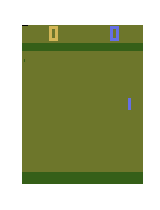
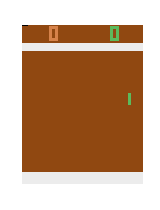
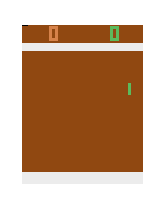
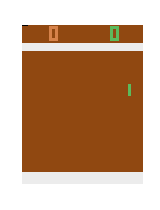
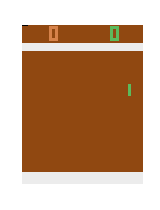
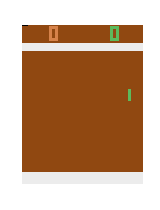
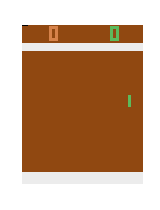
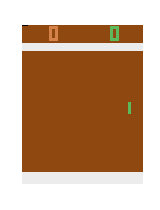
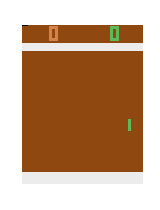
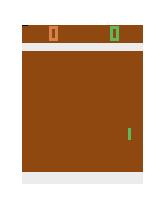
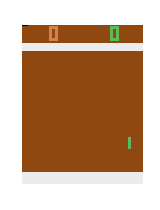
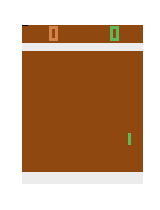
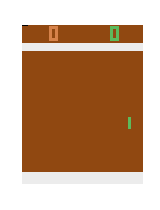
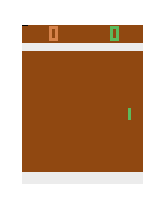
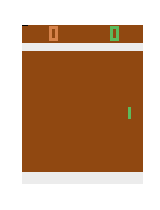
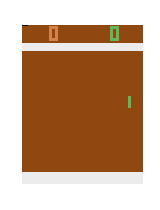
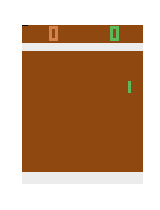
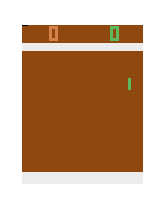
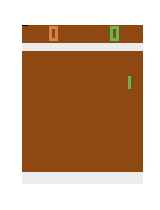
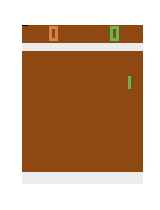
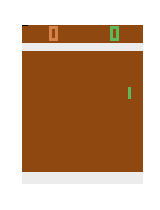
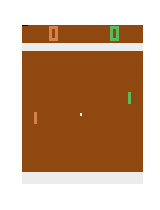
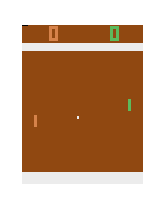
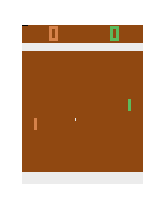
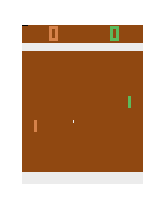
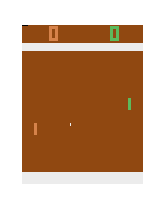
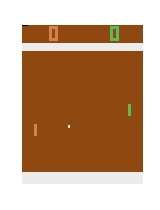
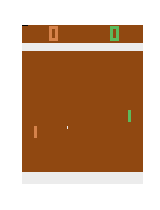
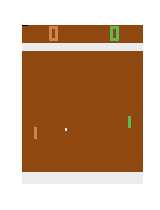
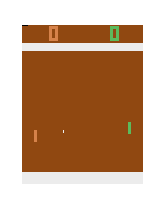
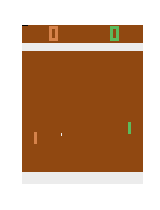
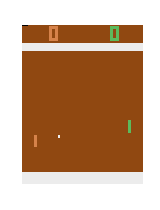
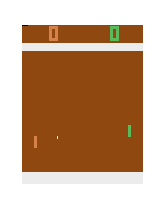
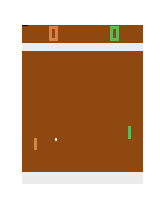
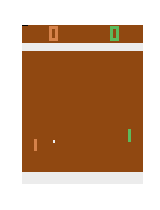
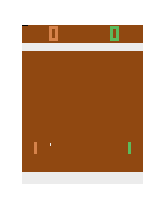
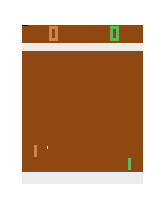
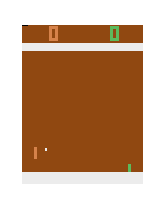
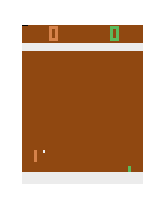
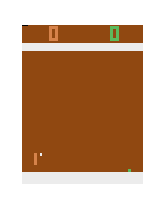
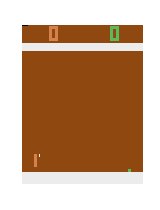
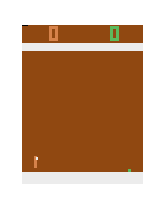
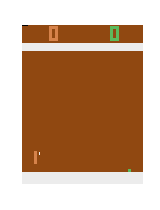
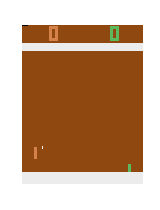
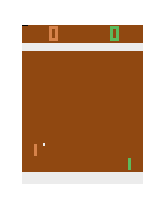
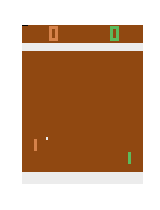
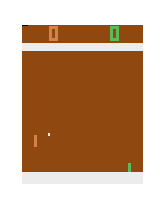
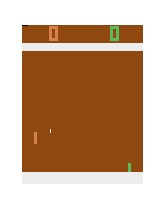
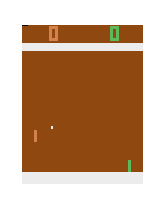
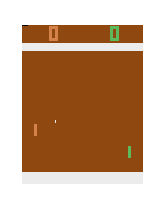
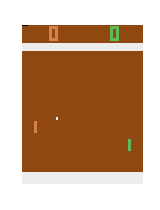
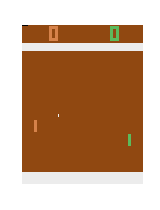
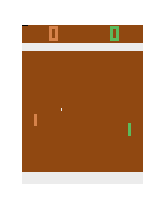
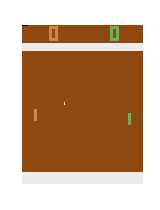
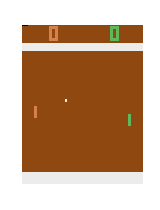
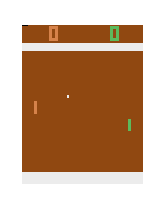
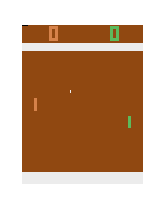
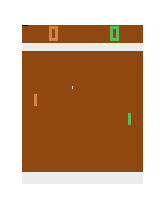
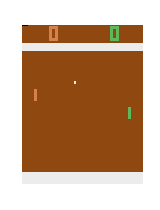
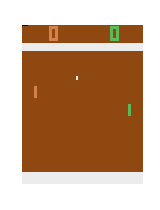
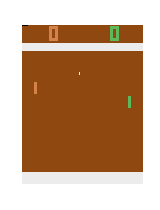
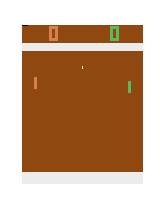
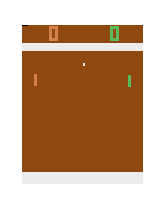
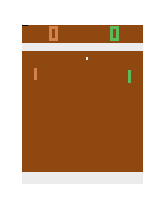
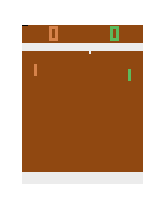
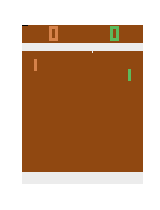
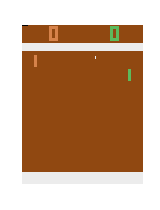
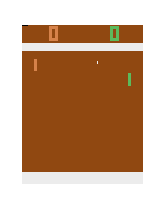
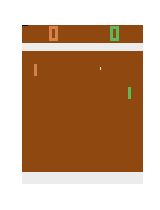
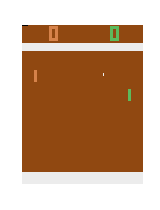
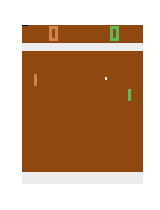
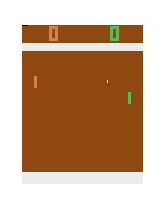
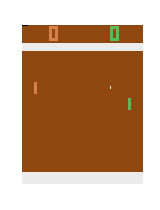
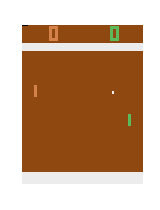
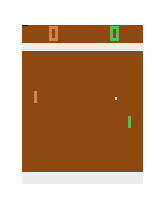
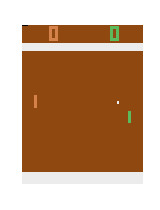
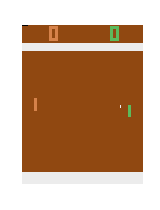
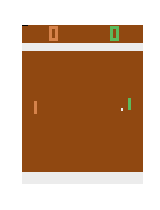
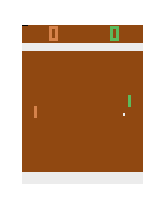
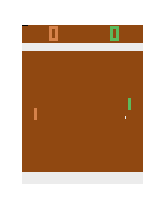
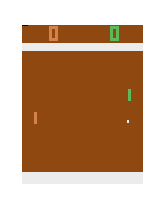
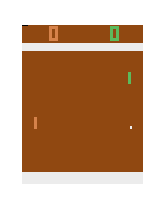
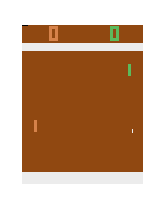
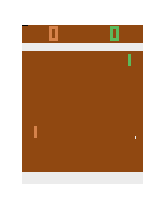
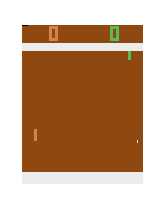
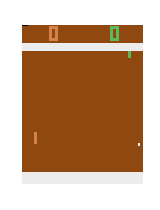
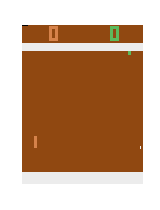
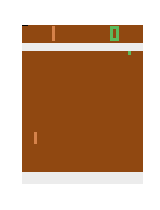
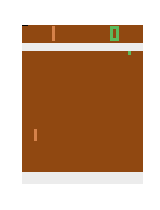
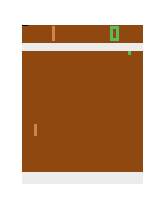
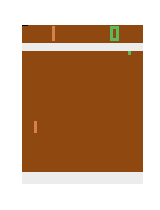
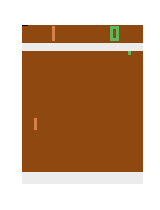
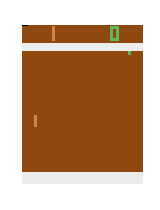
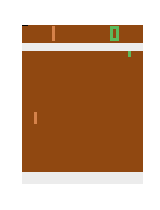
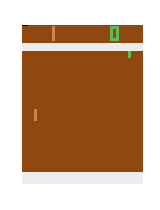
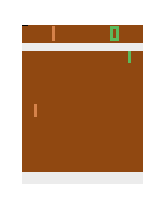
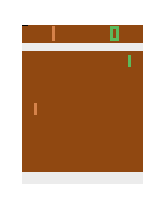
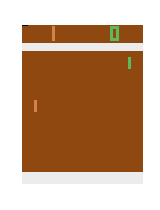
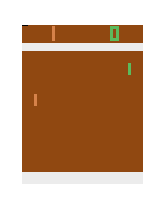
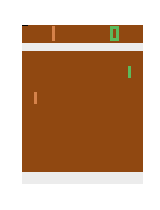
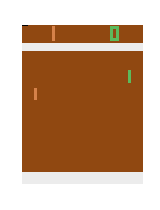
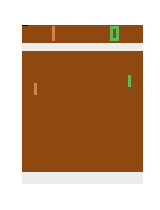
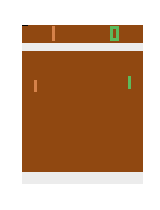
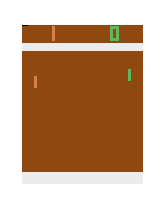
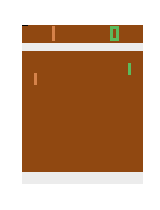
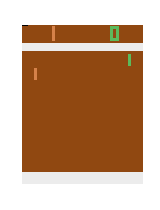
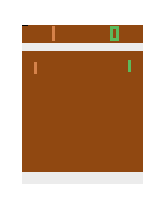
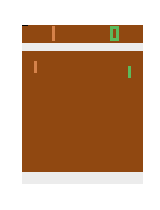
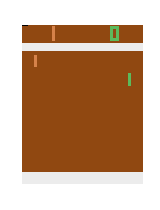
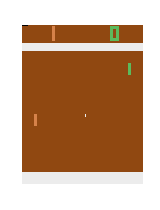
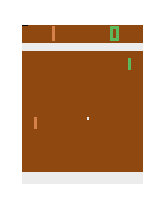
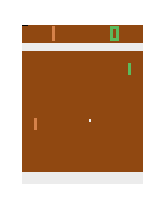
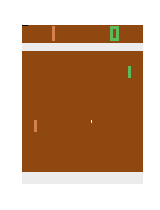
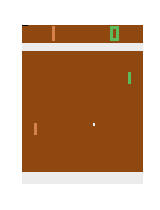
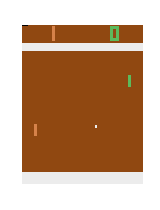
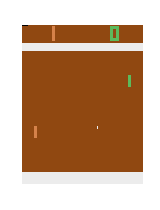
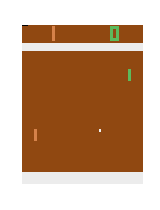
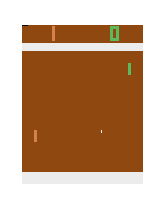
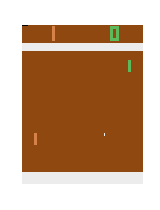
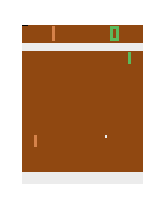
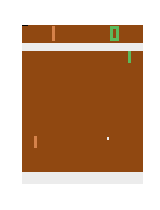
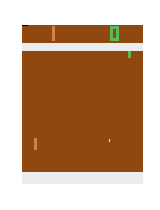
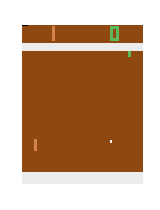
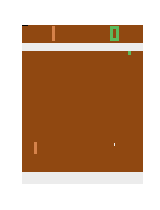
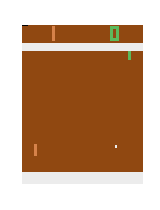
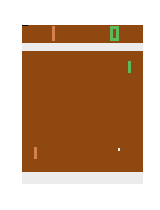
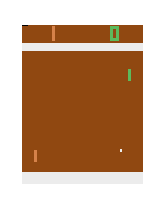
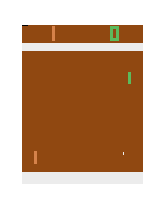
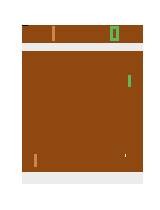
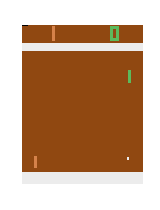
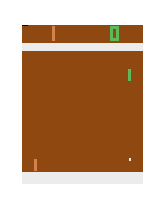
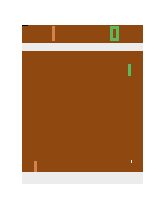
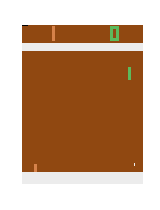
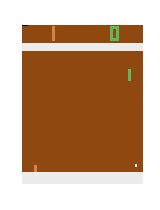
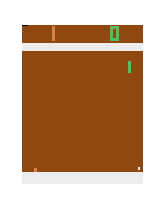
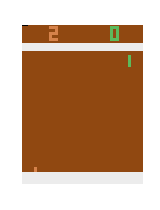
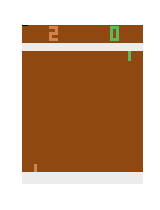
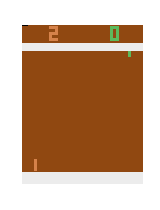
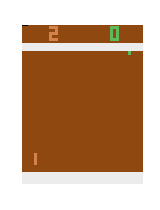
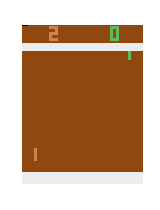
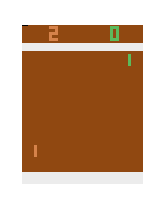
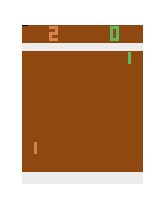
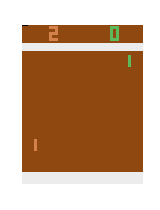
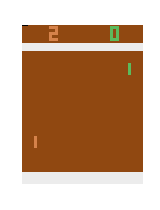
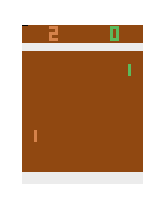
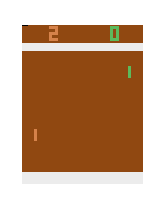
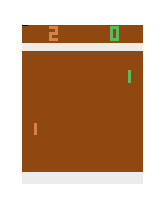
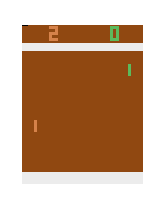
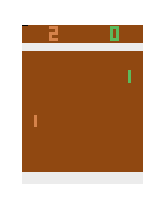
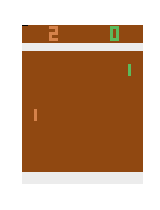
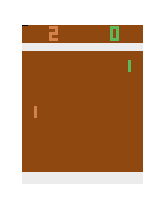
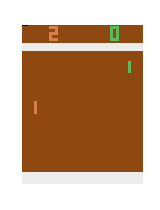
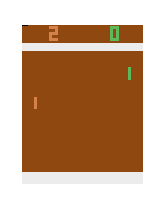
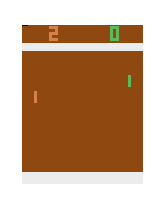
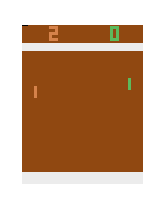
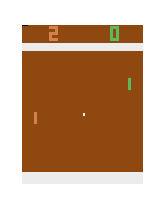
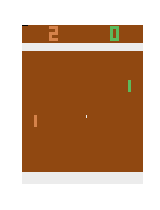
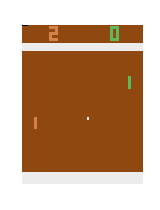
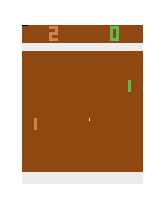
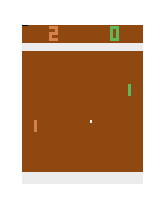
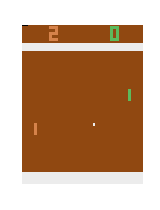
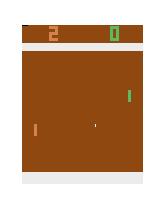
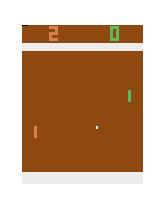
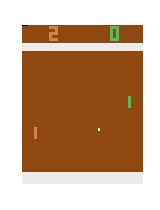
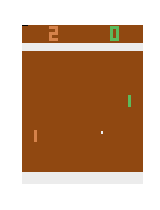
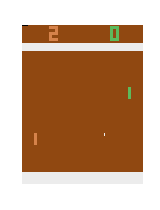
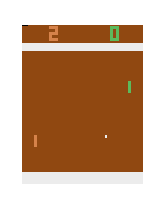
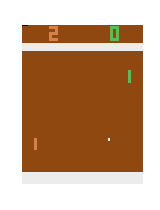
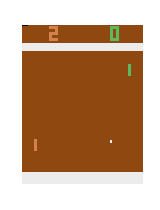
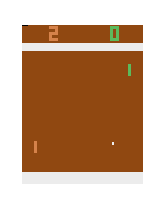
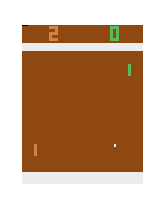
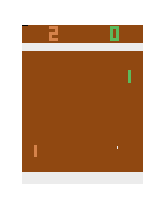
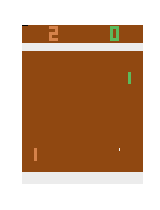
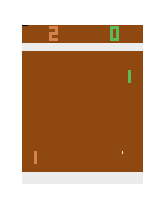
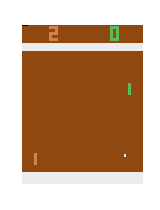
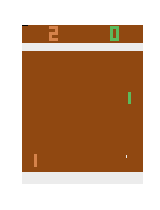
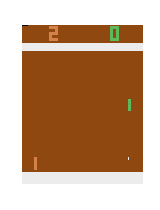
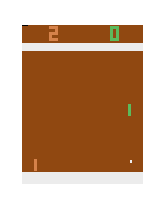
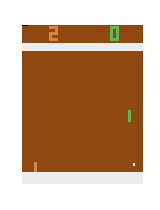
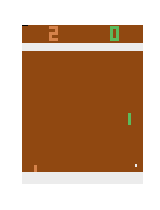
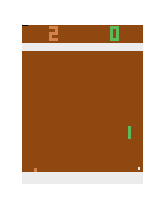
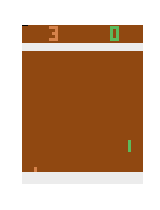
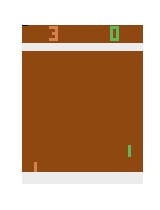
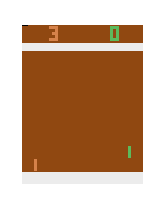
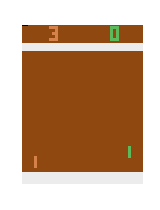
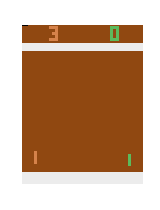
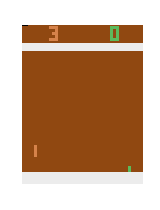
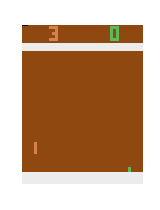
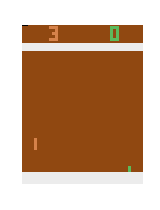
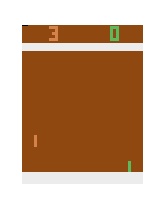
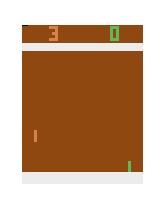
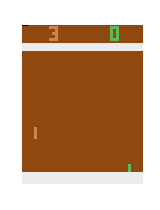
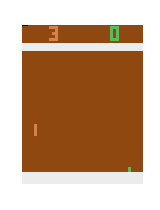
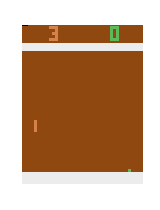
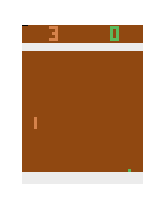
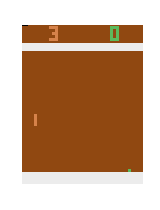
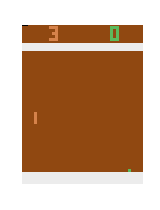
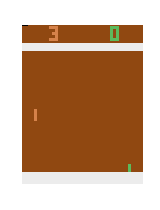
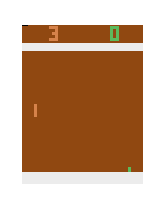
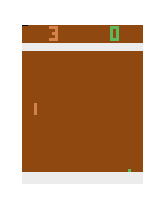
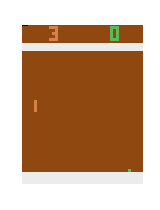
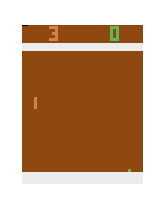
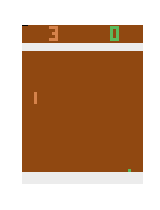
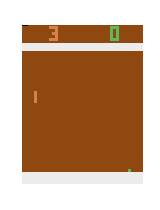
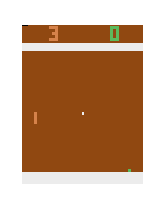
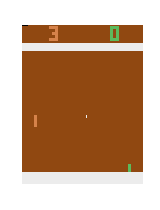
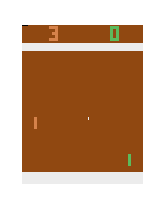
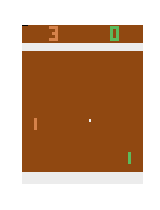
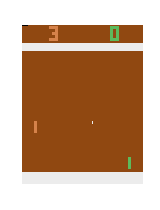
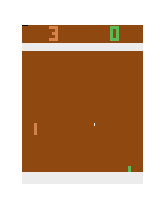
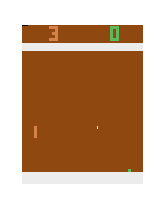
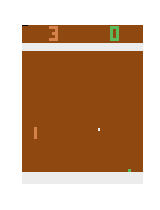
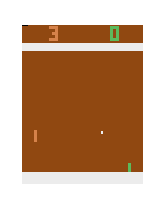
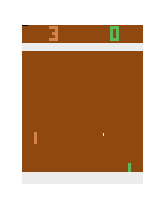
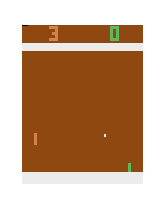
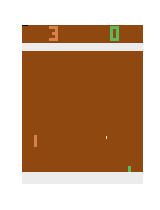
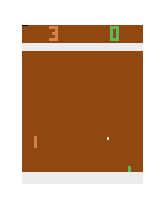
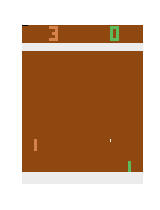
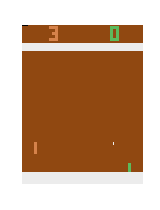
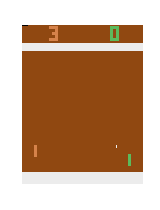
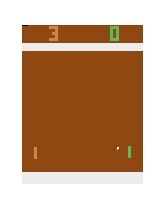
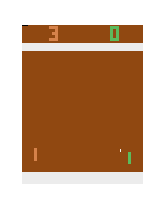
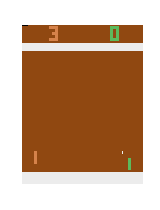
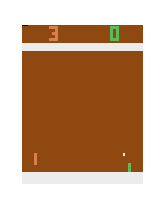
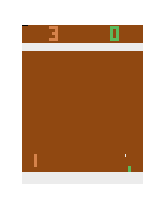
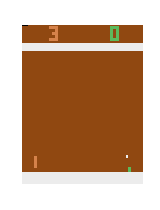
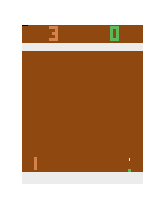
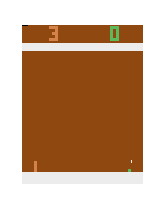
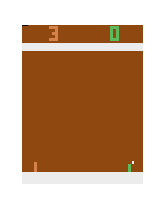
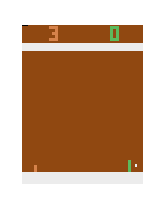
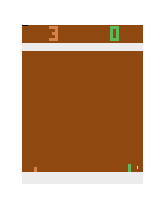
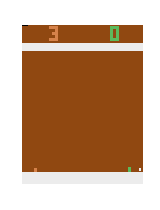
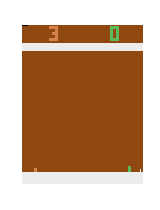
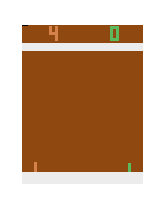
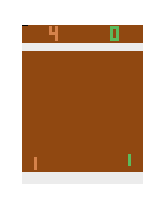
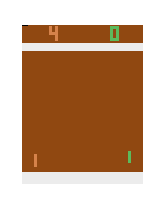
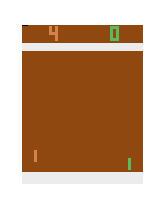
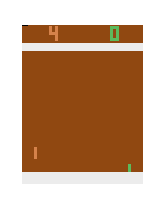
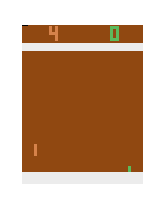
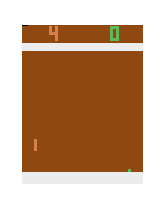
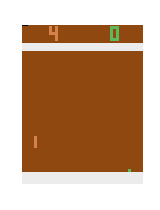
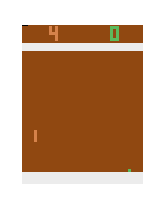
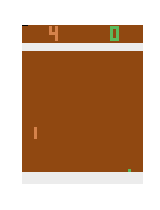
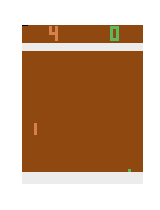
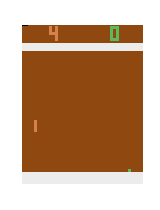
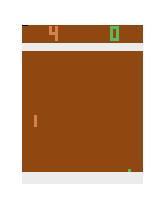
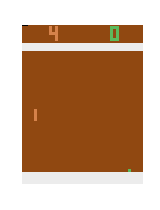
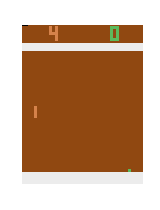
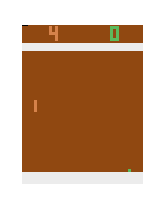
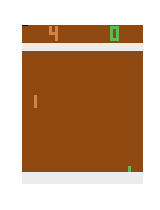
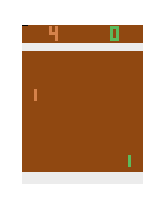
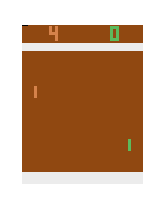
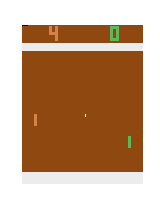
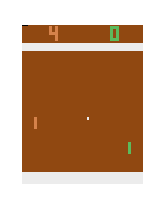
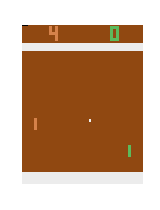
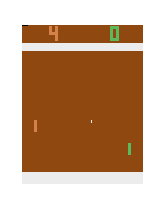
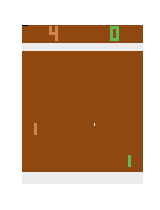
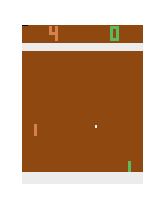
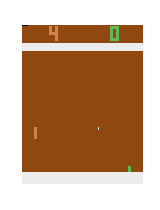
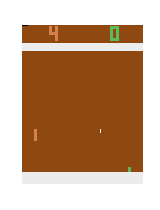
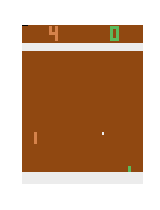
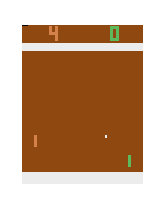
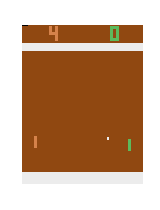
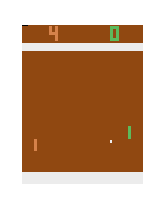
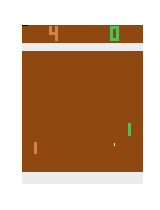
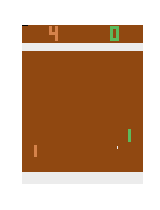
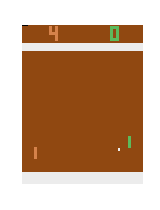
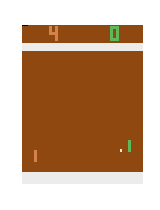
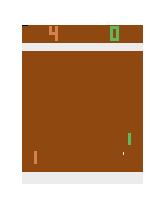
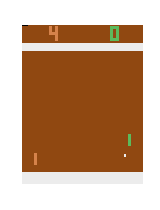
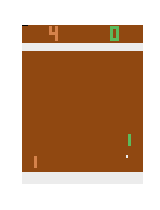
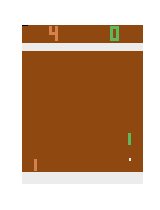
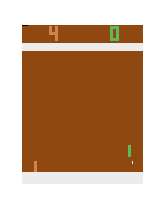
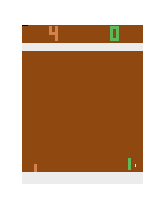
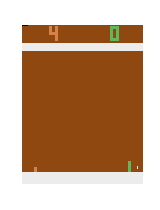
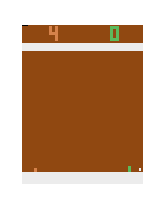
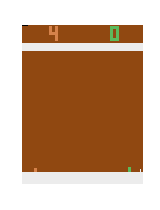
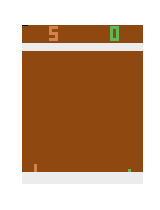
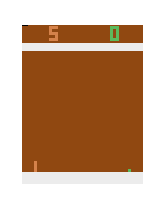
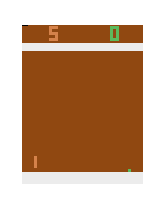
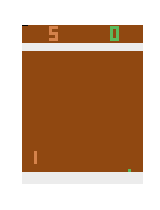
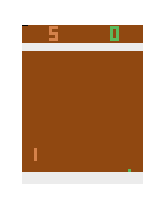
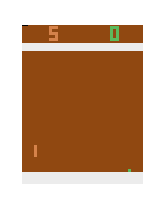
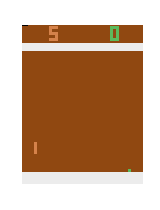
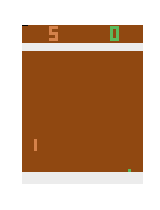
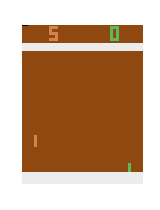
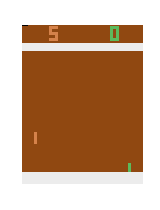
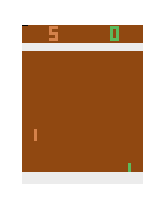
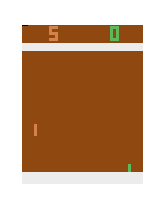
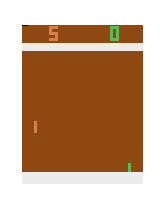
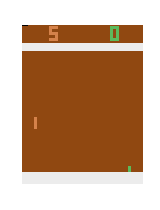
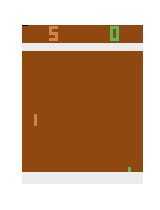
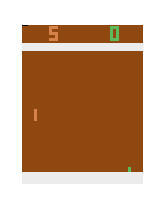
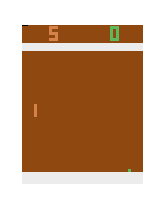
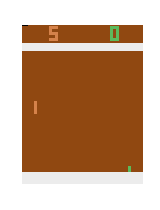
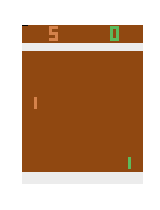
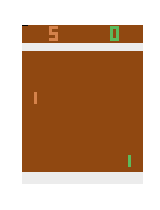
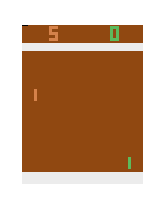
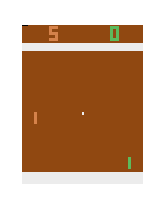
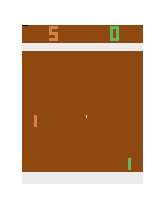
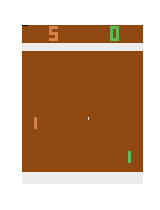
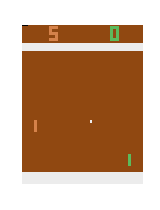
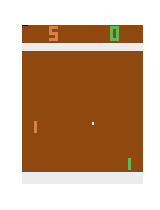
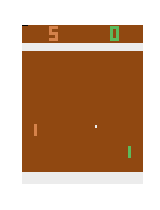
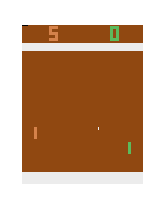
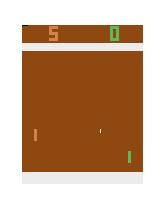
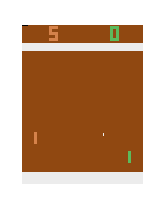
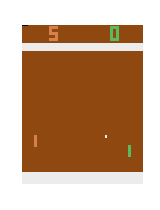
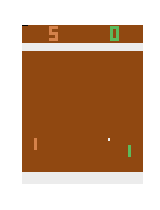
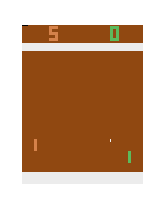
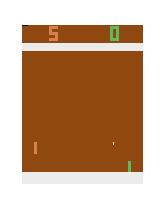
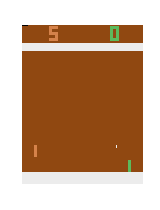
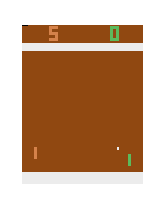
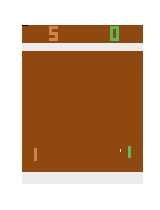
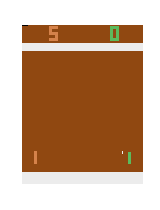
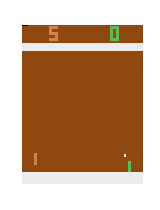
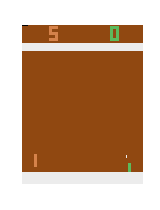
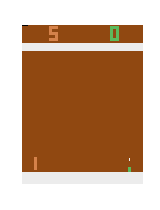
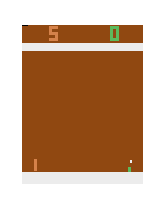
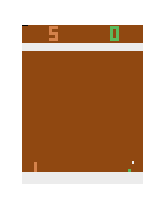
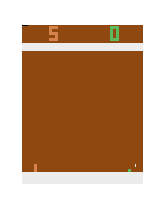
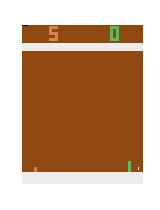
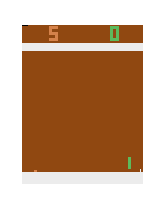
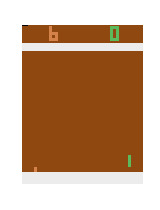
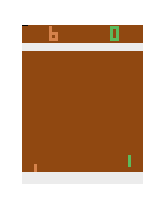
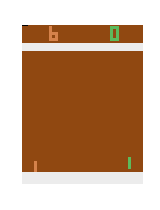
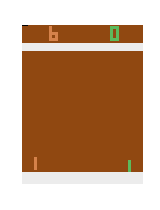
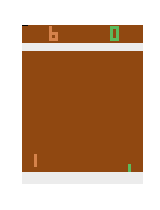
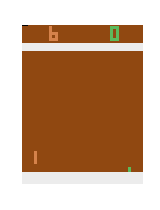
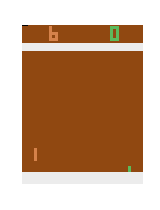
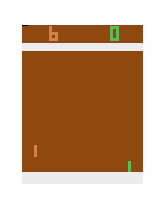
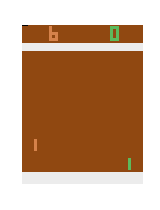
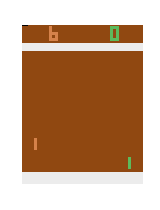
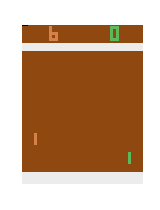
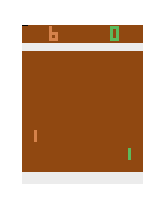
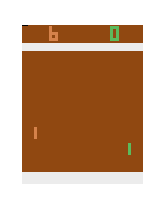
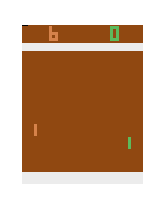
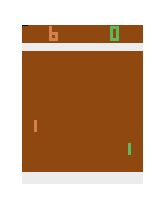
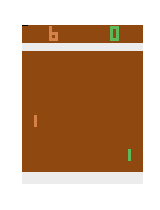
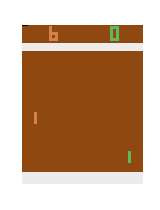
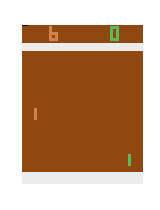
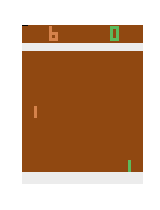
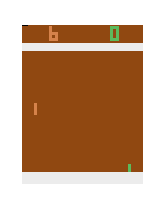
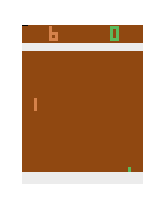
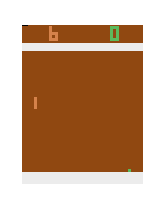
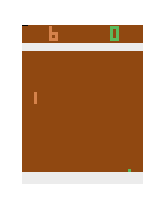
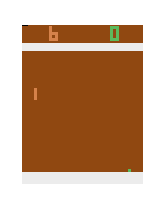
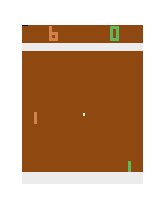
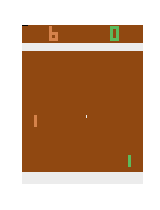
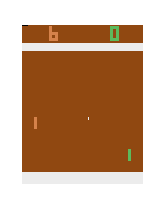
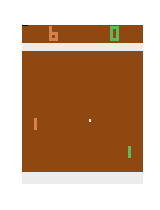
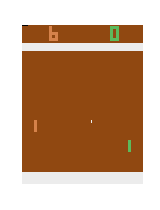
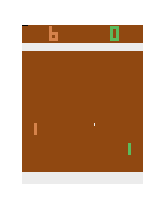
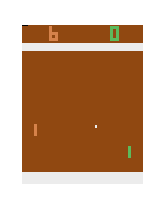
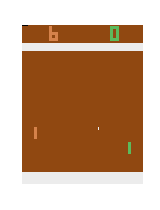
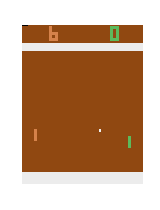
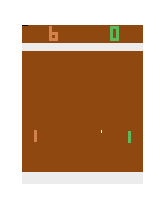
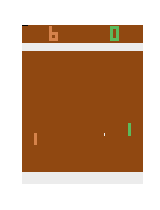
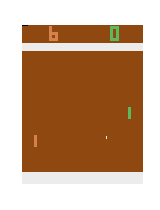
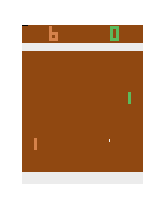
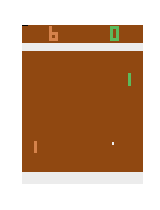
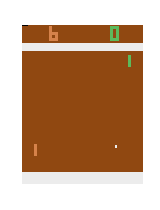
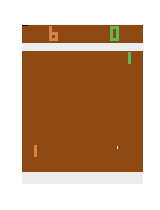
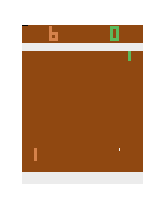
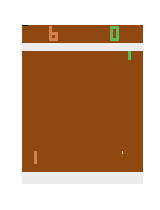
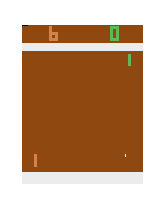
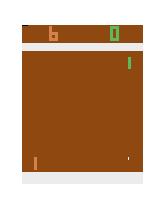
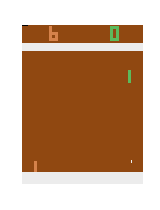
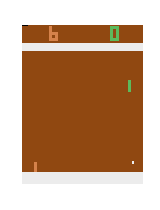
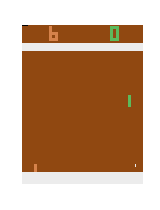
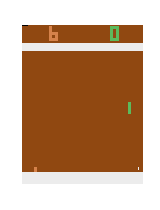
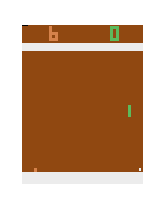
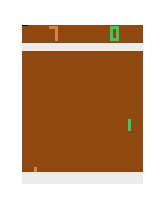
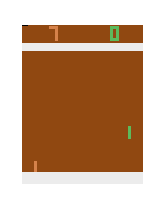
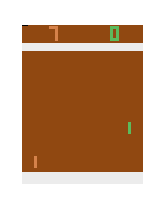
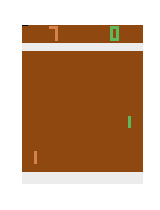
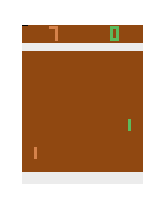
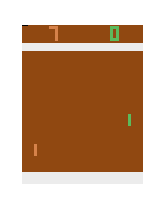
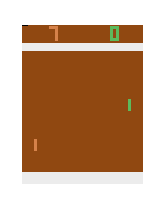
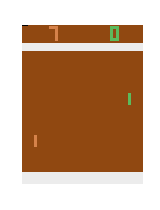
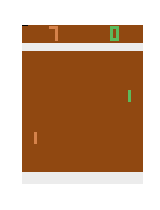
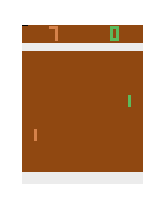
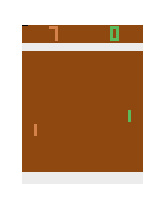
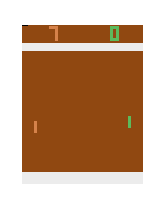
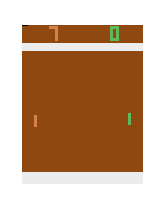
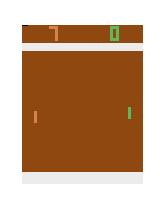
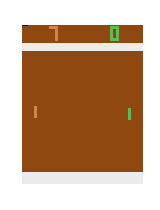
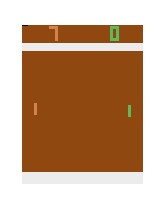
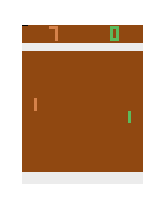
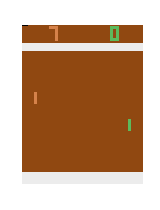
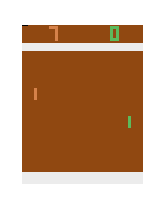
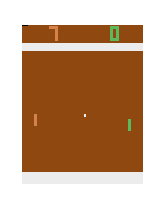
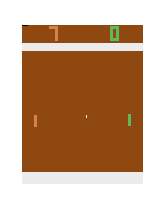
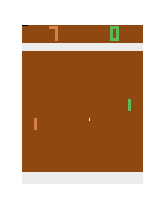
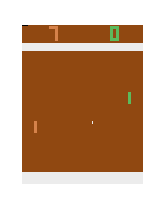
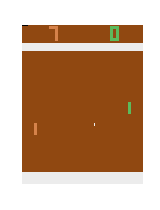
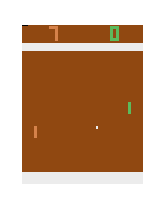
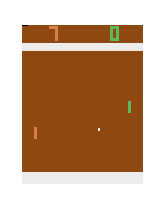
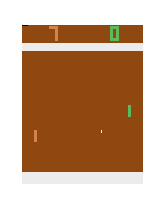
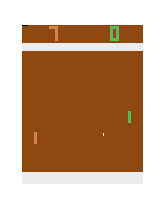
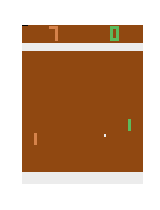
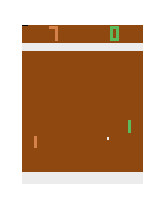
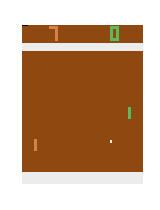
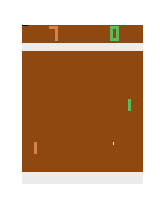
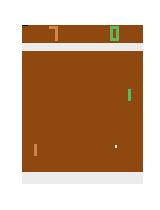
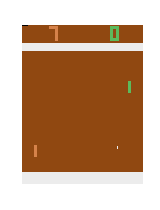
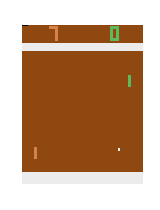
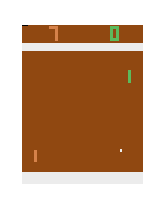
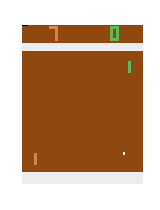
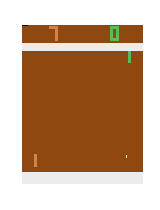
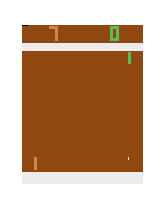
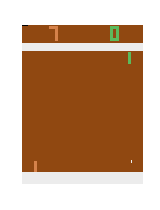
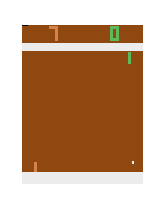
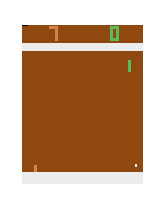
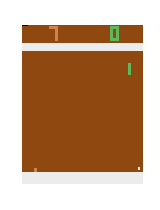
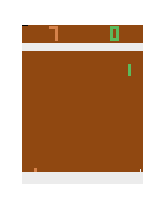
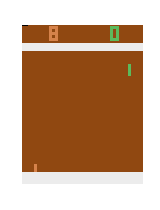
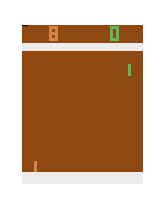
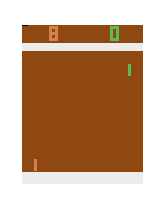
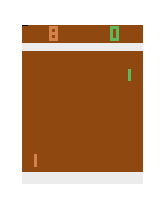
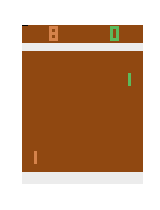
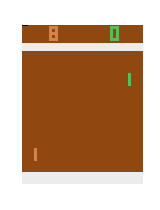
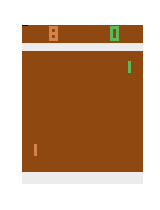
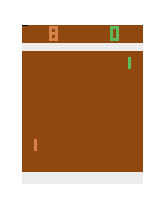
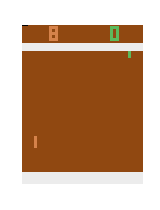
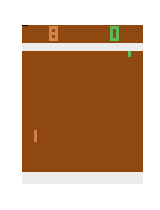
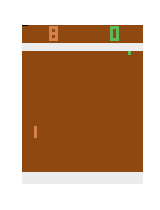
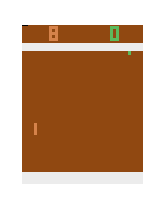
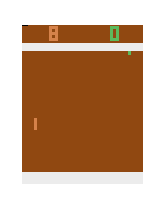
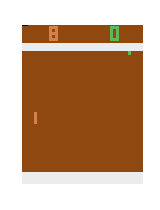
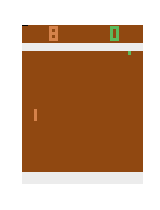
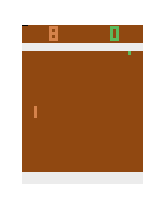
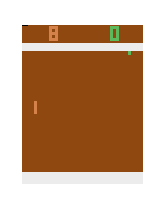
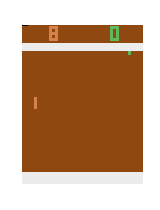
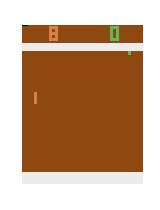
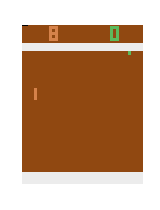
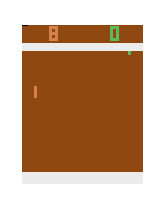
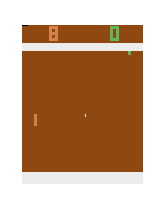
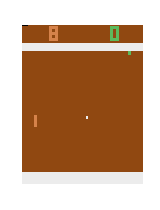
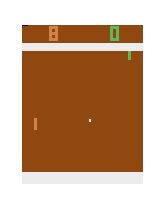
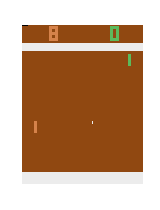
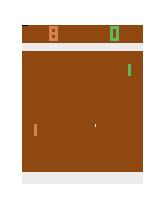
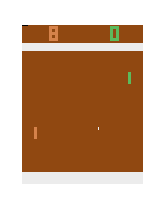
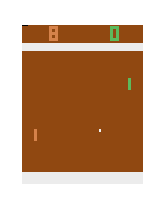
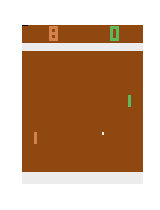
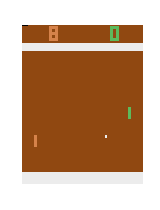
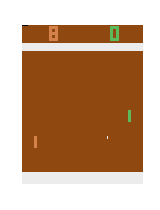
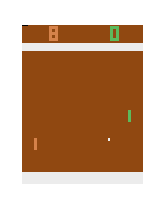
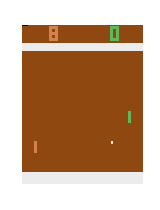
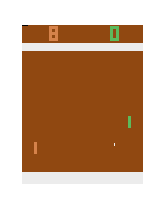
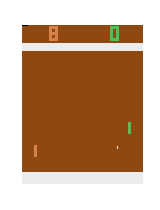
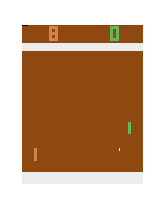
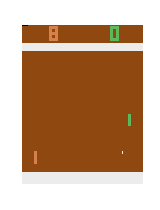
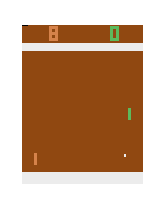
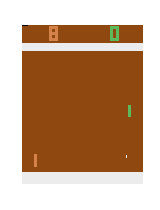
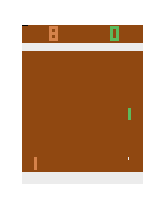
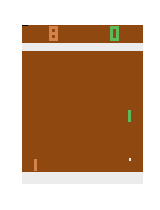
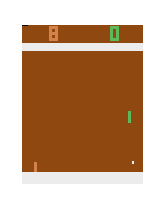
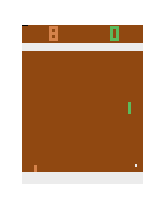
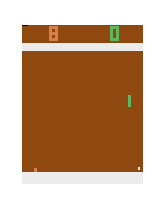
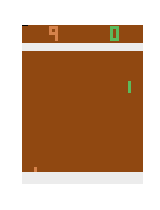
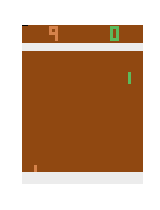
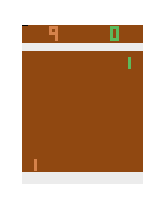
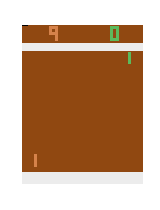
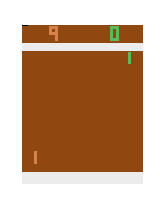
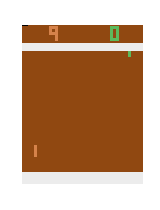
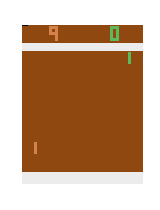
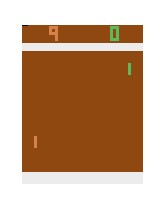
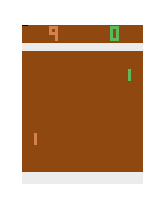
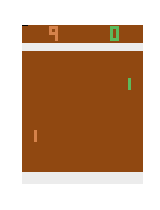
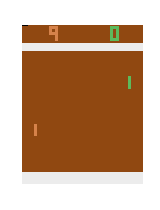
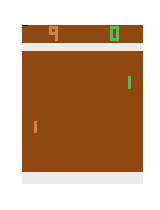
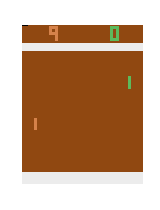
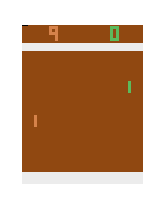
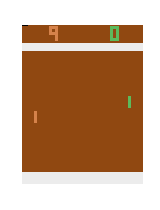
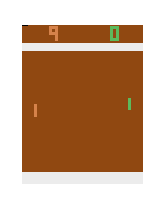
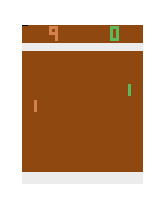
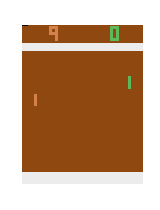
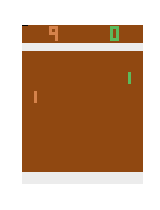
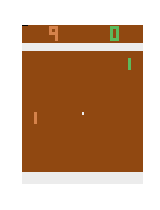
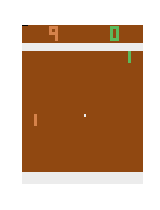
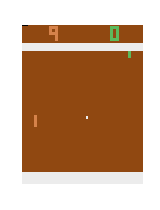
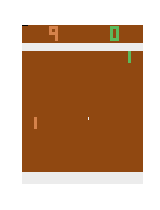
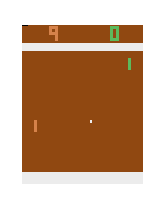
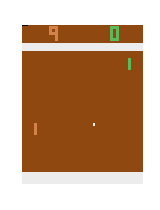
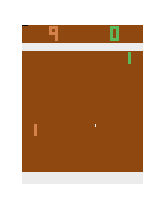
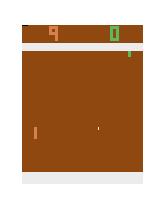
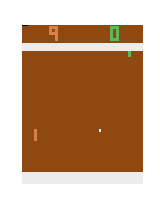
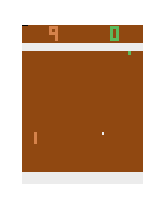
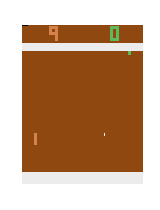
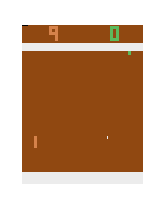
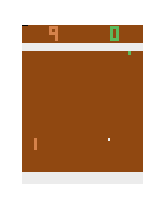
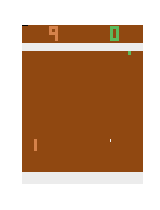
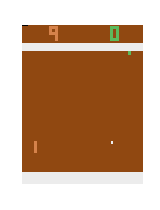
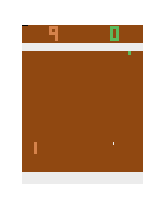
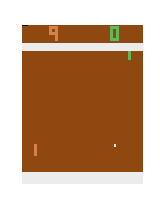
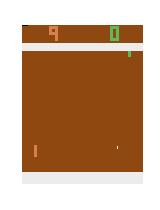
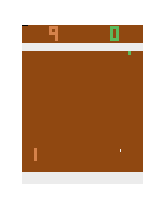
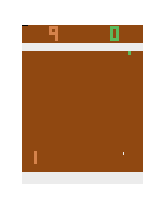
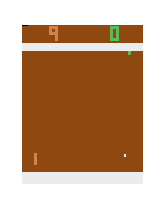
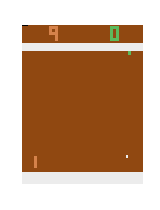
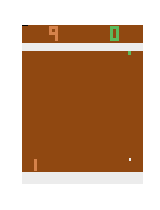
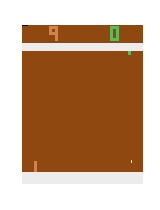
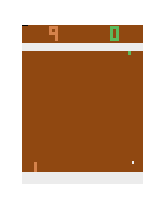
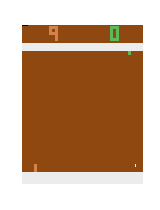
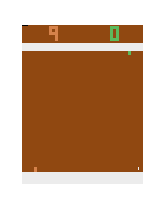
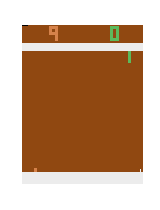
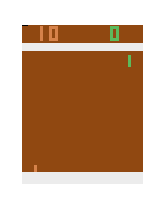
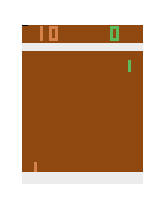
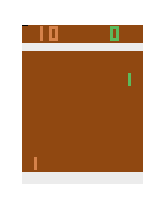
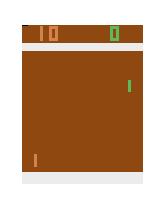
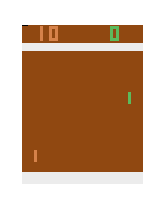
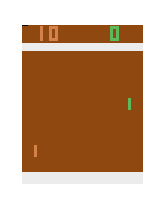
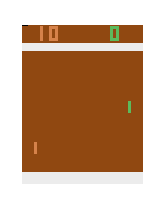
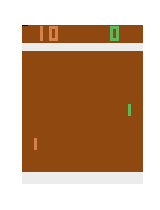
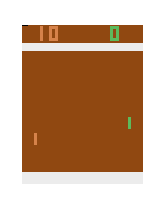
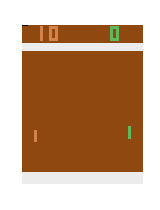
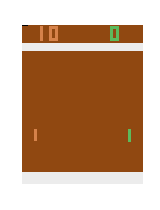
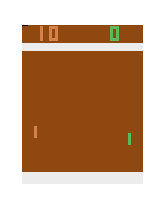
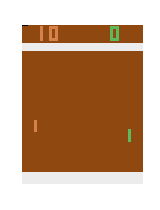
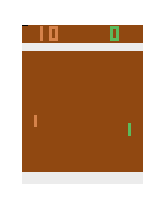
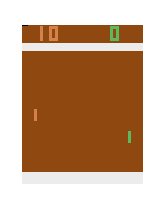
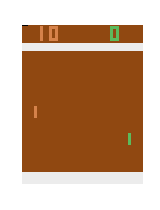
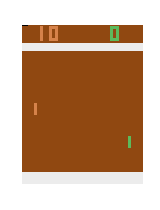
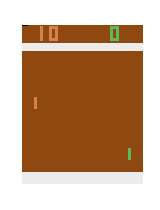
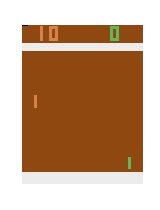
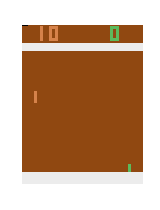
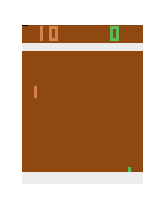
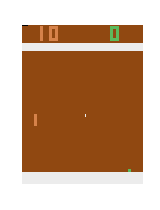
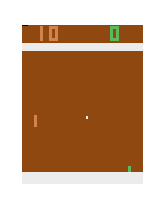
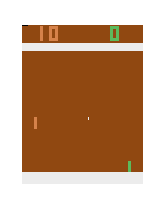
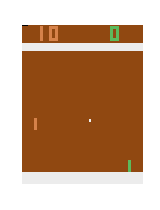
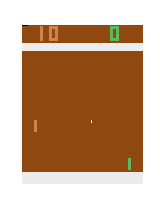
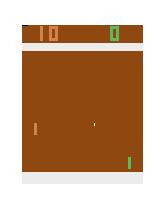
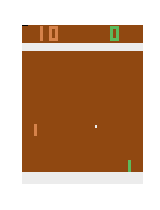
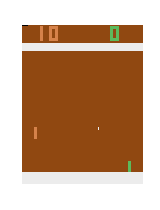
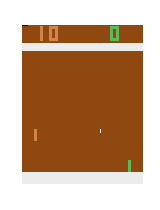
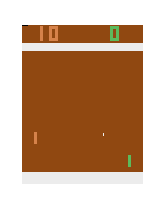
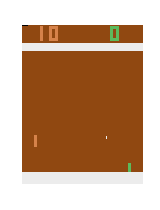
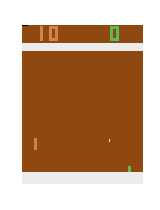
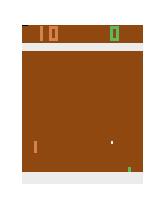
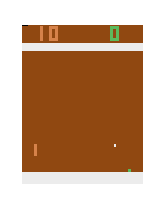
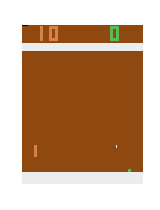
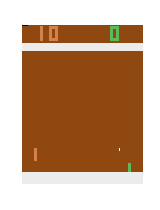
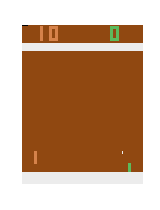
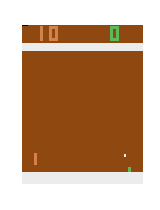
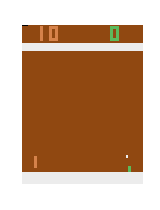
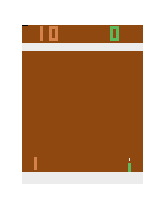
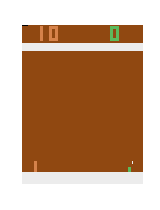
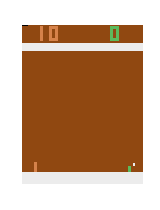
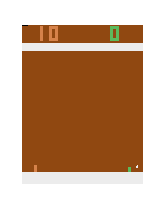
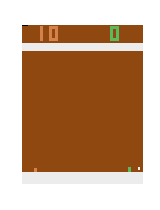
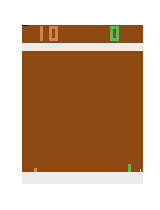
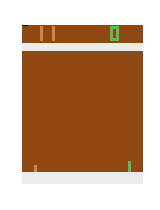
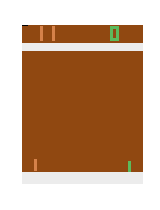
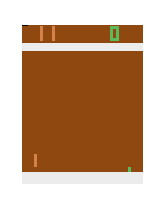
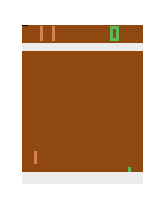
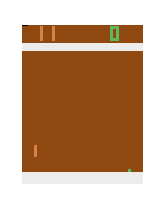
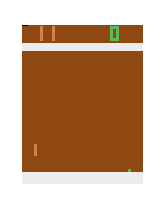
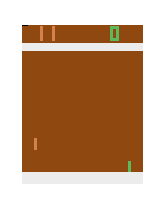
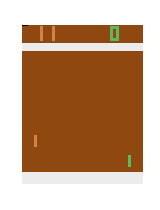
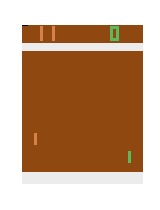
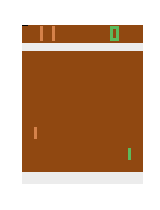
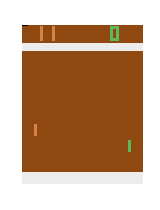
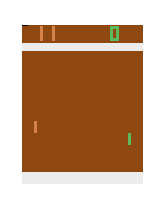
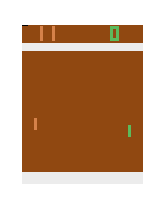
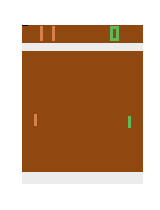
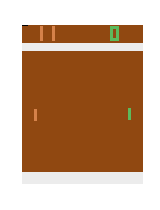
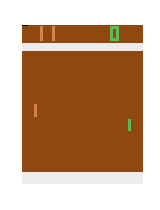
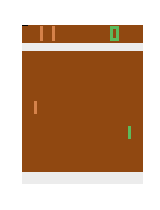
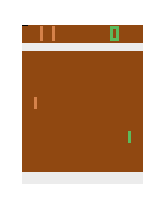
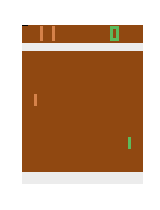
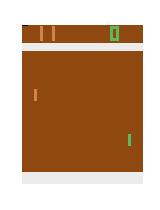
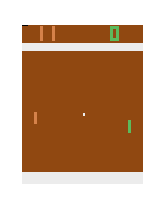
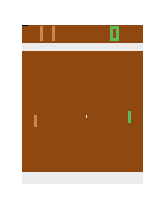
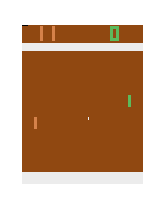
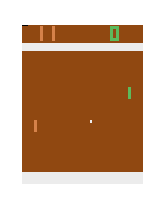
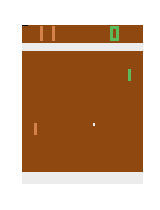
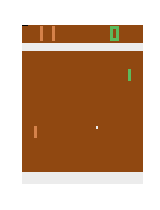
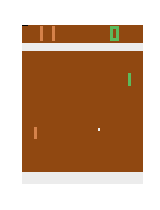
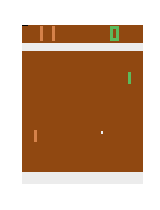
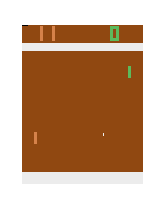
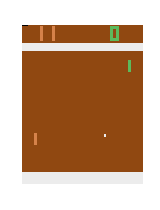
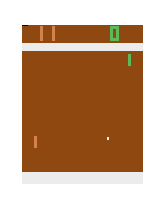
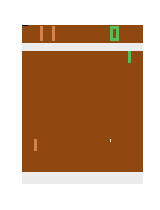
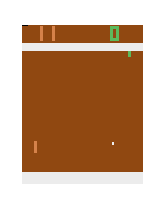
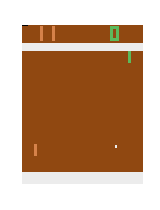
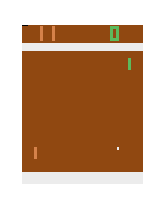
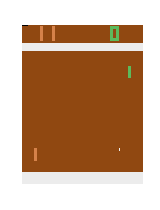
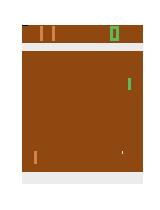
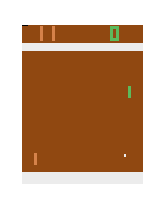
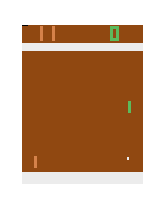
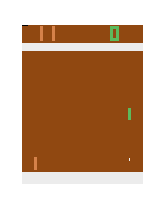
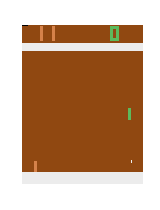
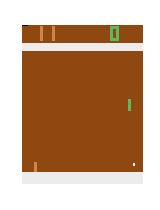
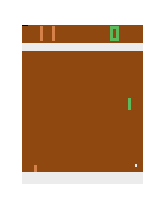
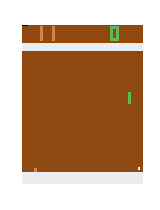
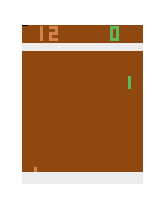
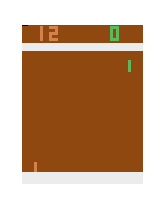
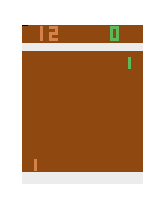
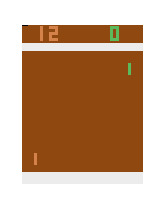
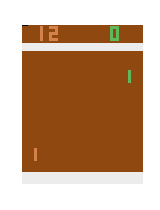
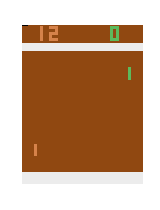
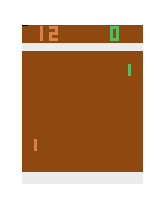
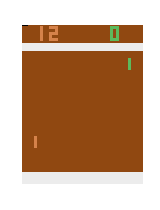
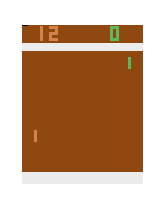
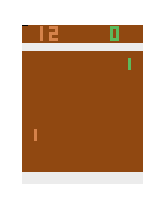
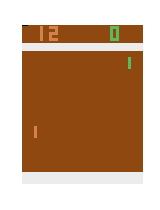
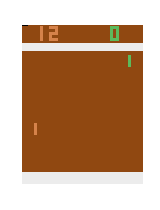
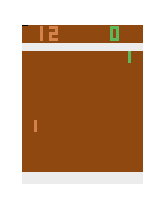
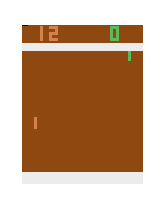
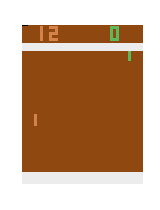
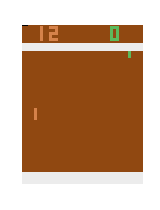
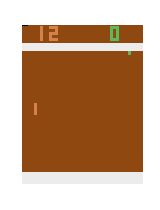
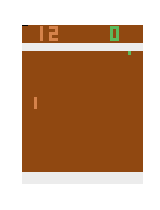
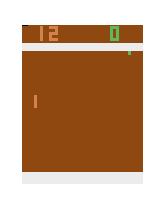
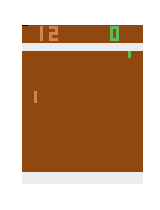
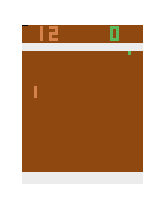
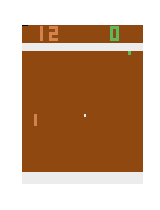
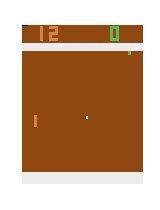
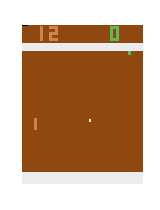
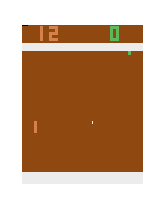
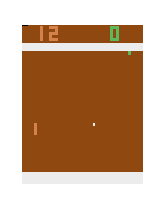
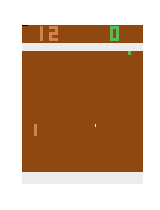
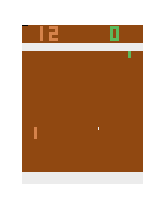
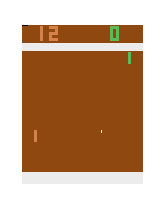
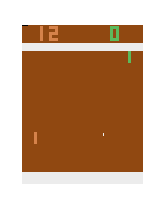
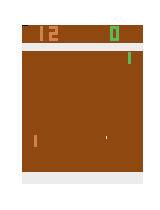
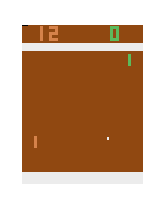
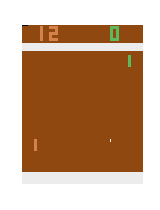
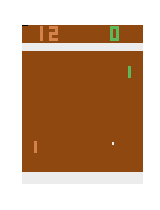
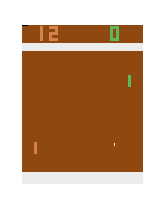
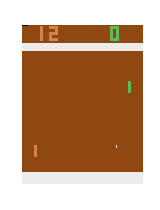
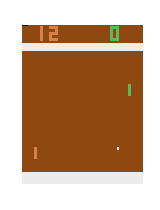
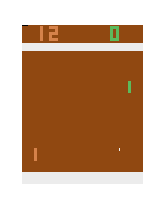
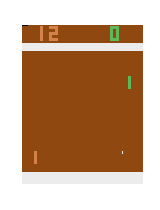
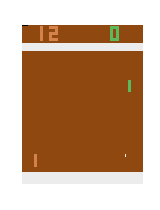
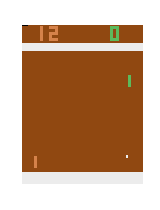
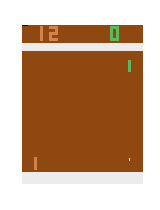
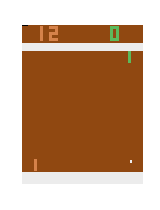
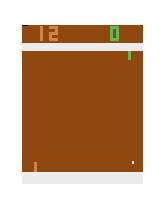
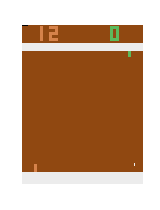
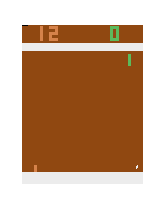
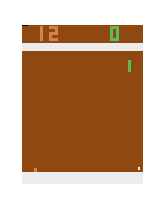
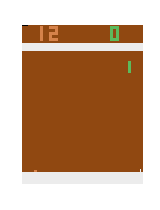
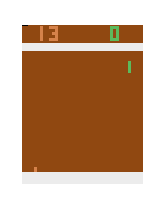
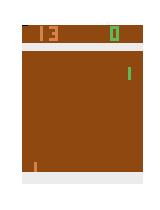
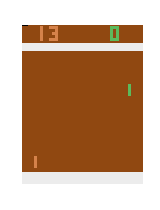
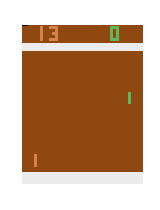
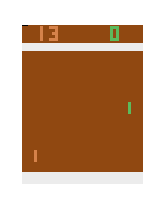
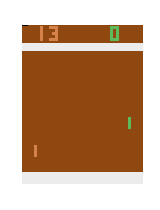
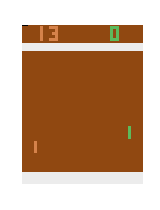
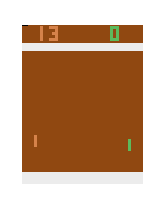
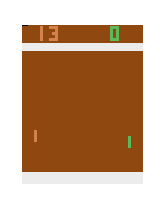
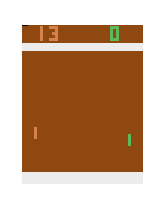
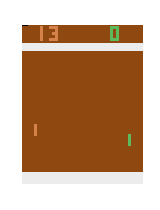
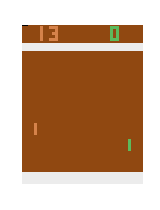
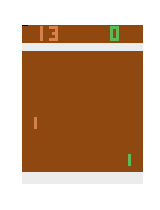
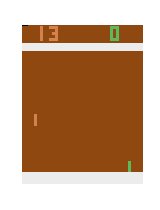
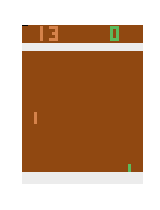
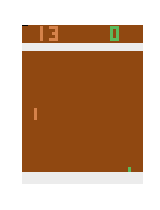
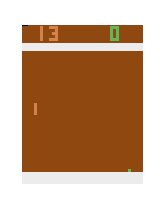
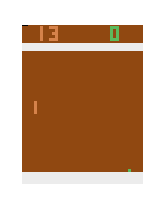
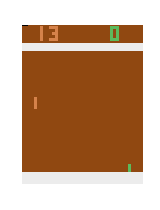
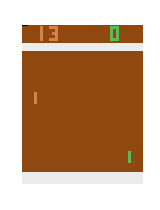
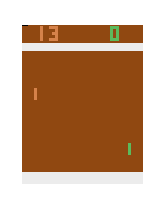
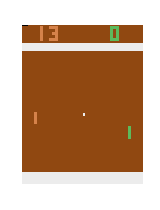
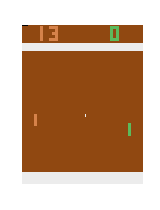
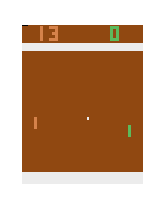
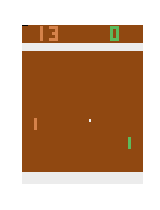
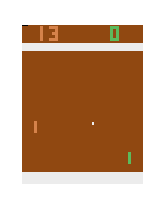
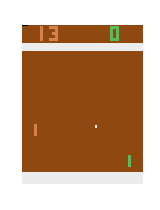
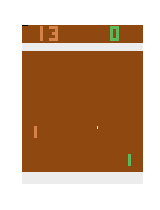
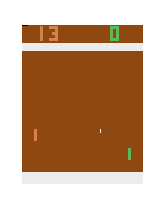
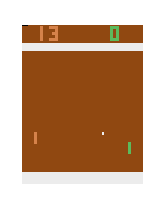
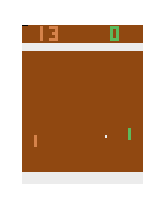
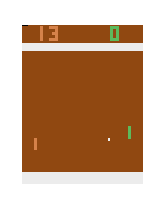
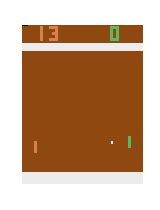
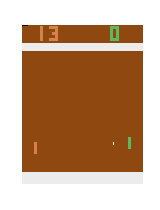
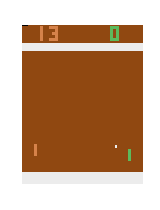
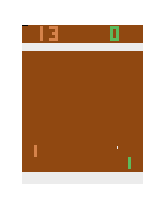
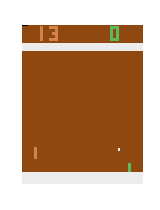
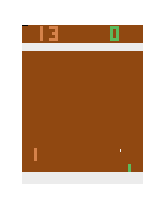
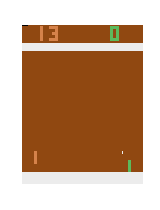
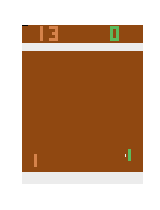
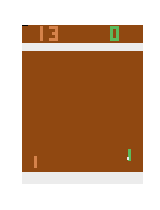
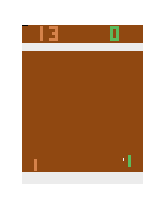
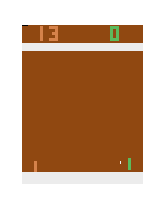
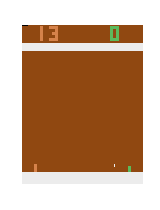
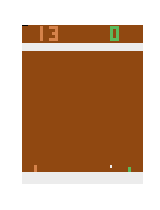
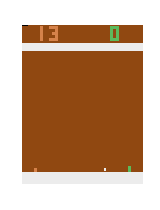
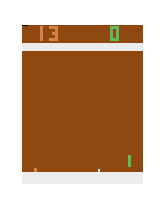
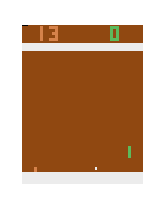
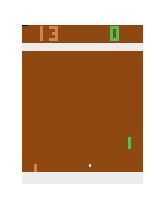
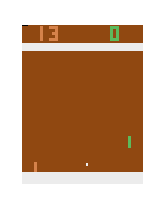
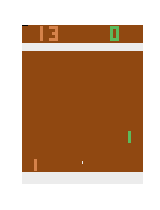
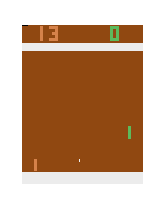
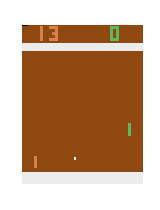
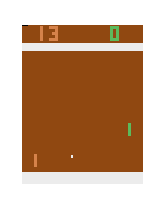
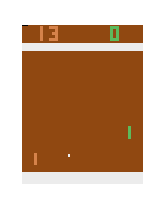
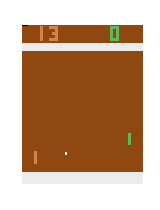
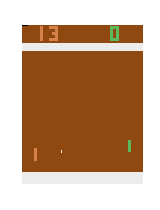
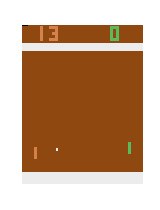
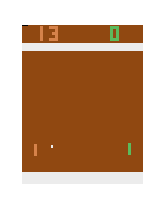
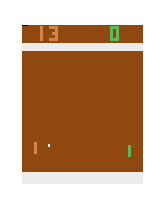
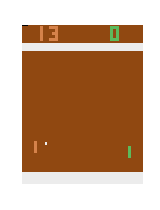
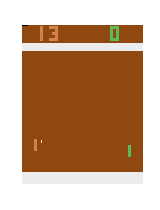
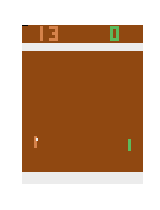
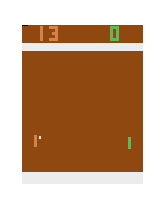
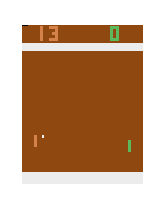
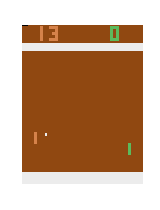
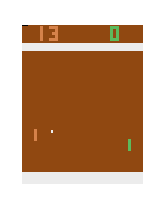
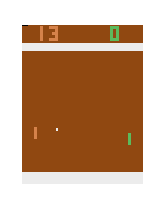
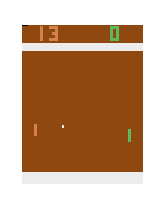
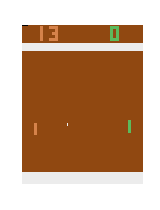
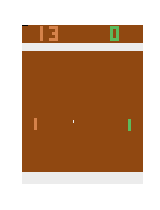
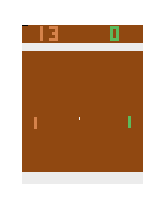
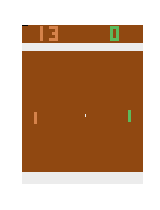
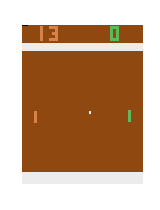
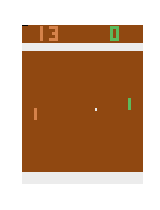
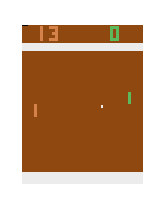
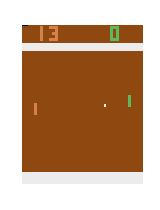
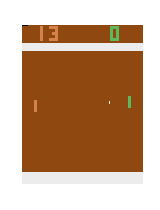
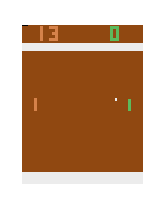
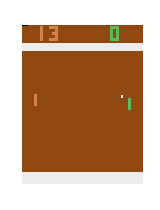
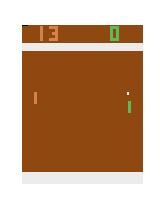
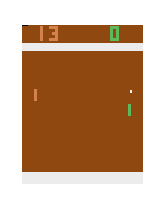
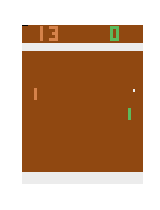
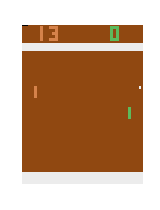
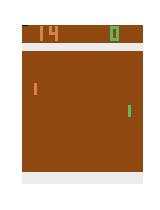
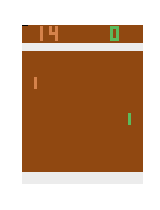
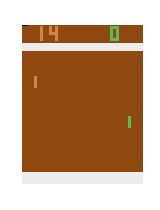
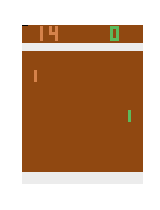
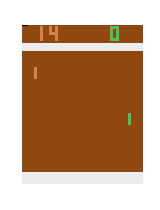
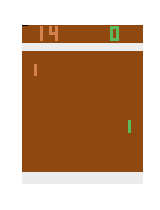
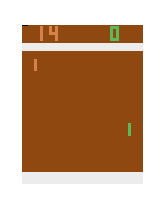
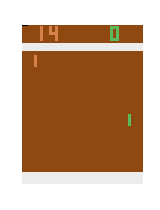
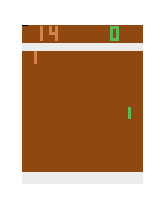
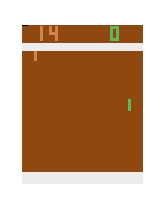
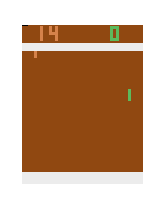
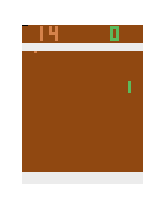
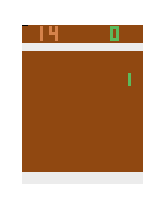
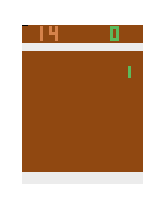
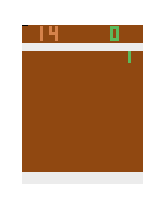
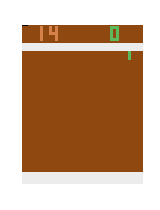
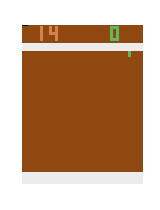
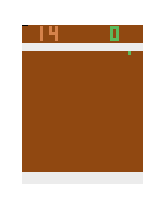
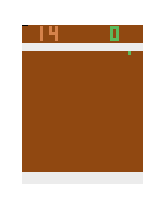
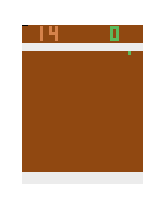
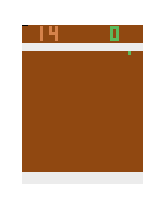
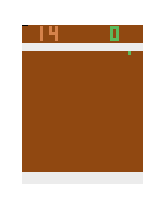
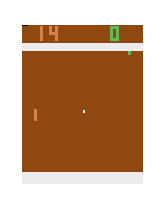
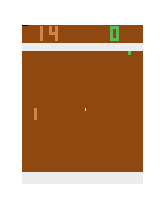
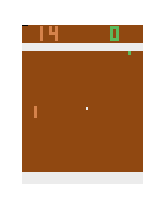
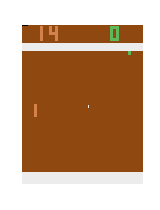
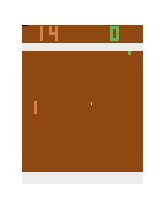
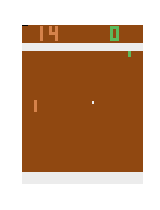
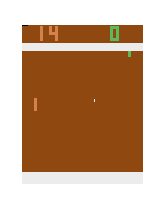
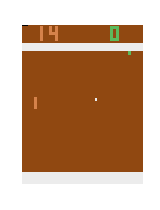
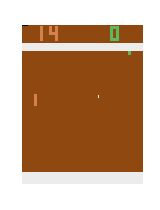
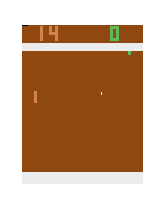
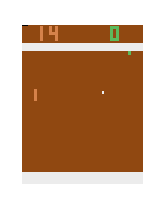
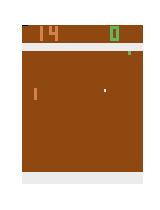
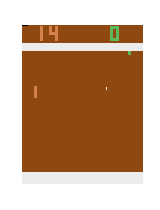
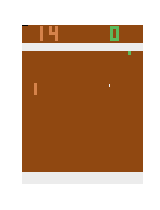
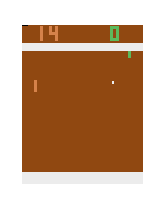
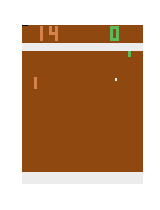
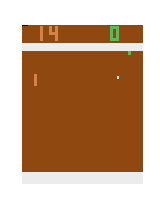
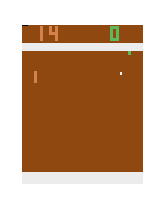
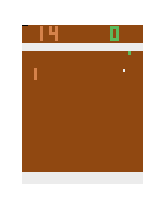
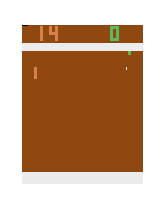
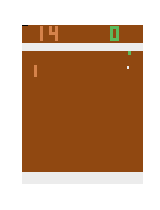
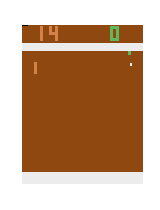
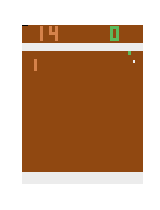
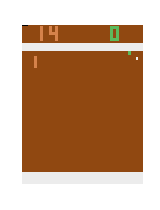
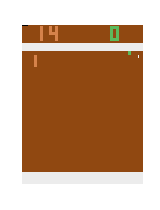
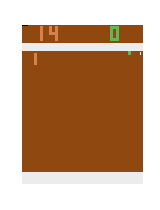
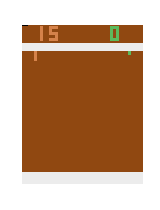
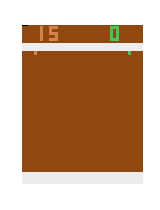
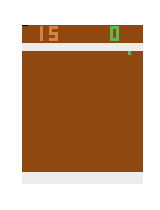
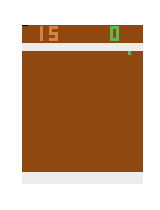
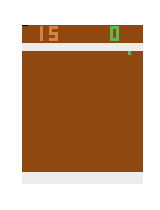
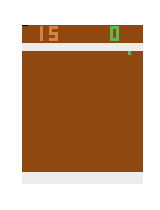
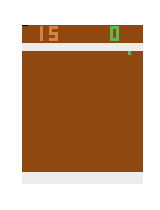
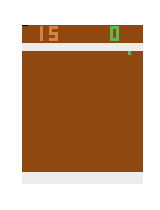
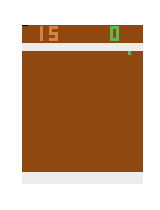
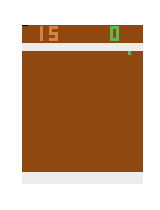
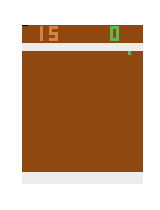
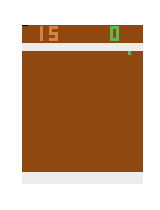
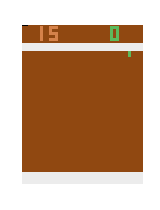
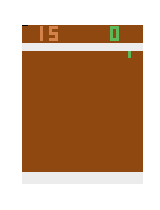
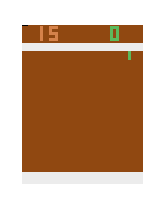
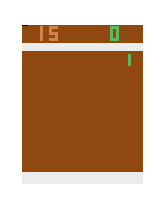
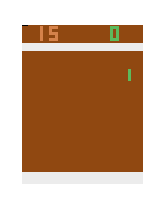
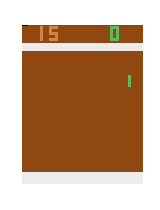
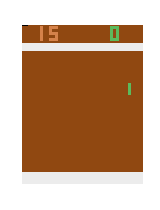
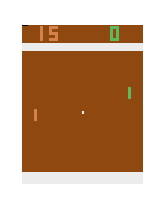
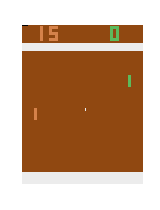
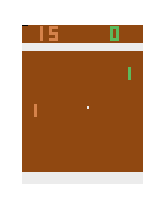
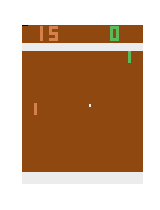
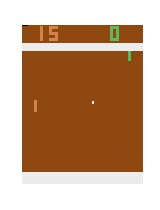
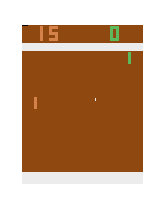
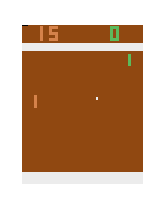
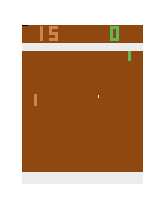
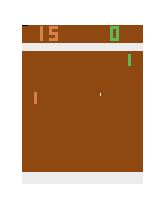
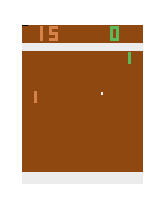
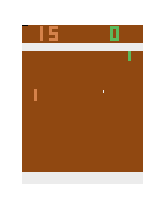
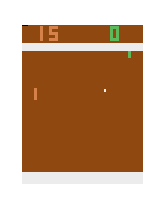
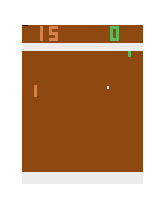
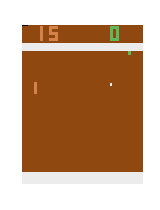
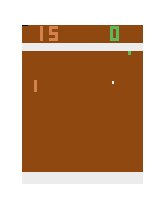
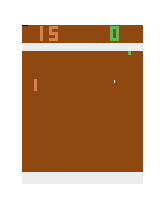
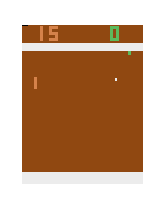
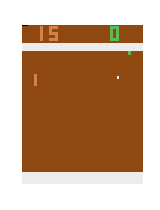
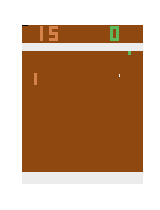
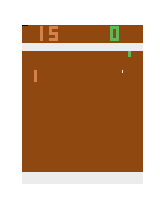
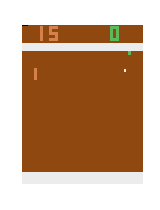
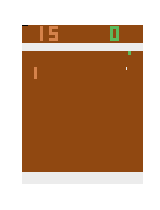
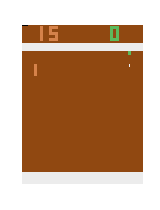
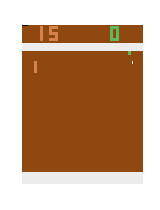
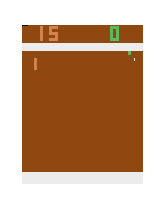
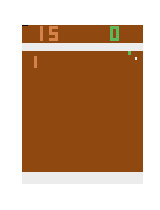
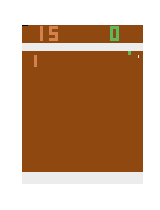
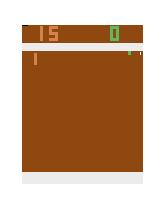
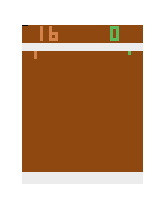
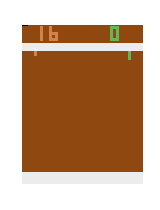
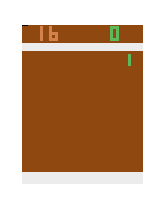
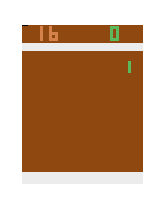
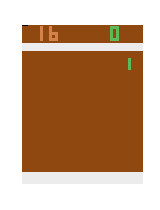
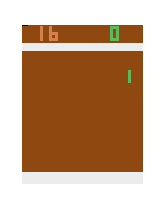
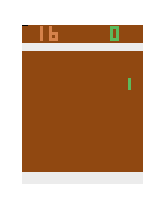
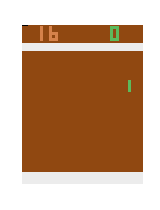
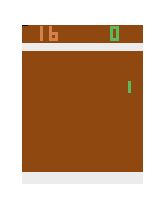
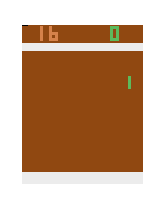
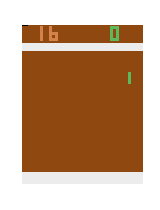
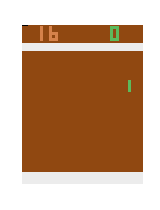
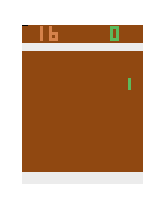
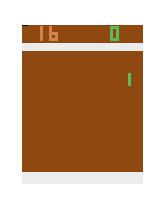
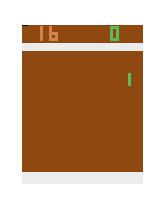
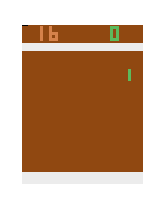
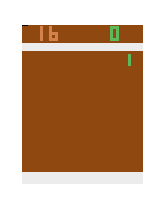
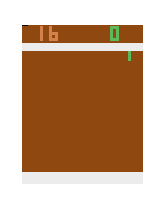
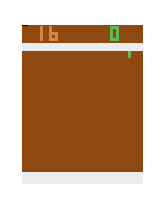
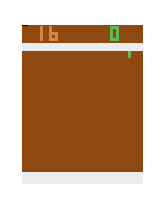
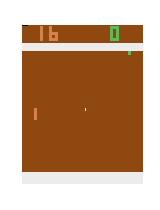
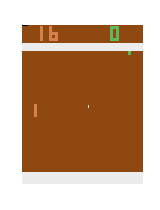
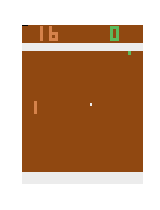
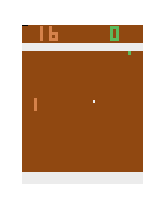
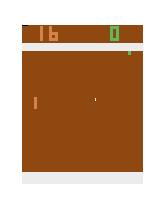
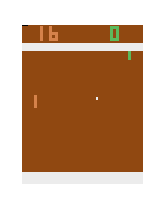
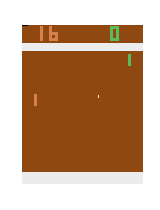
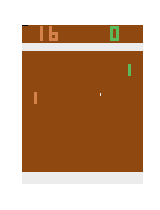
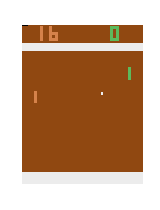
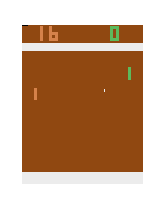
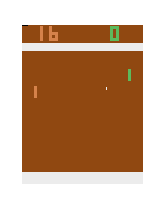
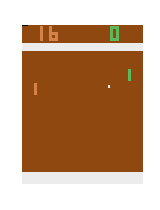
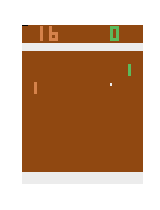
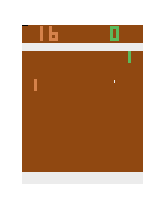
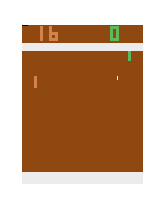
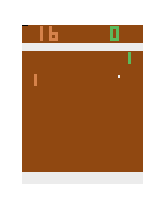
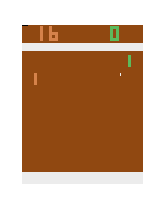
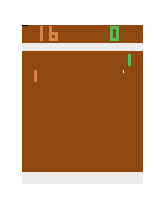
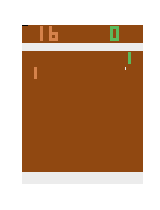
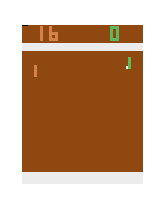
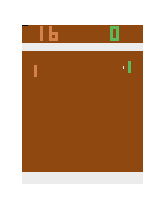
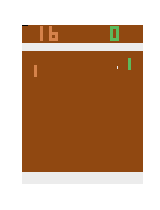
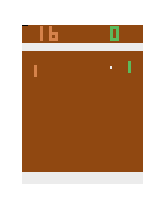
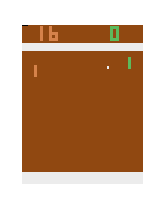
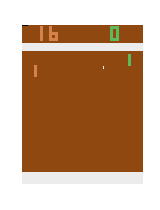
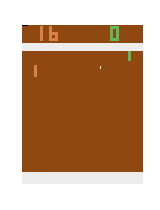
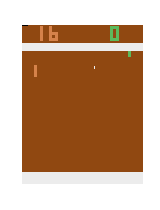
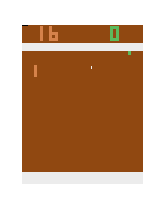
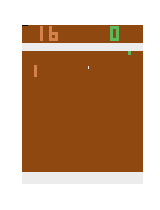
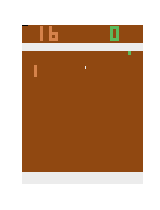
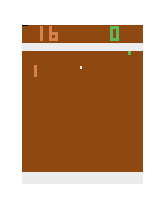
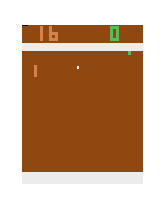
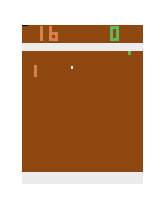
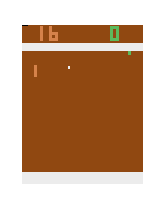
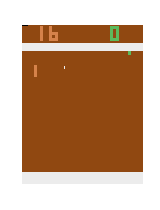
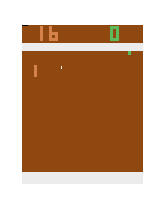
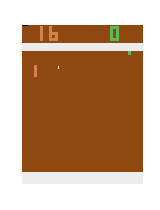
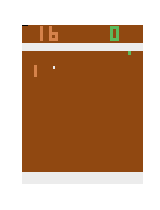
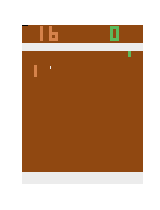
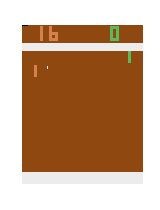
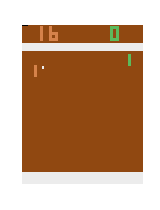
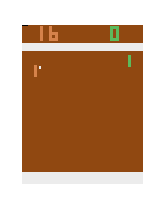
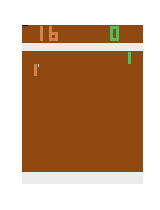
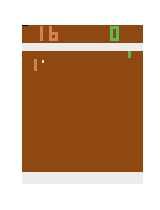
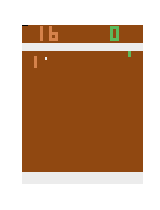
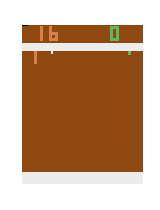
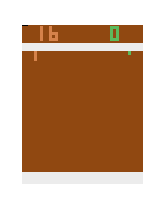
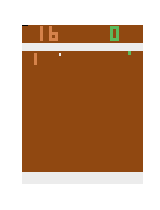
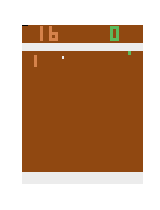
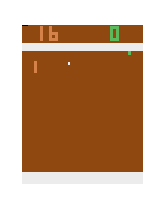
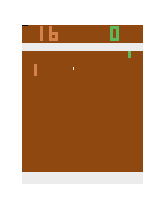
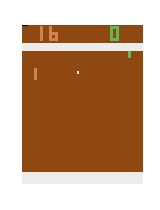
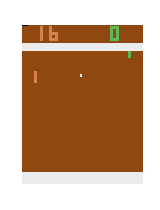
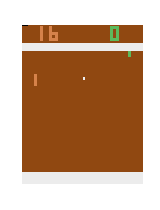
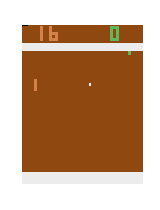
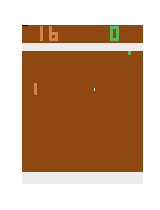
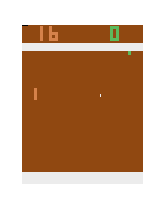
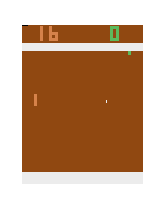
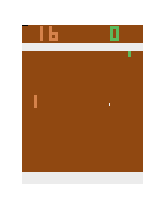
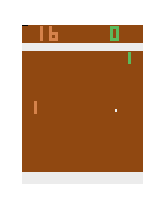
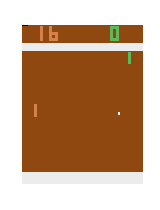
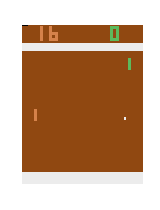
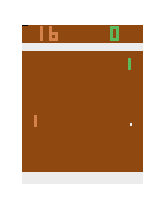
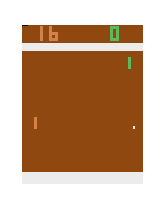
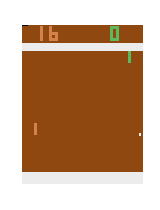
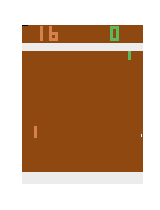
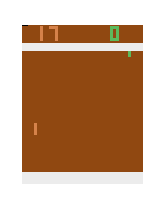
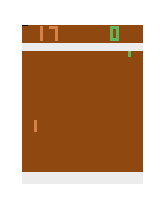
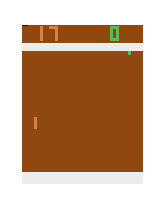
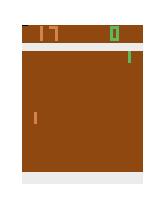
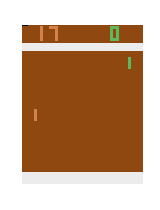
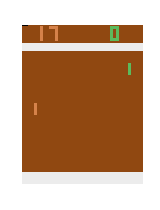
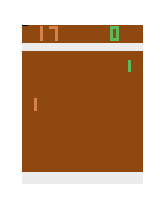
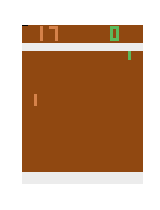
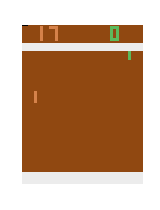
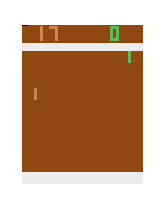
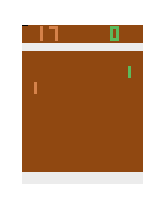
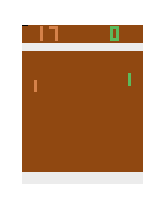
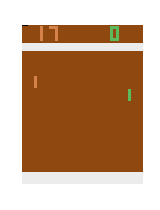
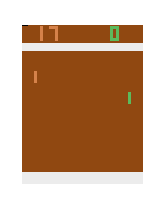
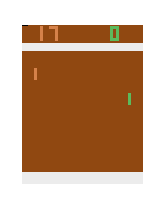
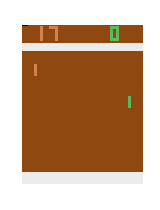
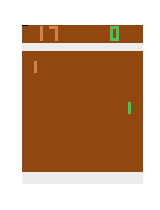
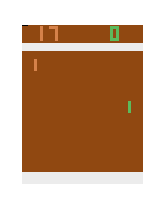
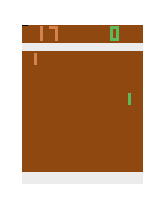
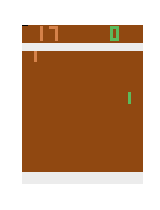
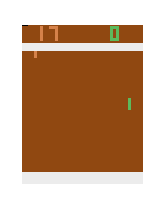
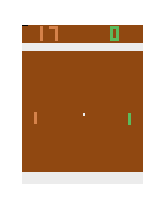
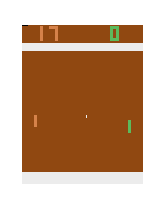
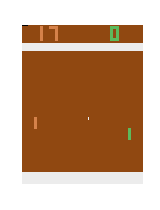
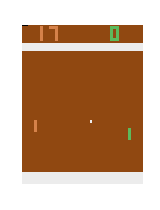
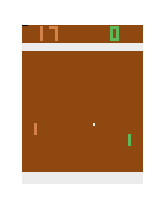
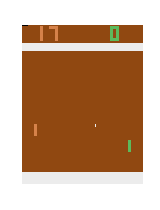
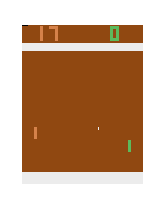
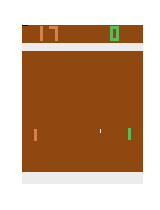
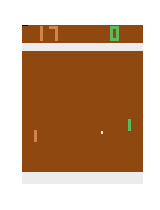
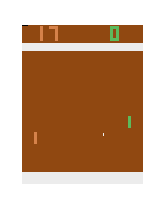
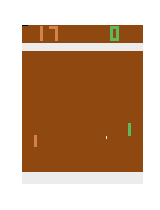
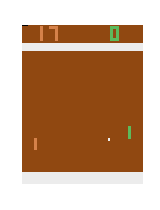
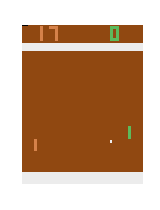
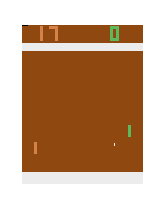
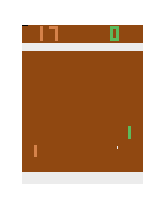
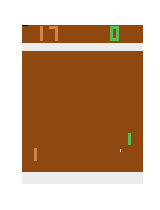
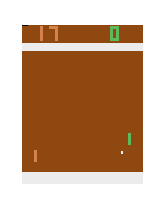
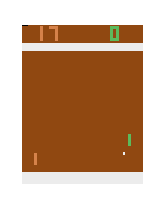
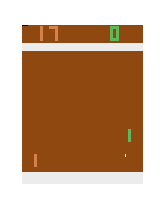
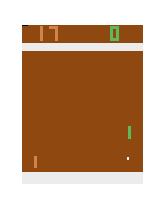
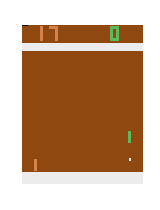
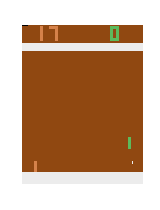
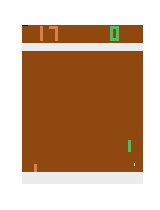
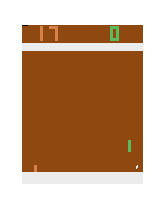
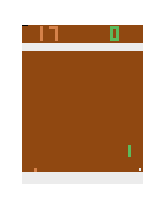
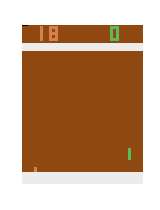
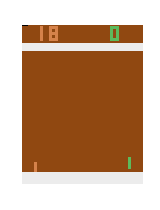
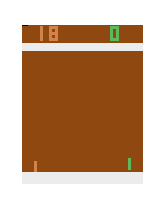
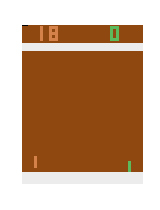
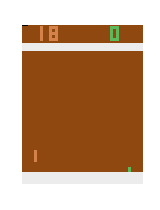
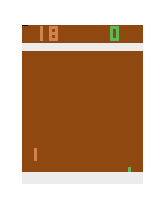
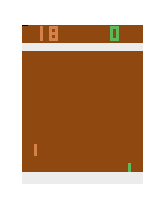
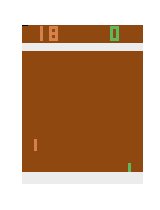
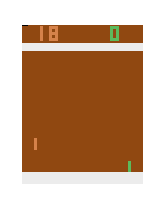
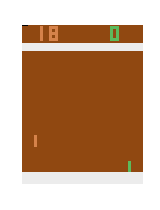
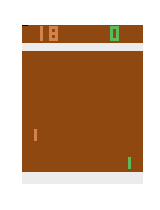
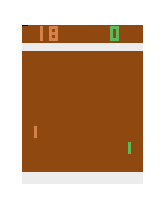
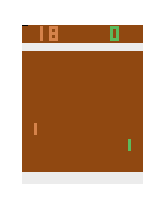
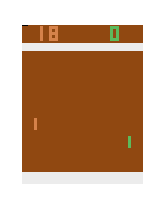
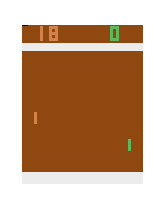
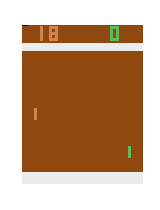
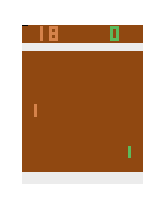
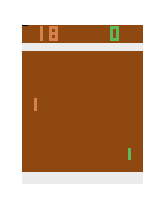
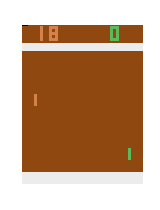
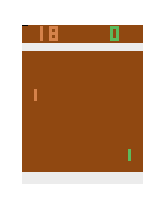
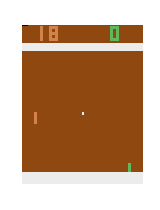
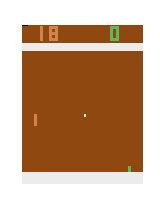
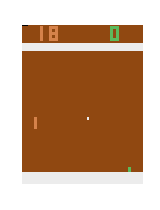
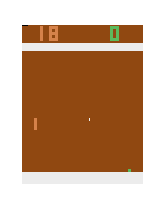
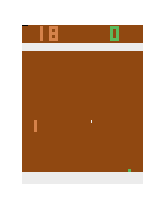
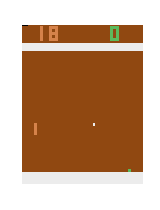
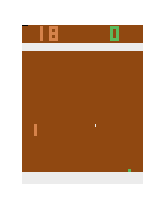
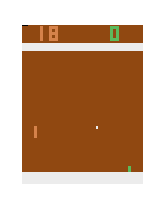
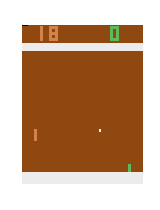
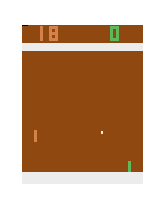
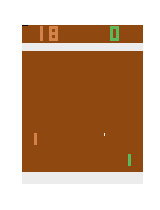
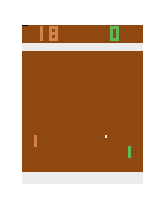
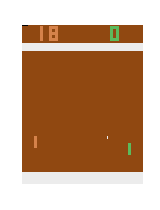
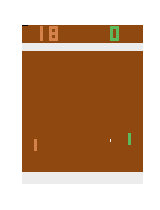
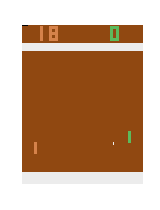
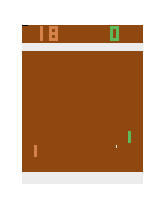
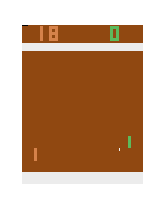
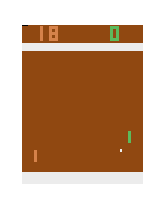
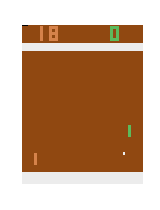
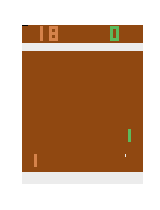
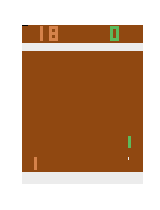
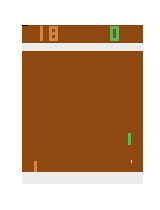
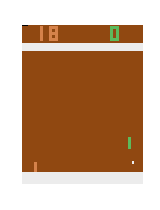
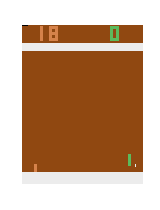
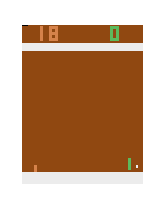
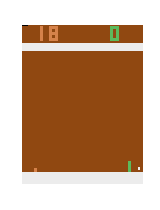
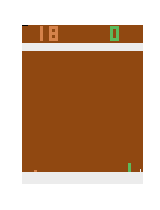
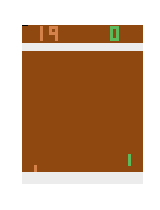
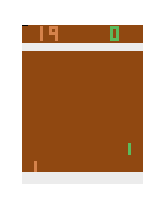
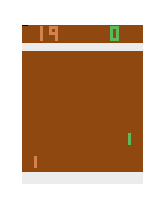
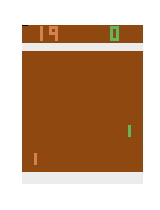
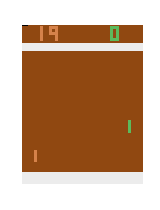
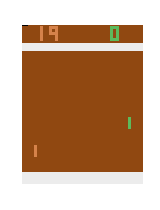
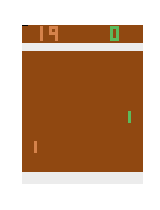
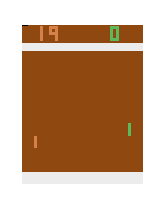
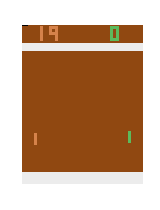
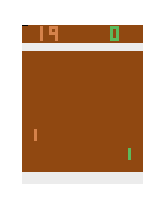
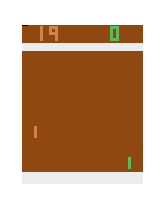
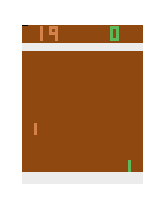
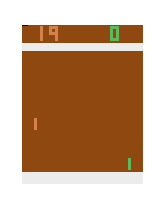
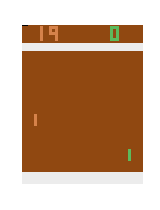
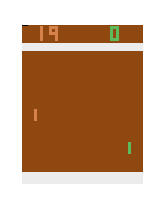
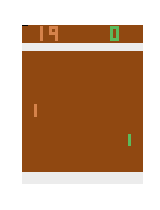
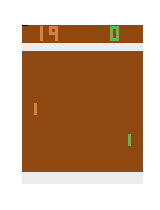
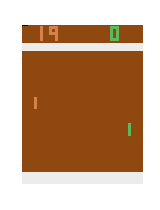
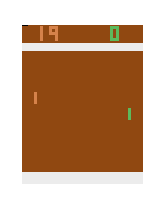
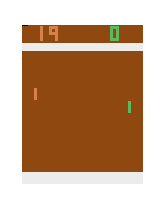
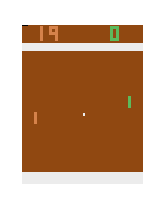
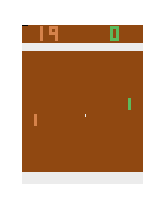
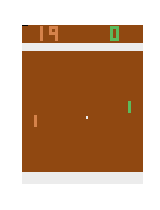
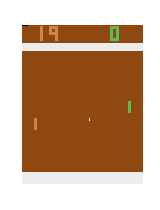
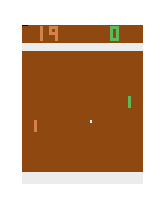
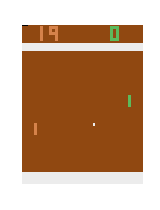
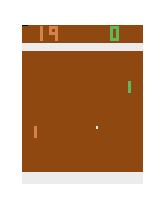
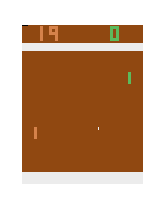
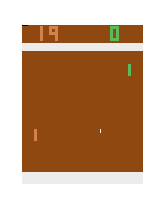
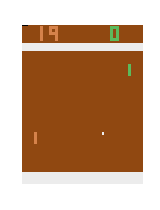
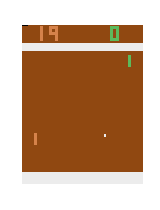
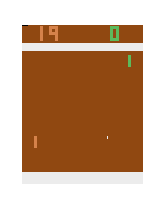
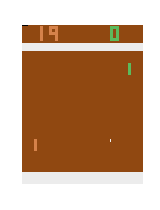
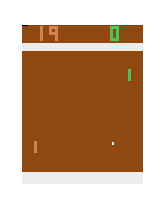
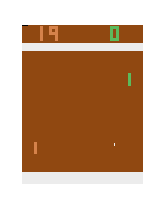
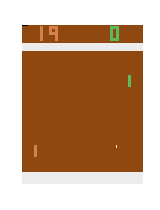
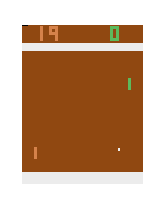
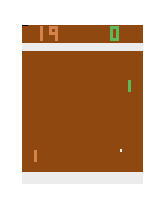
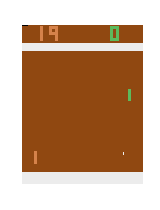
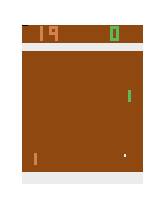
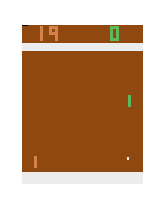
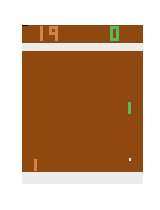
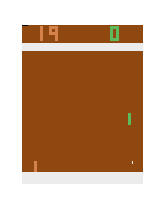
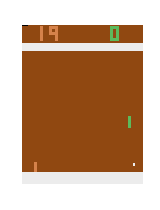
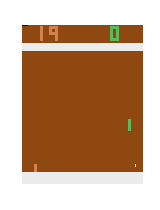
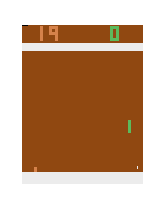
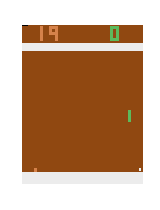
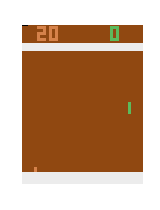
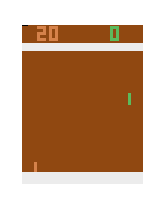
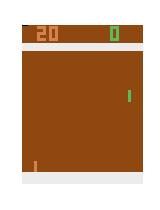
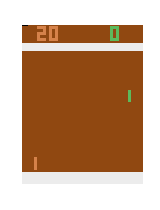
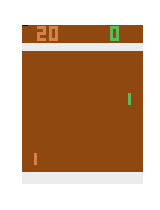
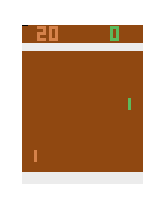
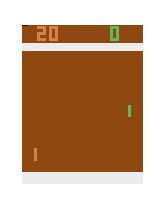
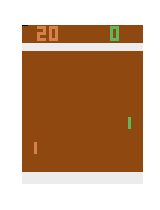
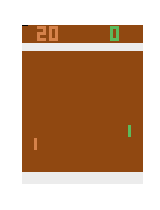
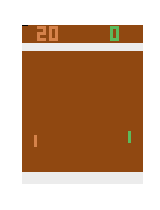
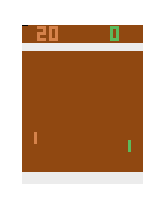
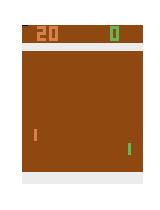
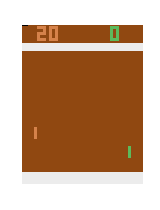
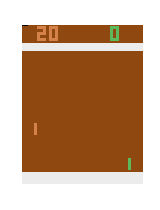
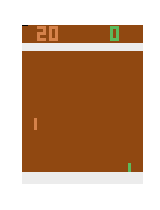
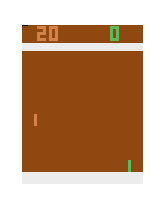
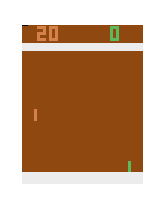
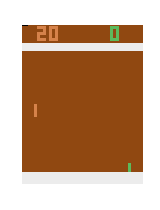
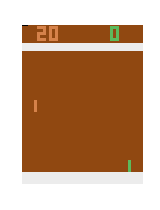
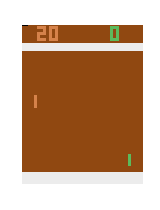
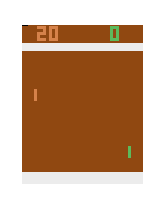
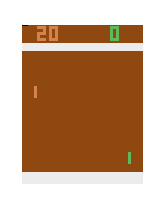
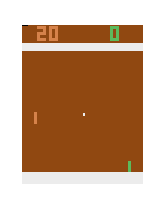
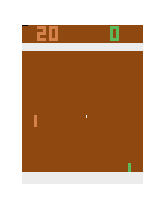
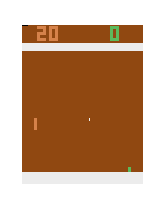
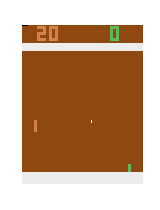
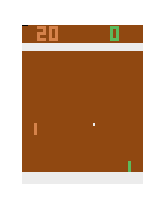
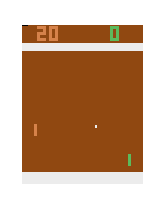
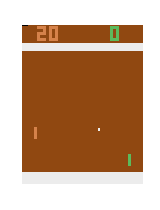
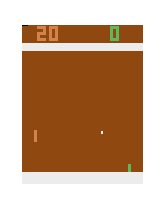
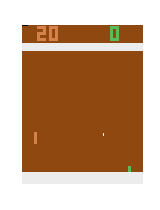
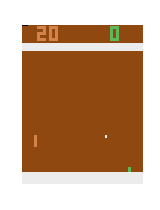
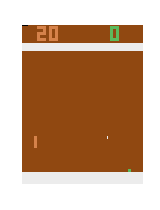
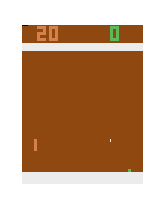
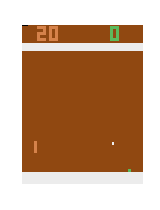
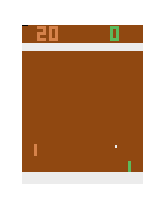
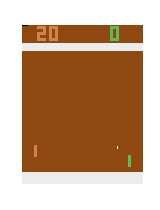
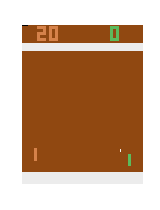
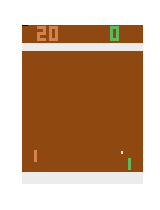
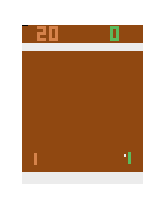
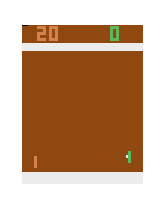
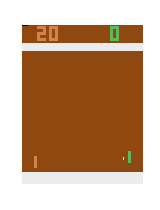
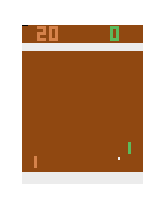
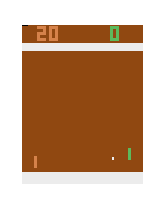
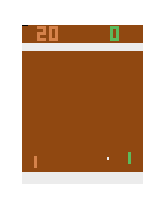
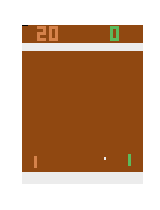
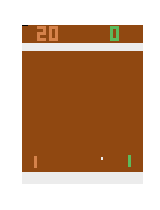
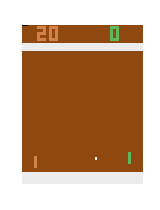
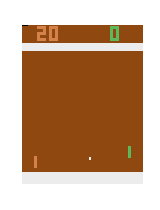
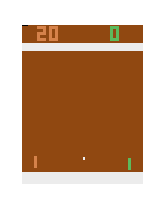
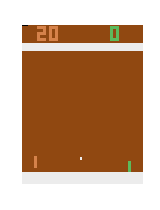
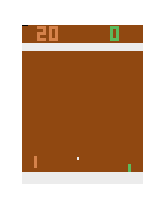
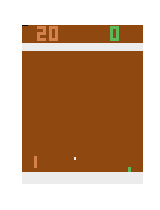
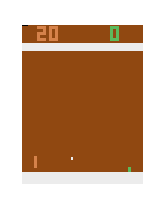
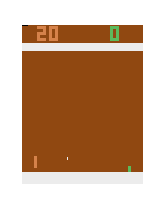
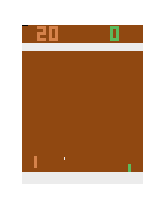
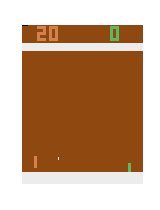
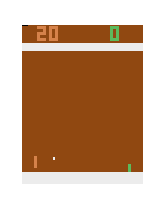
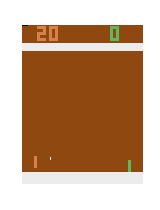
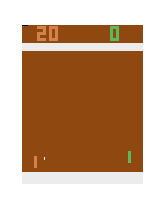
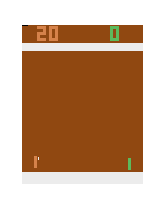
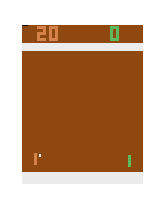
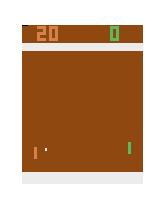
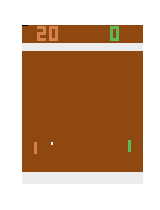
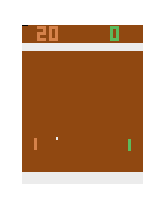
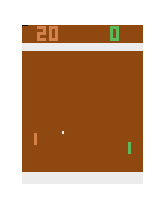
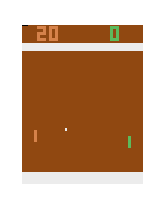
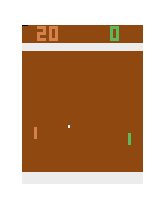
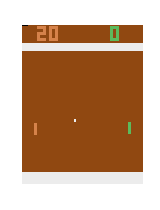
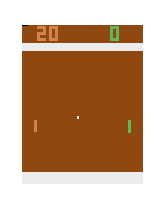
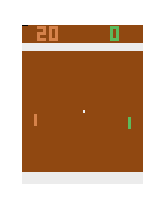
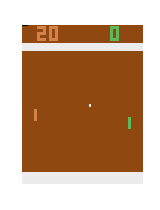
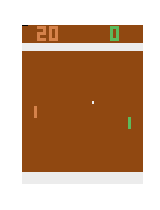
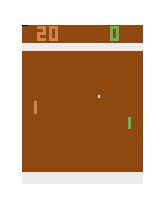
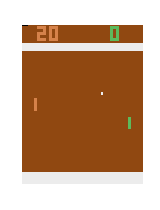
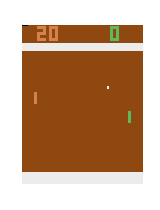
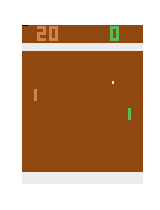
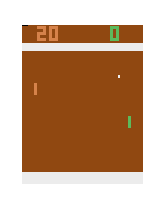
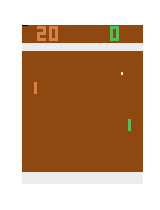
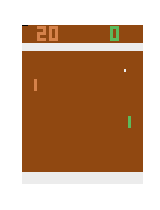
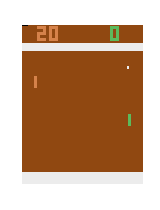
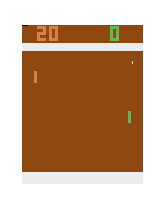
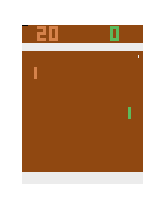

In [16]:
display_frames_as_gif(frames)

In [22]:
while True:
    if render: env.render()
        
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x
    
    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)
    
    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer
                
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print ('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        

resetting env. episode reward total was 3.000000. running mean: 3.000000
resetting env. episode reward total was -10.000000. running mean: 2.870000
resetting env. episode reward total was -2.000000. running mean: 2.821300
resetting env. episode reward total was -9.000000. running mean: 2.703087
resetting env. episode reward total was -1.000000. running mean: 2.666056
resetting env. episode reward total was -1.000000. running mean: 2.629396
resetting env. episode reward total was -8.000000. running mean: 2.523102
resetting env. episode reward total was -10.000000. running mean: 2.397871
resetting env. episode reward total was 1.000000. running mean: 2.383892
resetting env. episode reward total was -11.000000. running mean: 2.250053
resetting env. episode reward total was -12.000000. running mean: 2.107552
resetting env. episode reward total was -9.000000. running mean: 1.996477
resetting env. episode reward total was -13.000000. running mean: 1.846512
resetting env. episode reward total

resetting env. episode reward total was -13.000000. running mean: -3.601337
resetting env. episode reward total was -5.000000. running mean: -3.615324
resetting env. episode reward total was 1.000000. running mean: -3.569171
resetting env. episode reward total was -3.000000. running mean: -3.563479
resetting env. episode reward total was -17.000000. running mean: -3.697844
resetting env. episode reward total was -5.000000. running mean: -3.710866
resetting env. episode reward total was -10.000000. running mean: -3.773757
resetting env. episode reward total was -3.000000. running mean: -3.766020
resetting env. episode reward total was -5.000000. running mean: -3.778359
resetting env. episode reward total was -13.000000. running mean: -3.870576
resetting env. episode reward total was -9.000000. running mean: -3.921870
resetting env. episode reward total was -12.000000. running mean: -4.002651
resetting env. episode reward total was 3.000000. running mean: -3.932625
resetting env. episode

resetting env. episode reward total was -13.000000. running mean: -5.669321
resetting env. episode reward total was -8.000000. running mean: -5.692628
resetting env. episode reward total was -5.000000. running mean: -5.685702
resetting env. episode reward total was -2.000000. running mean: -5.648845
resetting env. episode reward total was 5.000000. running mean: -5.542356
resetting env. episode reward total was -11.000000. running mean: -5.596933
resetting env. episode reward total was -6.000000. running mean: -5.600963
resetting env. episode reward total was -8.000000. running mean: -5.624954
resetting env. episode reward total was 6.000000. running mean: -5.508704
resetting env. episode reward total was -13.000000. running mean: -5.583617
resetting env. episode reward total was -11.000000. running mean: -5.637781
resetting env. episode reward total was 2.000000. running mean: -5.561403
resetting env. episode reward total was -4.000000. running mean: -5.545789
resetting env. episode r

resetting env. episode reward total was -7.000000. running mean: -5.268801
resetting env. episode reward total was -3.000000. running mean: -5.246113
resetting env. episode reward total was -6.000000. running mean: -5.253652
resetting env. episode reward total was 1.000000. running mean: -5.191116
resetting env. episode reward total was 8.000000. running mean: -5.059204
resetting env. episode reward total was -11.000000. running mean: -5.118612
resetting env. episode reward total was -3.000000. running mean: -5.097426
resetting env. episode reward total was -1.000000. running mean: -5.056452
resetting env. episode reward total was 6.000000. running mean: -4.945888
resetting env. episode reward total was 1.000000. running mean: -4.886429
resetting env. episode reward total was -9.000000. running mean: -4.927564
resetting env. episode reward total was 5.000000. running mean: -4.828289
resetting env. episode reward total was -12.000000. running mean: -4.900006
resetting env. episode rewar

resetting env. episode reward total was -11.000000. running mean: -4.196187
resetting env. episode reward total was -13.000000. running mean: -4.284225
resetting env. episode reward total was -3.000000. running mean: -4.271383
resetting env. episode reward total was 2.000000. running mean: -4.208669
resetting env. episode reward total was -11.000000. running mean: -4.276583
resetting env. episode reward total was -6.000000. running mean: -4.293817
resetting env. episode reward total was -2.000000. running mean: -4.270879
resetting env. episode reward total was -8.000000. running mean: -4.308170
resetting env. episode reward total was -9.000000. running mean: -4.355088
resetting env. episode reward total was 10.000000. running mean: -4.211537
resetting env. episode reward total was -8.000000. running mean: -4.249422
resetting env. episode reward total was -1.000000. running mean: -4.216928
resetting env. episode reward total was -2.000000. running mean: -4.194758
resetting env. episode 

resetting env. episode reward total was -5.000000. running mean: -3.223561
resetting env. episode reward total was -9.000000. running mean: -3.281326
resetting env. episode reward total was -7.000000. running mean: -3.318512
resetting env. episode reward total was -4.000000. running mean: -3.325327
resetting env. episode reward total was -1.000000. running mean: -3.302074
resetting env. episode reward total was 3.000000. running mean: -3.239053
resetting env. episode reward total was 5.000000. running mean: -3.156663
resetting env. episode reward total was -7.000000. running mean: -3.195096
resetting env. episode reward total was -5.000000. running mean: -3.213145
resetting env. episode reward total was -2.000000. running mean: -3.201014
resetting env. episode reward total was -3.000000. running mean: -3.199004
resetting env. episode reward total was -6.000000. running mean: -3.227013
resetting env. episode reward total was -6.000000. running mean: -3.254743
resetting env. episode rewa

resetting env. episode reward total was -6.000000. running mean: -4.343117
resetting env. episode reward total was -7.000000. running mean: -4.369686
resetting env. episode reward total was -16.000000. running mean: -4.485989
resetting env. episode reward total was -8.000000. running mean: -4.521129
resetting env. episode reward total was -7.000000. running mean: -4.545918
resetting env. episode reward total was 2.000000. running mean: -4.480458
resetting env. episode reward total was -5.000000. running mean: -4.485654
resetting env. episode reward total was -9.000000. running mean: -4.530797
resetting env. episode reward total was -3.000000. running mean: -4.515489
resetting env. episode reward total was -7.000000. running mean: -4.540334
resetting env. episode reward total was -9.000000. running mean: -4.584931
resetting env. episode reward total was -12.000000. running mean: -4.659082
resetting env. episode reward total was -9.000000. running mean: -4.702491
resetting env. episode r

resetting env. episode reward total was 1.000000. running mean: -4.098078
resetting env. episode reward total was 7.000000. running mean: -3.987097
resetting env. episode reward total was -11.000000. running mean: -4.057226
resetting env. episode reward total was -7.000000. running mean: -4.086654
resetting env. episode reward total was -7.000000. running mean: -4.115787
resetting env. episode reward total was 1.000000. running mean: -4.064629
resetting env. episode reward total was -7.000000. running mean: -4.093983
resetting env. episode reward total was -10.000000. running mean: -4.153043
resetting env. episode reward total was -2.000000. running mean: -4.131513
resetting env. episode reward total was -6.000000. running mean: -4.150198
resetting env. episode reward total was 1.000000. running mean: -4.098696
resetting env. episode reward total was -4.000000. running mean: -4.097709
resetting env. episode reward total was -7.000000. running mean: -4.126732
resetting env. episode rewa

KeyboardInterrupt: 

In [23]:
print(model)

{'W1': array([[ 0.01020312,  0.00940123,  0.01736792, ..., -0.0372158 ,
        -0.0102619 , -0.01550812],
       [ 0.0371244 , -0.00946859,  0.0327486 , ..., -0.00653782,
         0.01164097, -0.00988014],
       [-0.01542115,  0.00620013,  0.05283725, ..., -0.00614674,
         0.00749011, -0.02074656],
       ..., 
       [ 0.00488293, -0.01312965, -0.0024317 , ...,  0.07066676,
        -0.05113185,  0.01554254],
       [ 0.01792279,  0.01861855, -0.04135884, ...,  0.07725468,
        -0.02398296, -0.01341031],
       [ 0.01041058,  0.00259668, -0.02456302, ...,  0.03176902,
        -0.01350606, -0.00211531]]), 'W2': array([-0.24125274, -0.22363573, -0.26758143, -0.38944034, -0.29088582,
       -0.37562654,  0.20460747, -0.19392115, -0.19157236, -0.1592886 ,
        0.1772515 ,  0.23832535,  0.23188538, -0.2392008 , -0.31055255,
        0.23693662, -0.22294391, -0.26635386,  0.26164001,  0.19529295,
        0.25539319, -0.25251236, -0.18760394,  0.2286462 ,  0.16612485,
        0.22

### Agent plays pong after 12 hours of training. It can defend itself and score very well now :)

In [24]:
#model = pickle.load(open("save.p", "rb"))
pickle.dump(model, open('save.p', 'wb'))

In [25]:
env = gym.make('Pong-v0')
observation = env.reset()
cum_reward = 0
frames = []
for t in range(2000):
    frames.append(env.render(mode='rgb_array'))

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x
    
    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!


    observation, reward, done, info = env.step(action)
    
    if done:
        break
env.render(close=True)

[2017-07-10 09:38:22,664] Making new env: Pong-v0



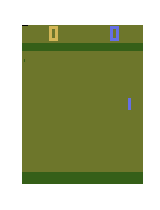
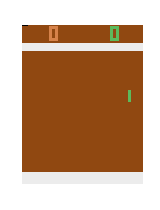
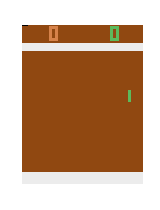
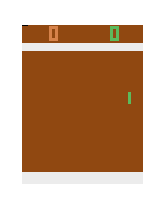
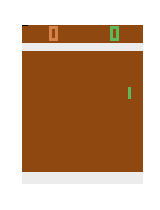
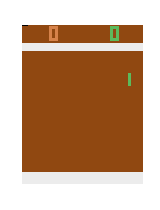
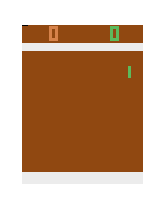
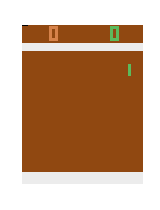
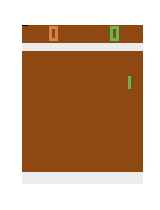
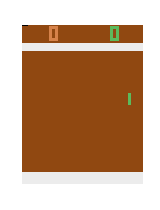
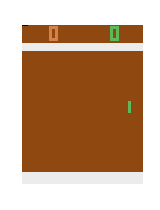
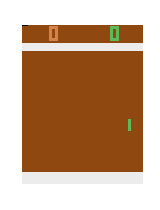
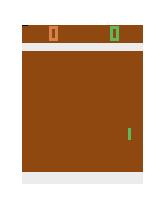
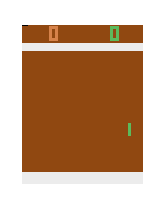
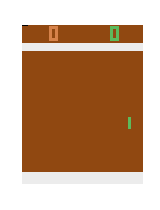
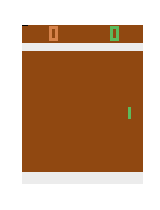
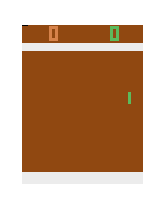
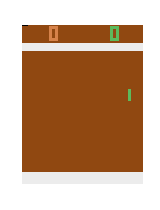
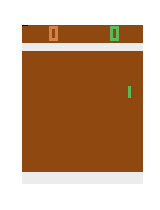
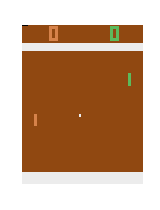
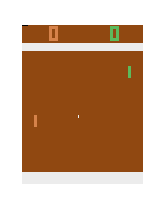
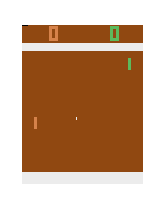
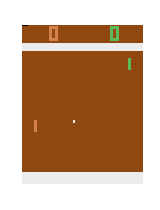
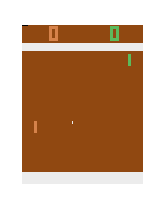
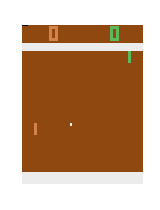
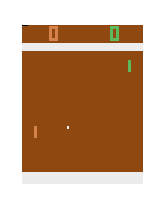
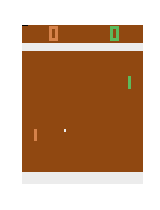
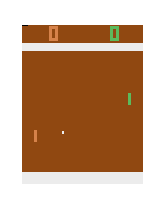
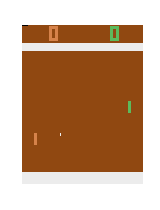
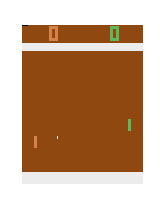
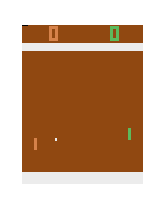
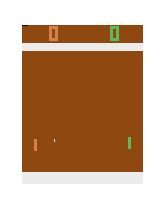
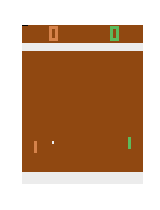
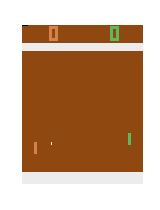
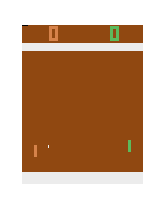
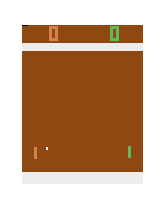
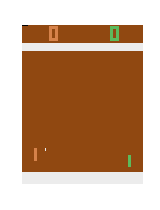
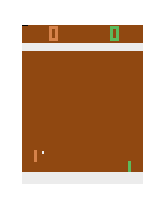
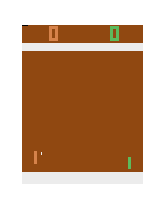
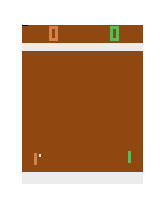
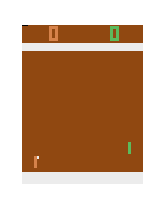
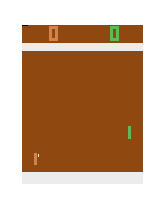
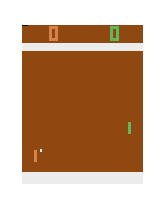
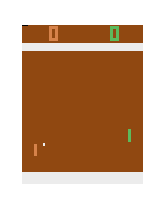
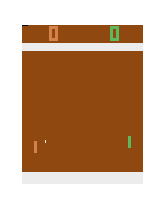
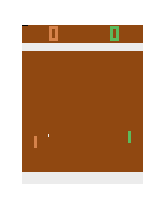
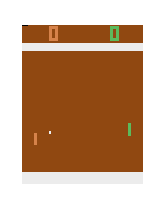
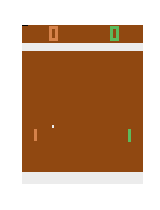
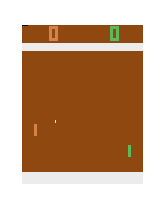
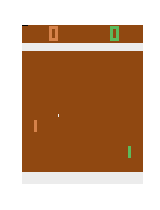
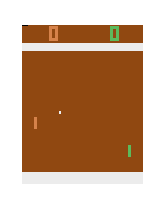
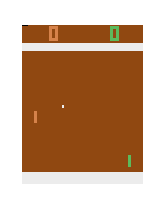
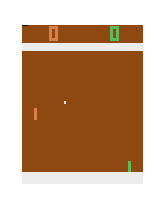
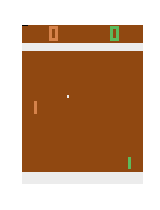
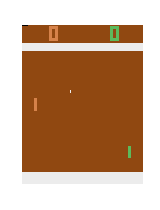
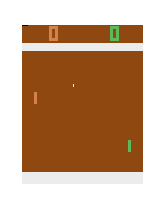
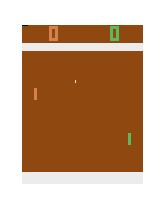
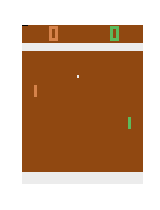
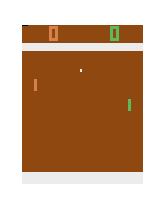
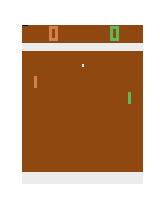
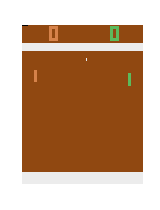
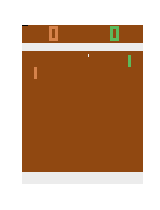
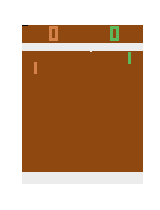
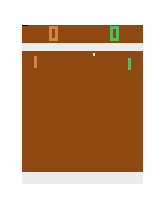
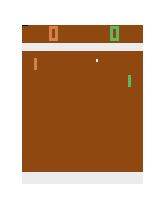
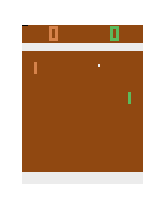
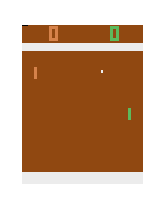
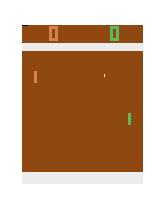
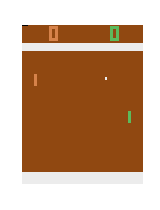
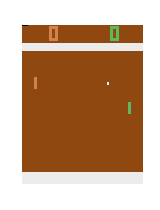
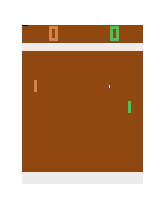
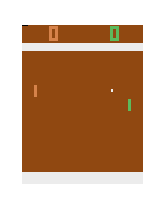
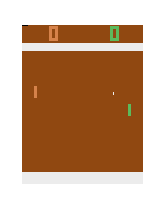
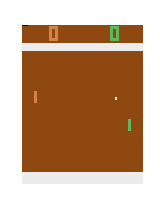
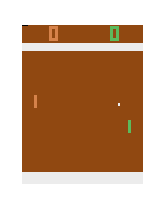
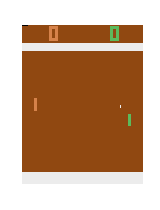
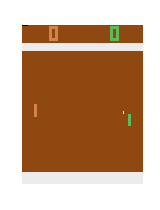
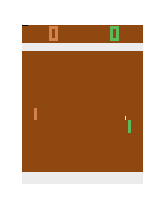
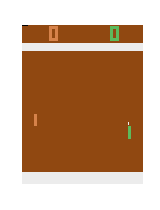
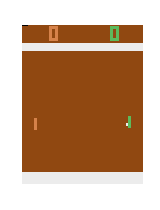
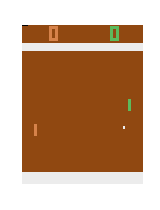
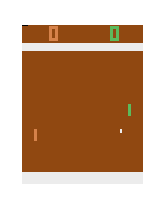
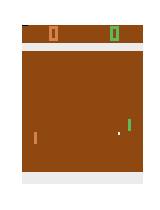
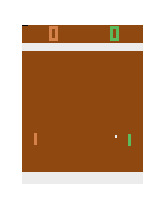
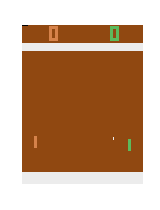
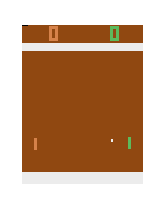
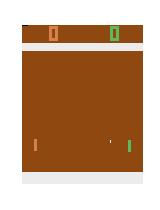
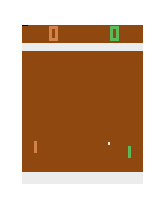
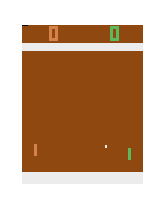
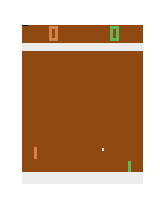
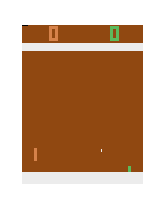
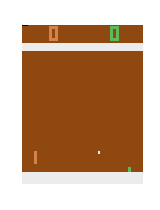
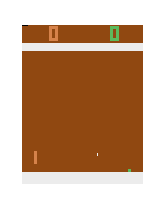
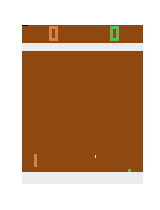
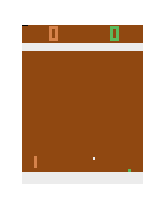
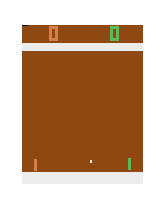
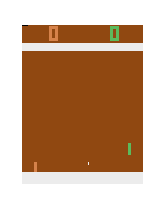
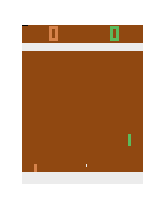
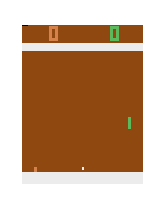
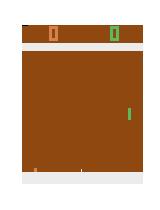
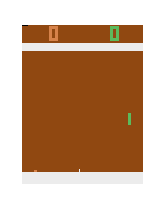
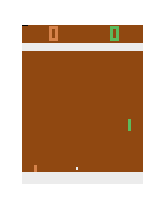
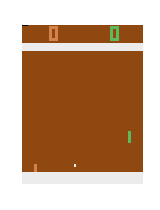
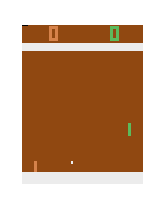
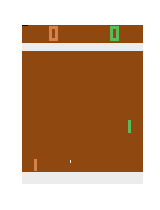
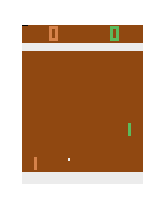
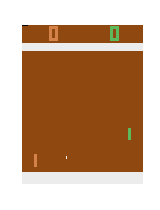
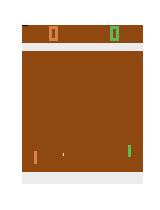
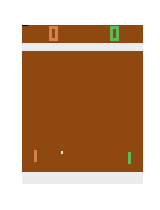
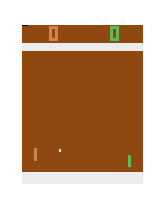
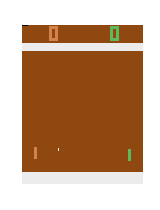
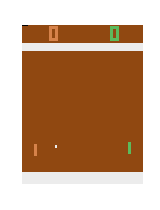
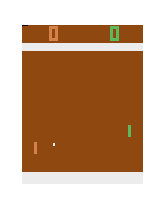
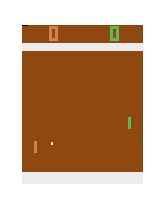
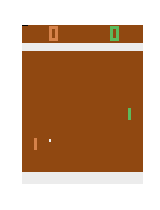
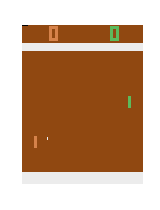
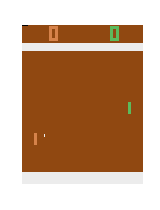
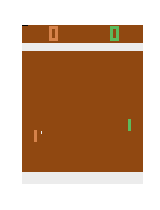
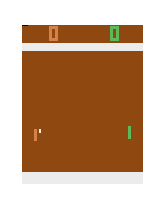
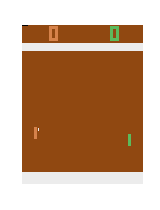
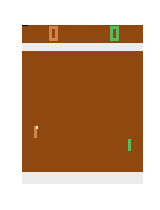
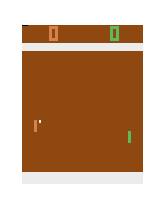
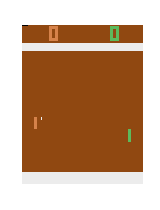
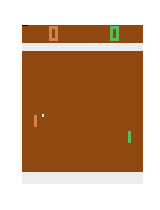
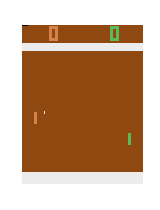
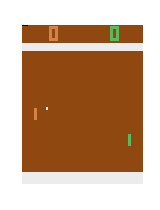
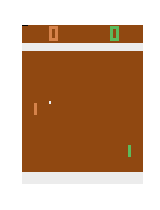
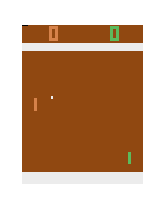
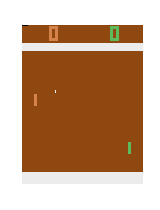
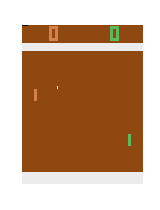
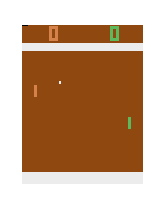
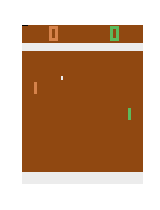
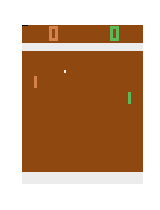
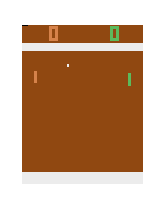
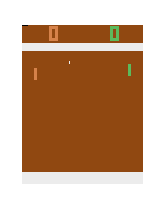
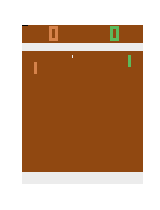
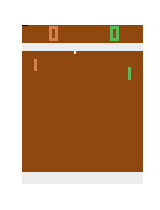
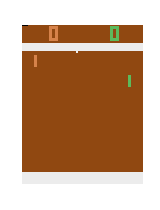
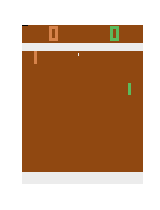
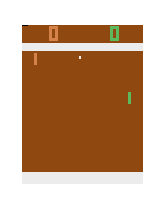
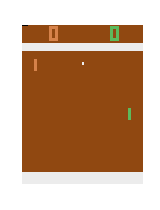
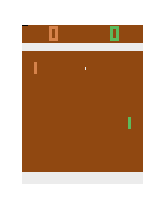
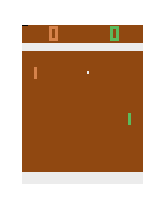
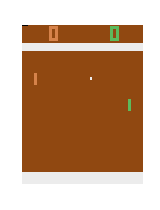
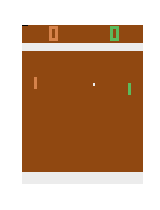
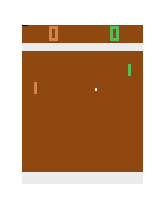
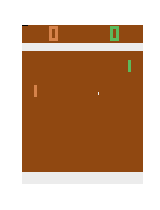
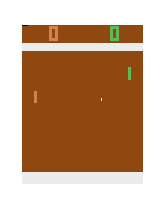
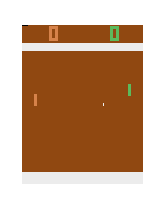
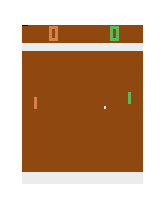
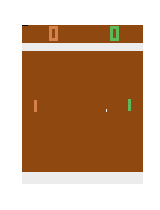
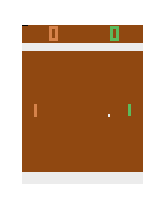
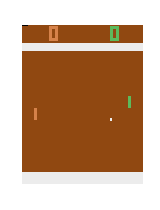
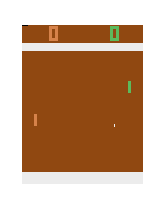
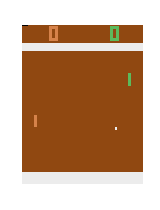
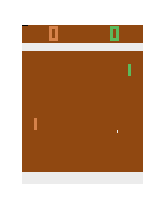
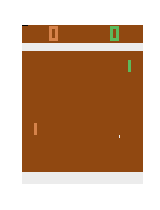
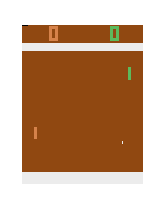
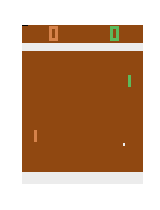
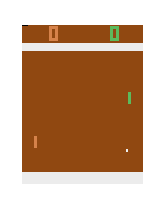
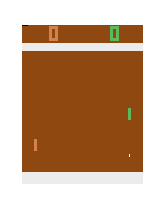
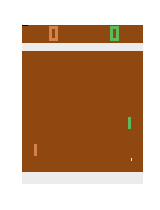
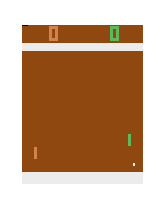
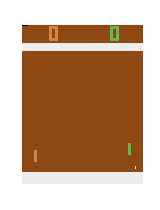
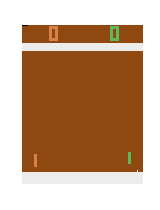
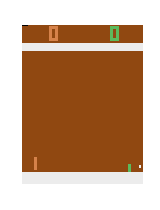
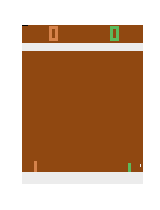
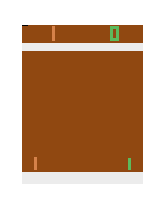
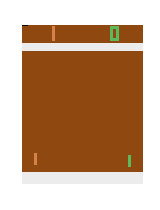
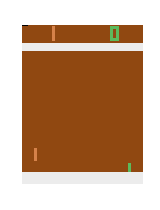
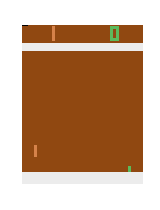
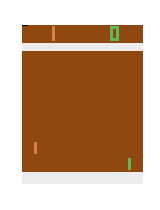
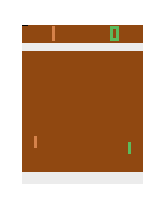
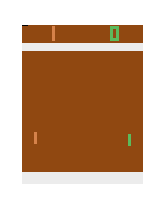
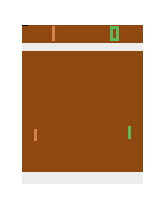
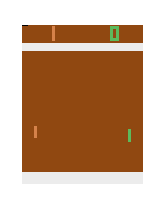
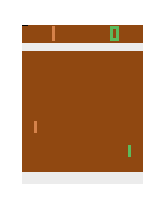
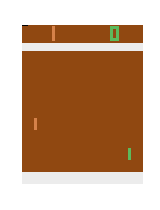
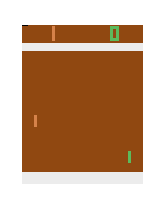
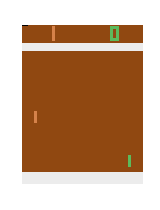
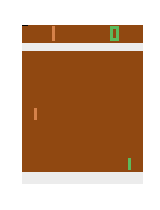
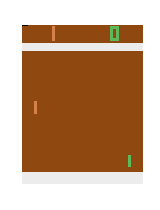
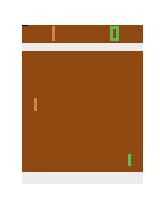
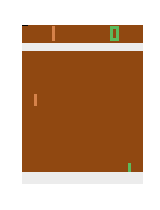
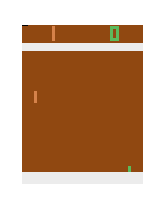
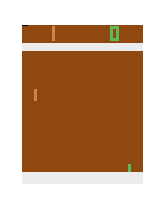
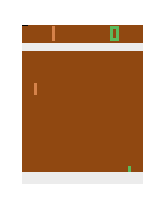
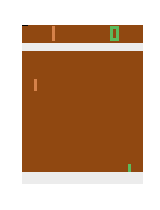
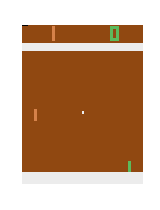
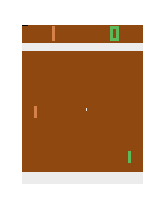
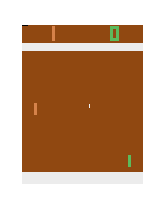
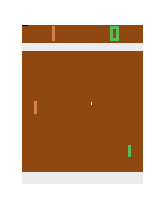
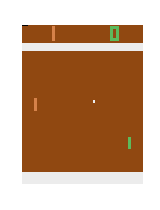
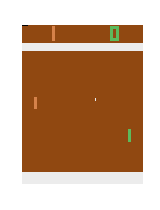
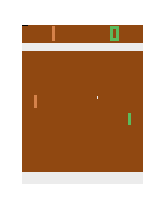
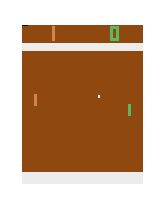
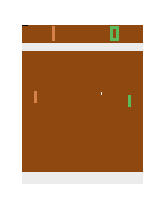
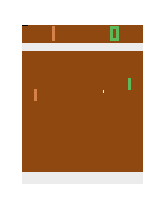
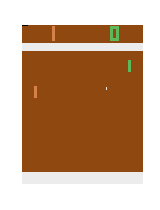
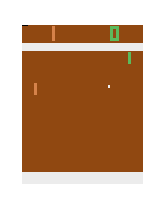
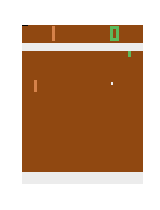
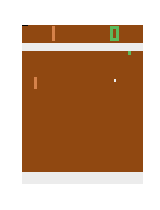
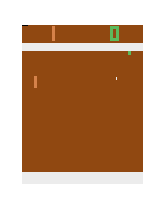
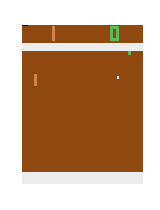
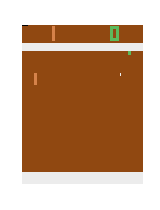
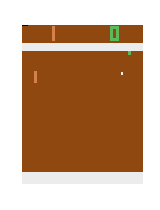
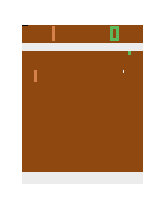
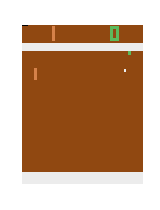
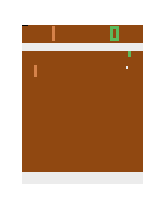
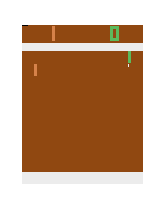
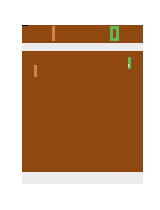
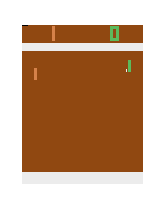
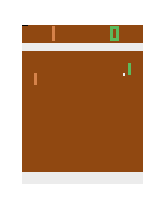
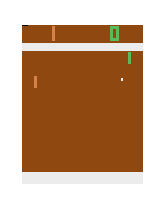
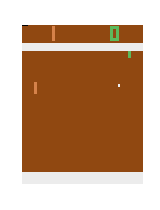
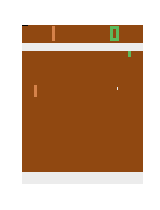
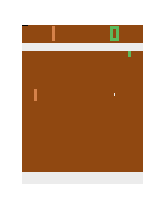
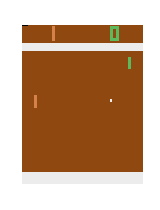
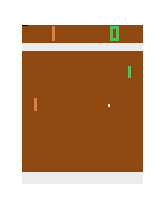
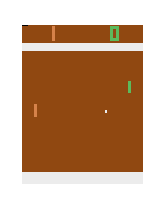
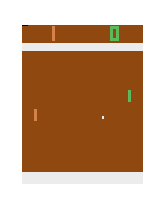
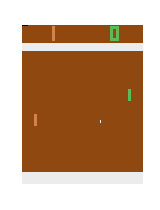
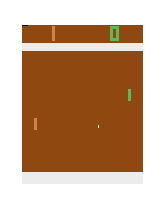
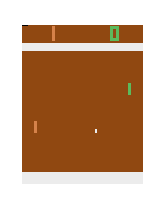
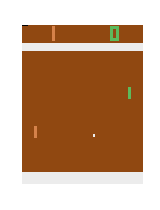
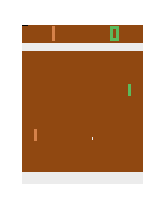
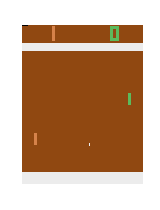
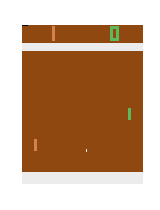
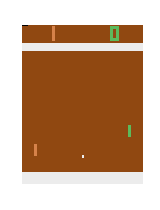
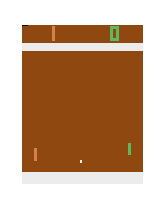
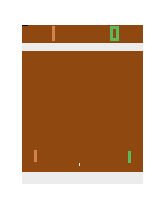
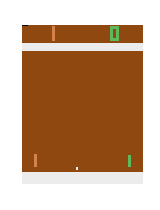
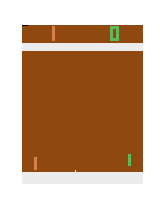
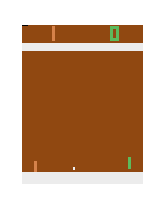
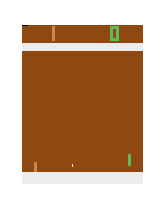
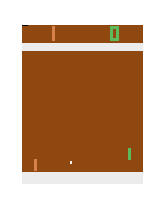
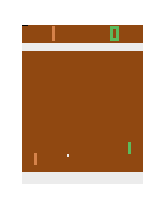
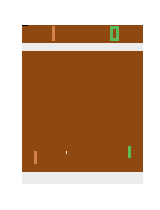
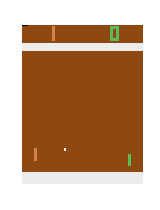
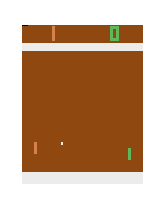
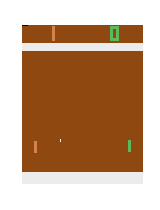
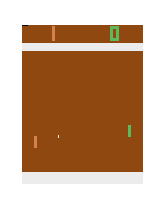
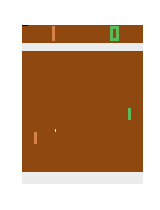
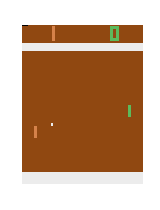
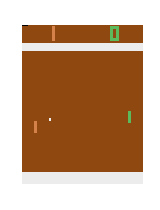
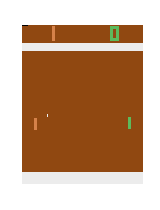
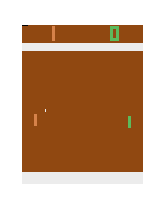
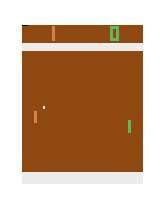
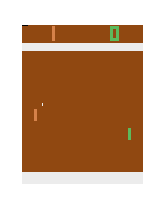
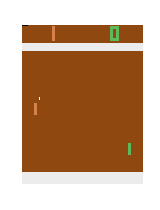
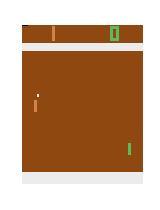
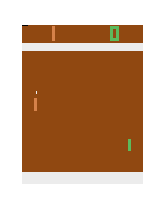
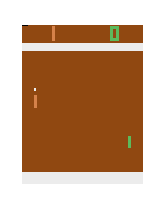
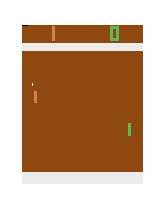
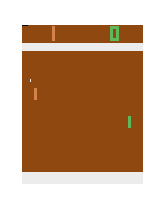
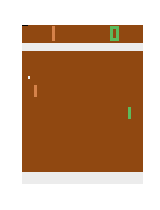
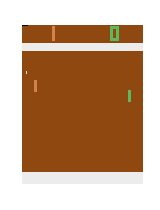
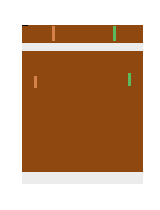
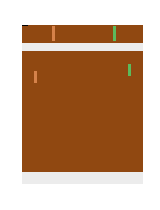
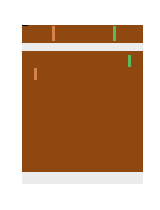
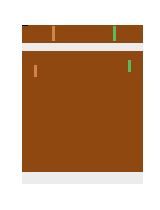
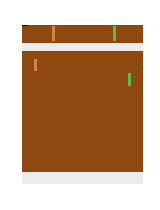
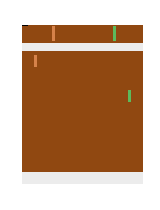
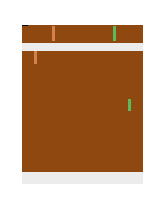
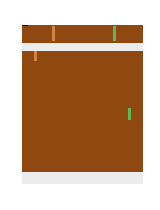
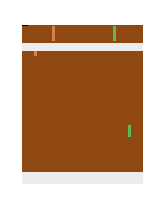
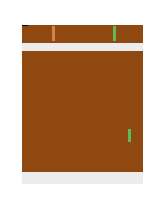
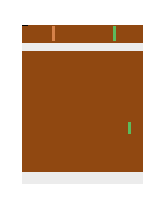
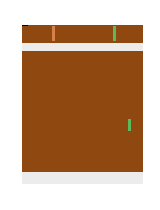
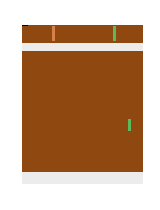
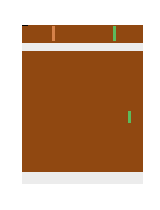
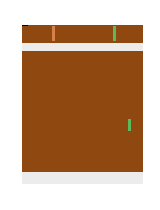
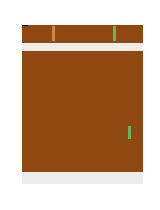
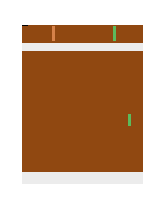
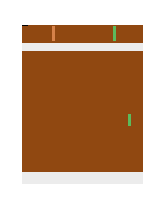
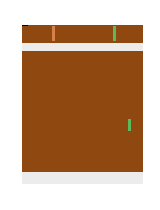
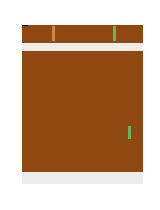
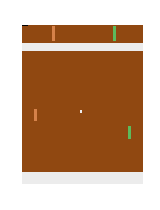
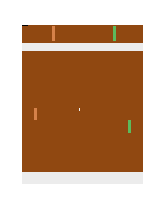
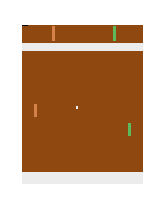
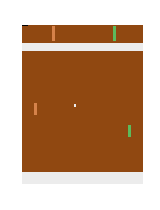
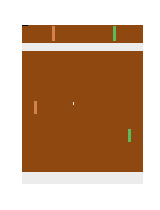
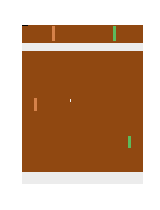
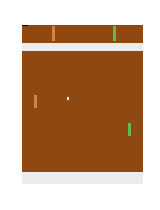
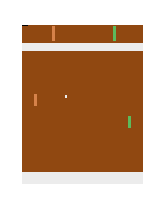
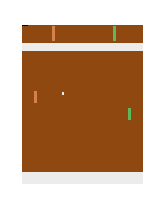
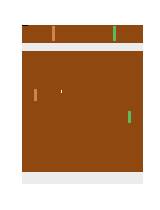
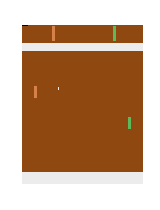
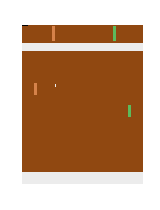
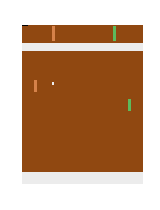
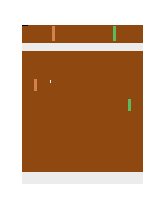
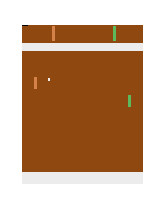
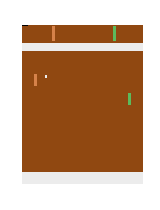
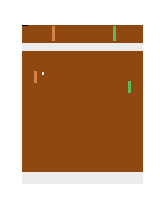
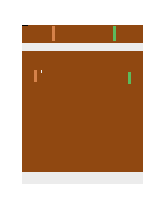
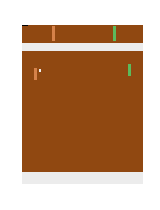
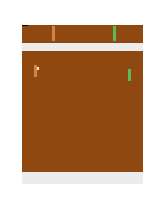
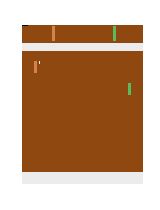
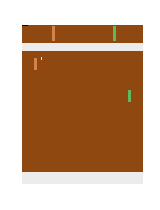
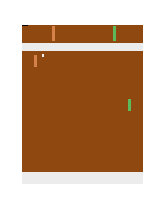
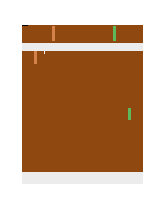
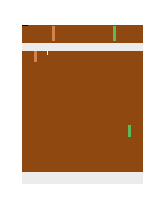
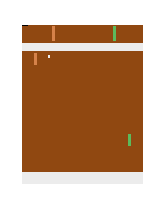
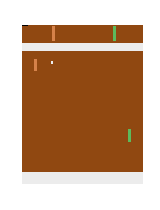
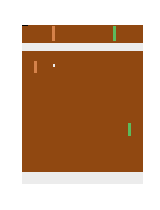
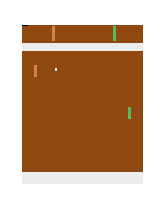
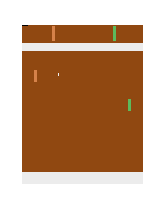
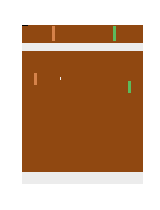
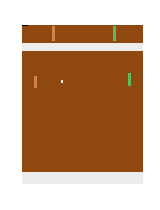
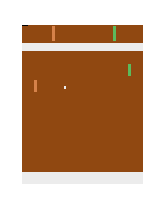
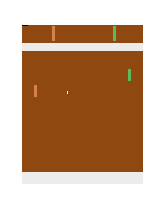
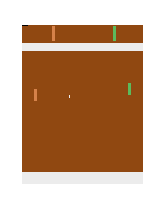
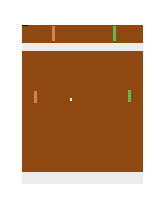
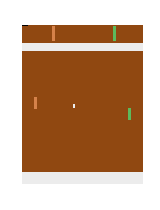
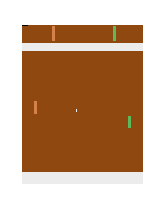
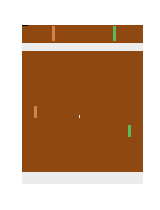
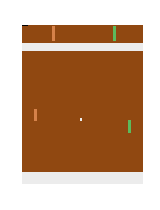
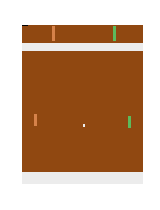
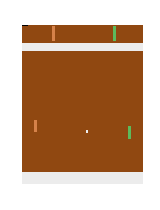
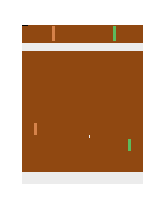
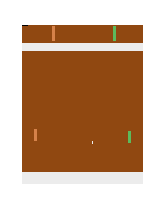
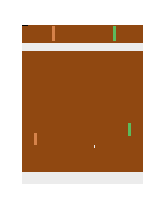
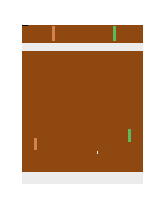
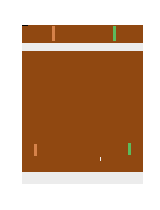
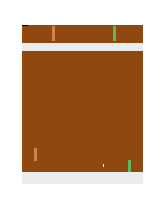
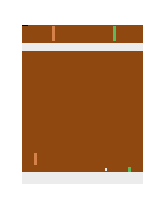
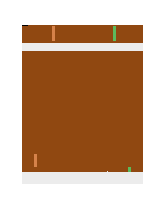
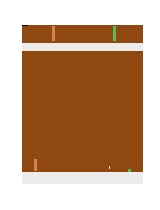
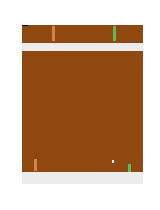
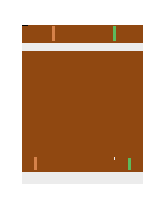
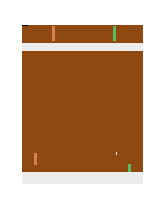
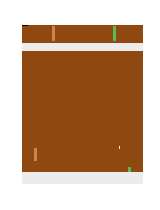
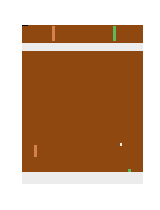
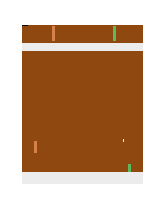
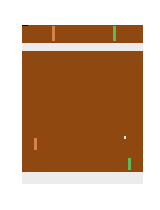
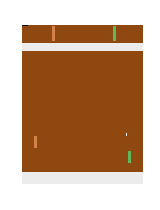
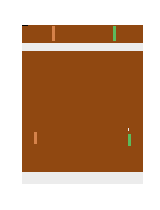
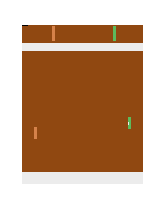
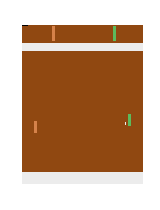
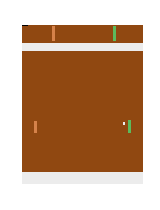
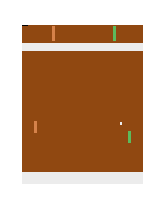
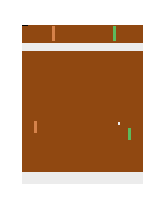
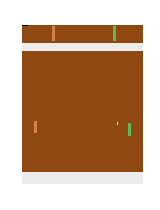
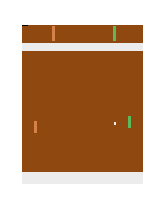
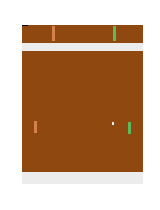
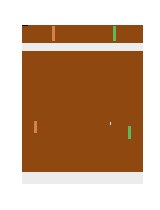
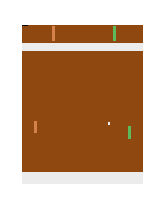
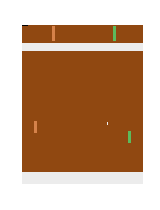
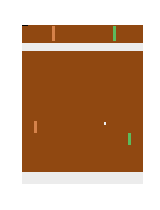
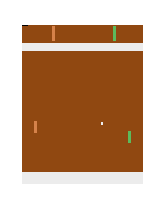
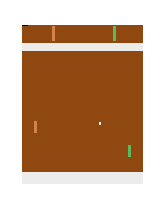
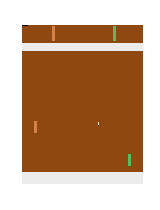
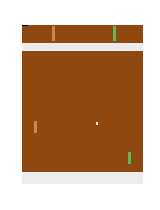
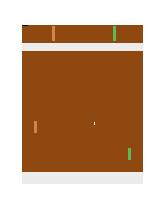
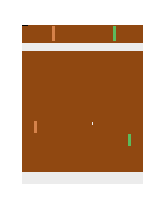
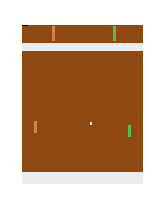
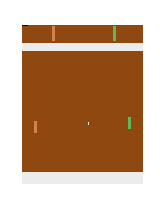
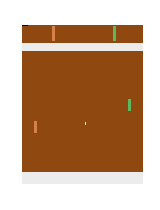
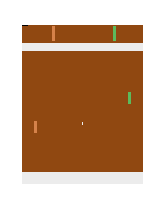
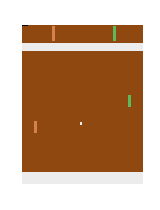
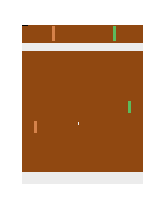
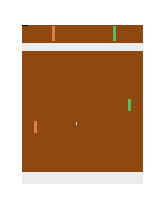
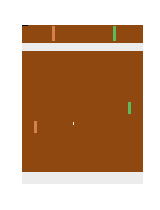
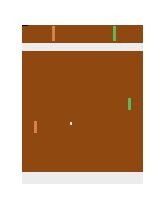
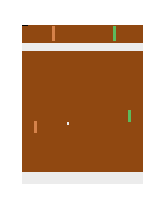
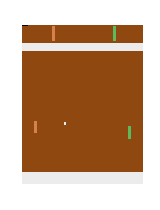
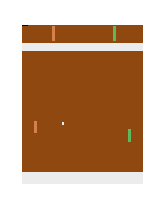
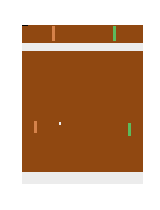
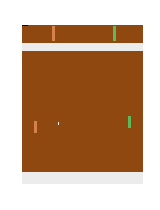
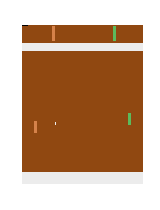
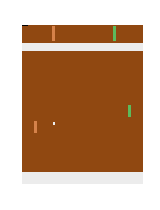
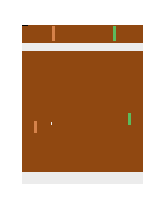
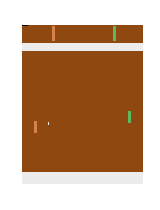
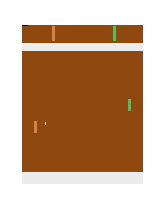
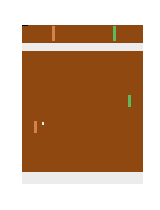
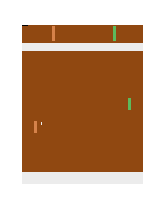
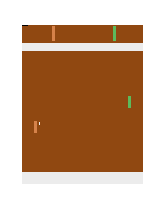
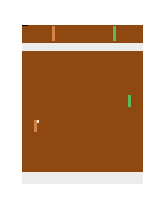
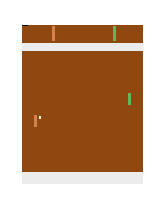
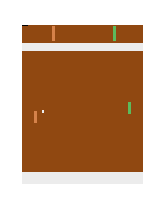
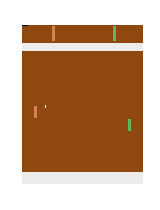
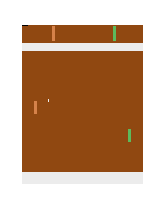
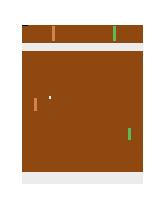
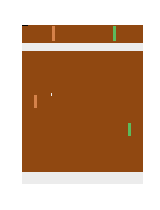
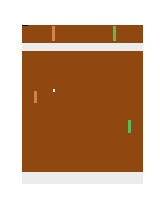
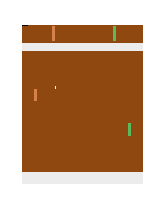
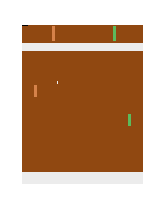
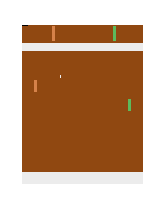
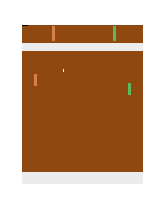
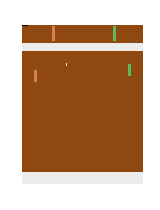
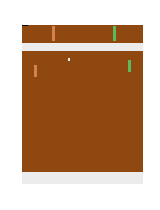
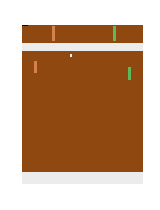
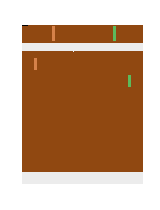
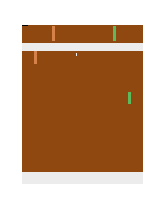
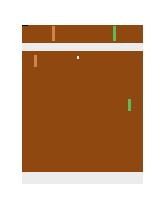
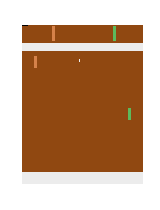
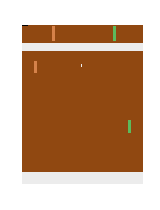
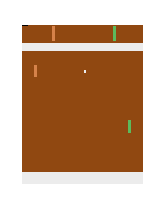
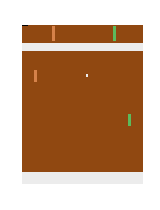
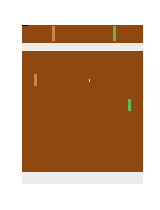
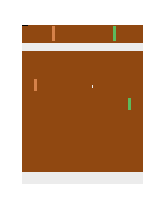
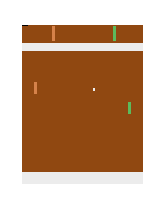
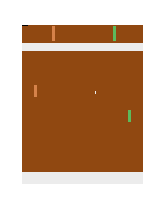
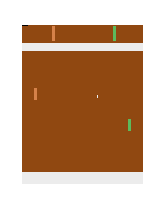
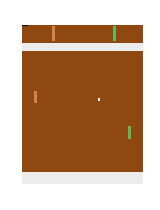
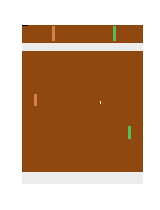
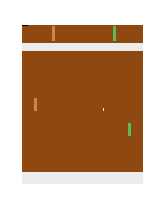
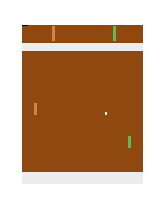
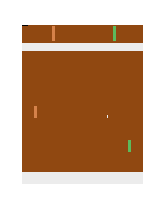
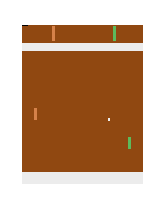
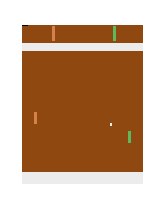
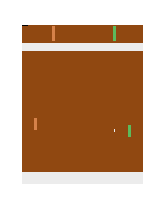
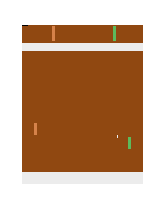
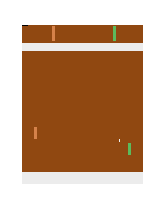
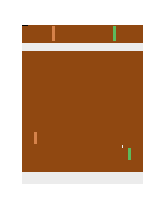
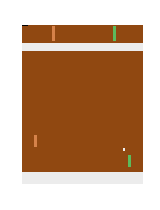
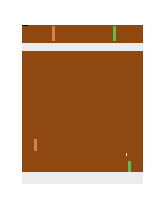
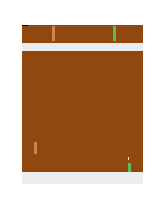
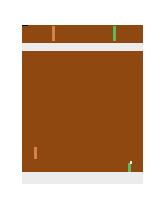
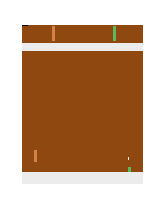
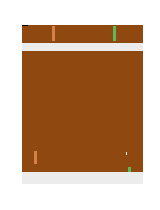
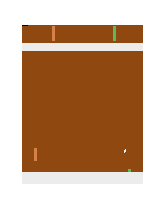
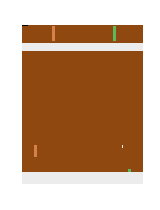
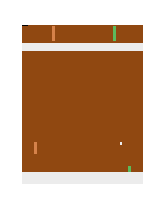
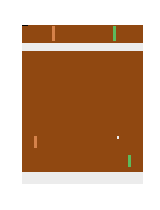
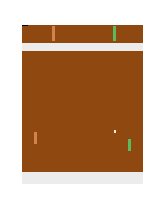
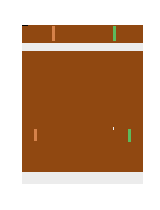
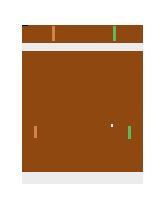
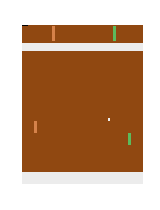
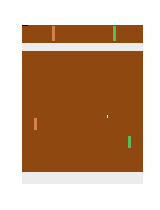
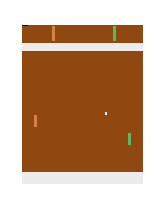
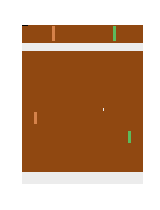
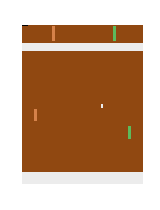
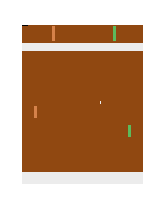
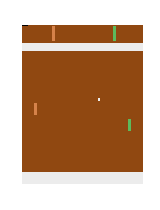
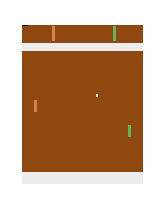
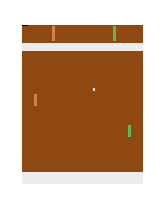
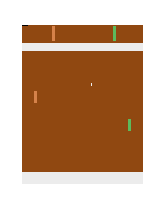
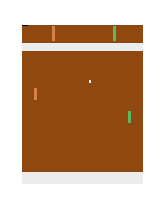
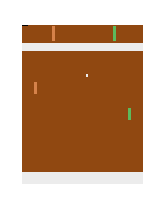
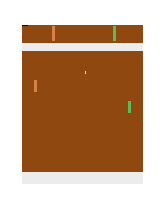
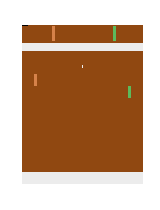
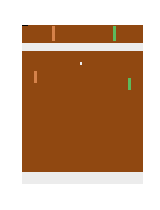
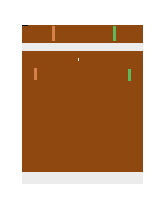
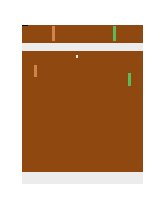
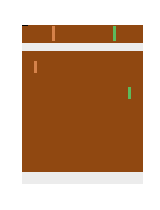
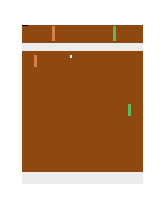
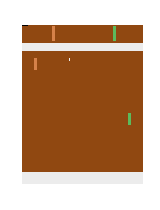
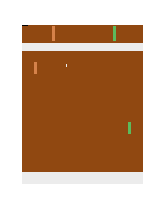
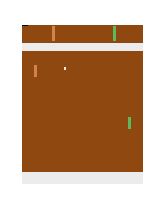
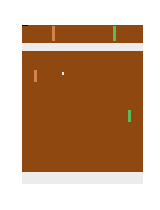
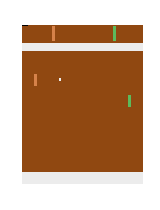
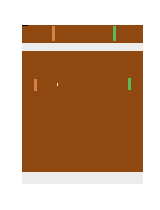
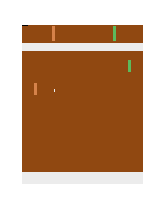
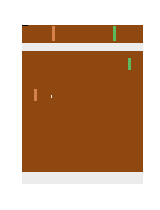
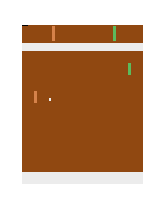
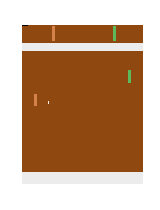
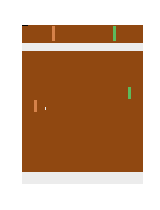
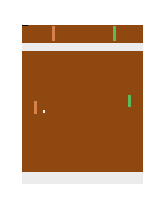
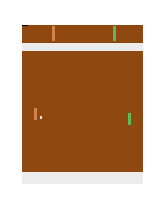
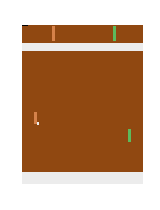
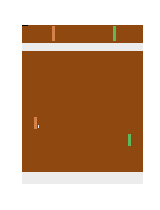
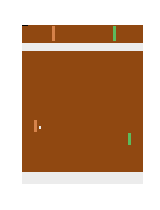
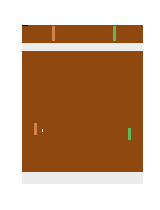
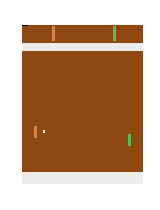
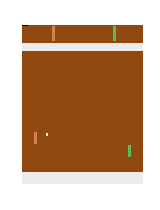
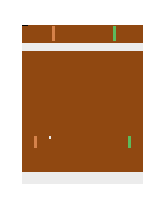
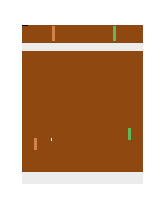
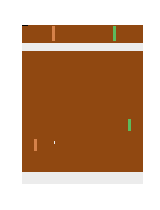
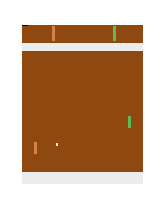
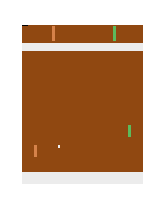
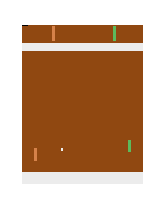
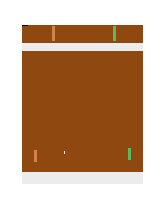
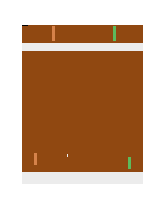
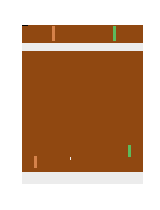
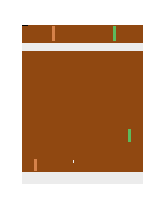
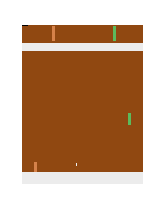
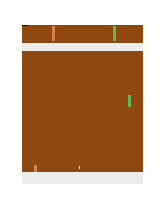
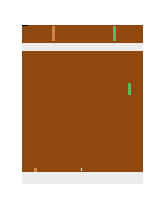
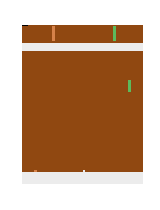
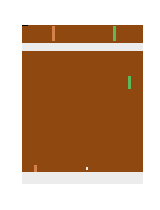
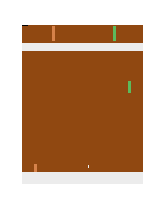
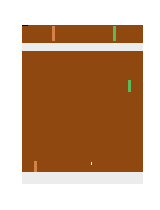
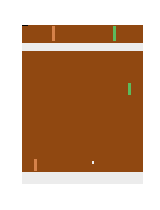
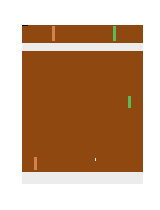
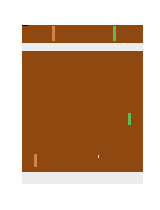
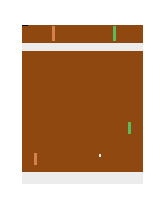
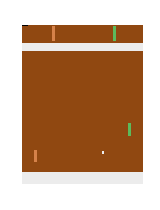
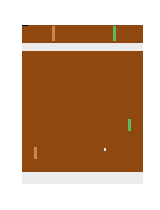
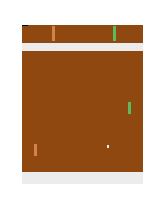
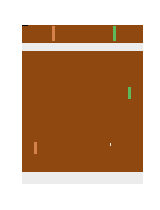
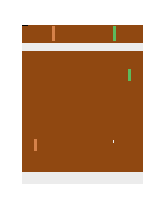
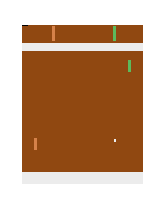
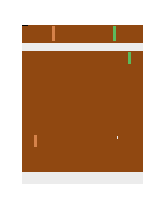
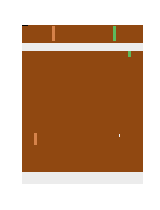
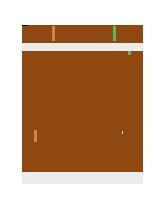
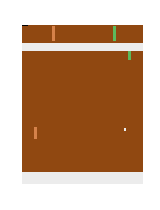
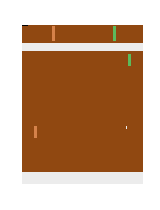
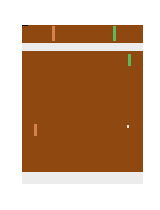
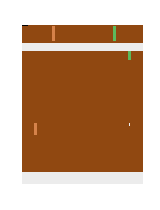
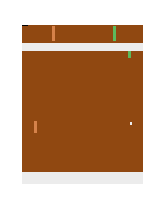
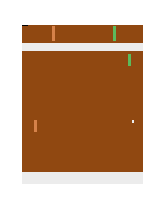
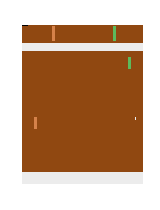
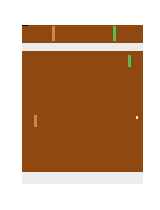
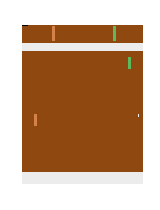
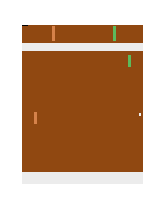
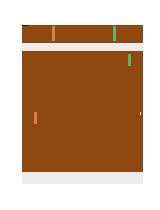
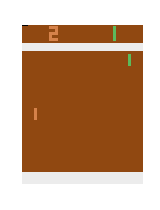
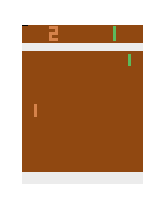
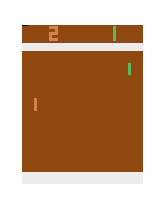
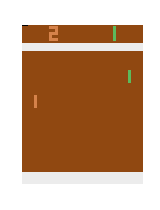
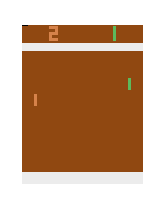
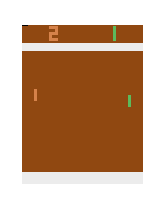
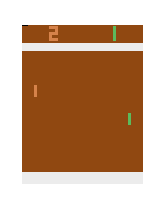
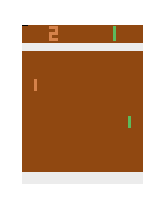
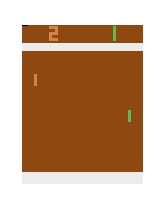
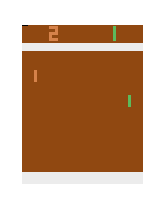
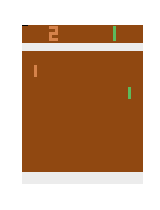
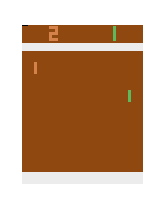
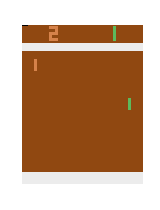
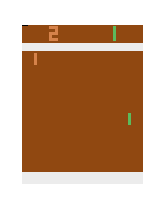
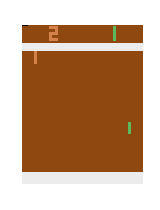
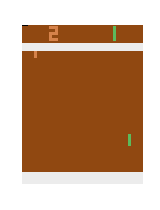
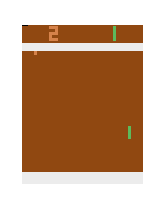
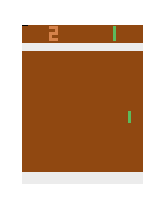
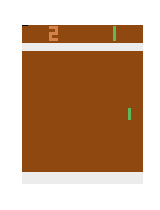
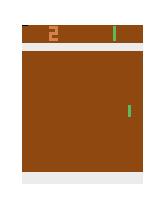
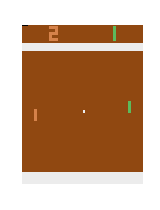
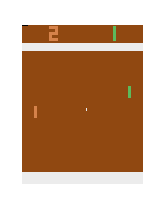
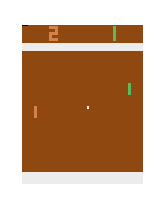
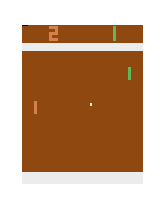
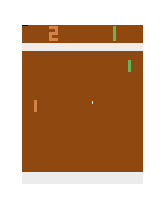
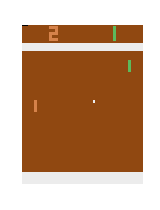
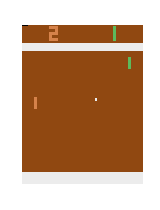
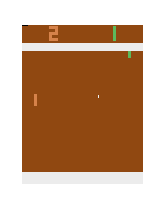
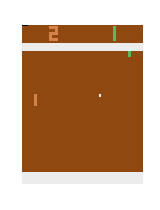
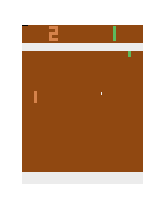
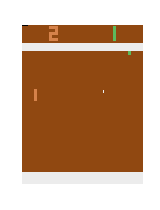
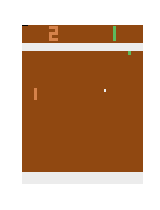
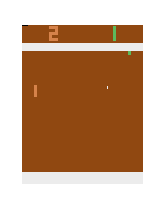
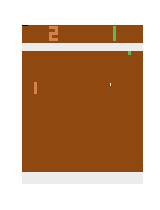
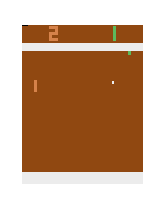
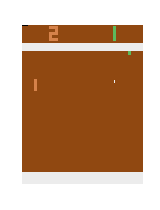
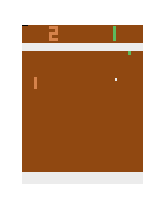
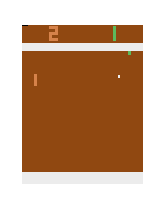
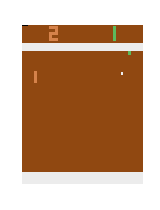
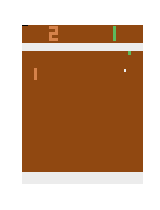
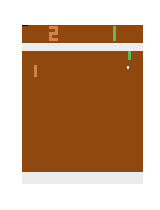
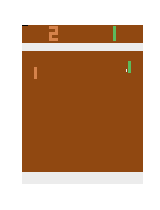
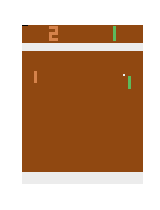
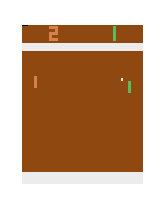
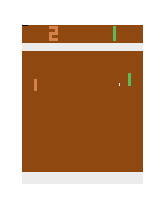
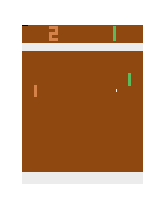
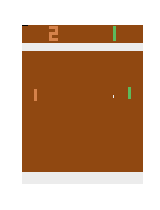
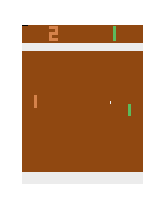
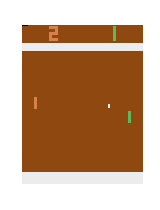
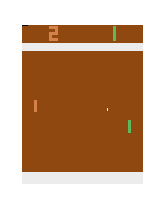
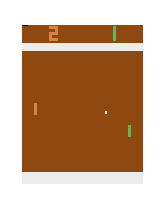
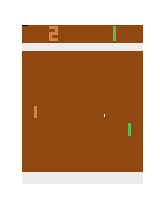
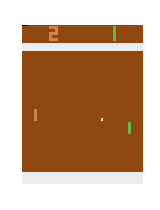
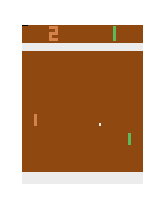
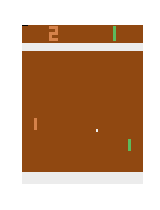
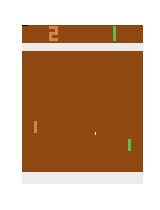
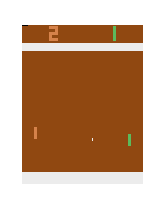
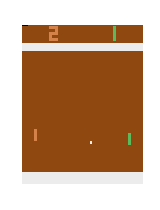
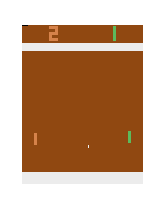
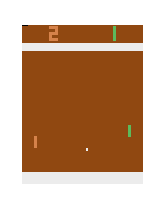
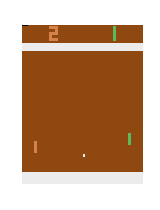
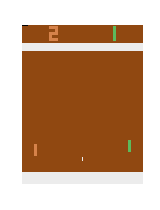
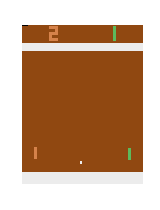
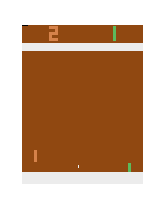
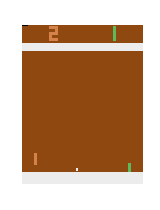
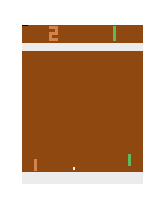
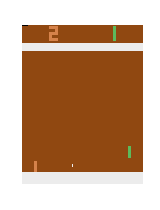
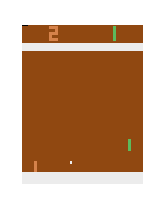
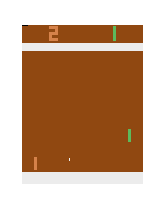
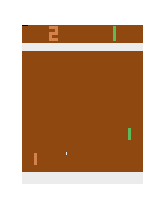
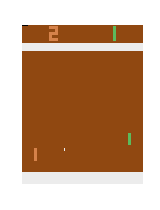
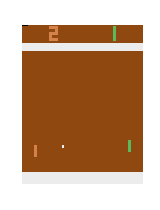
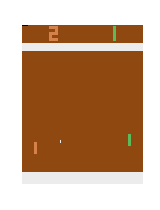
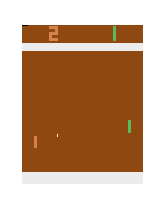
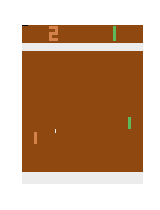
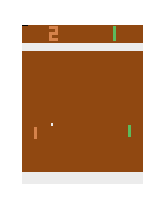
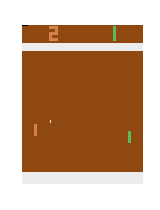
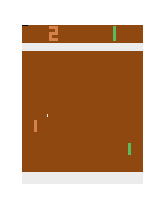
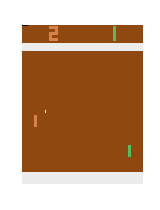
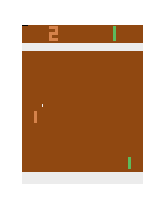
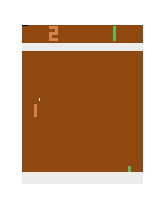
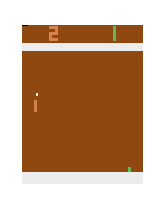
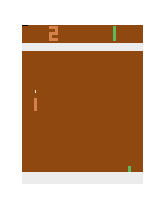
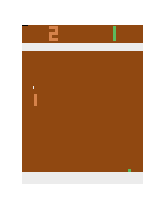
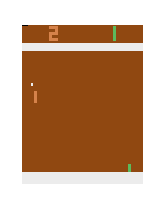
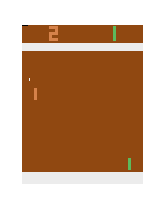
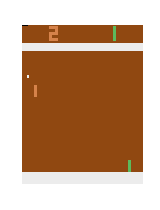
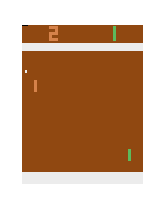
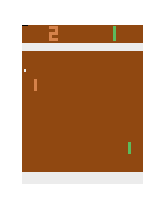
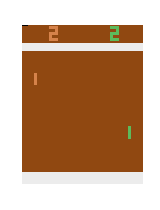
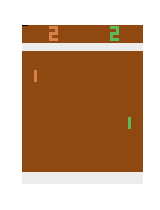
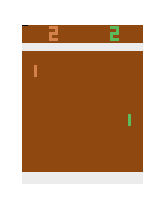
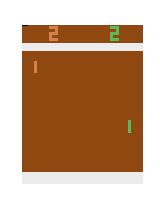
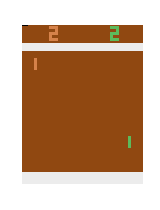
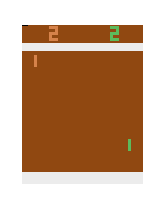
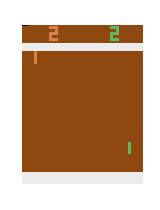
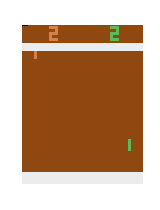
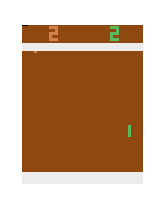
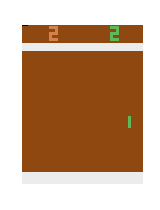
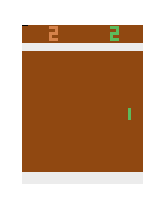
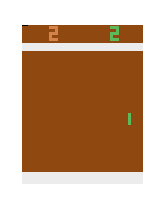
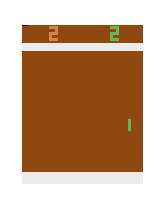
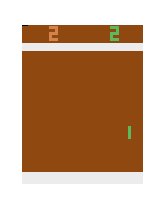
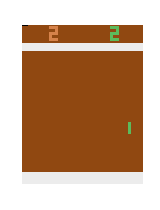
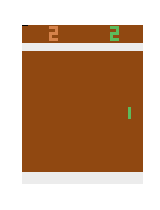
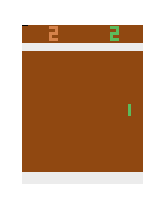
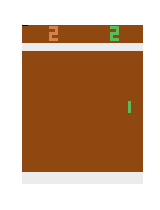
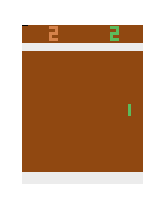
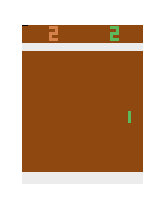
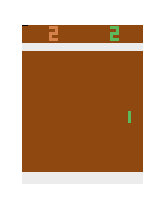
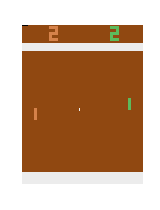
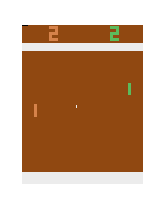
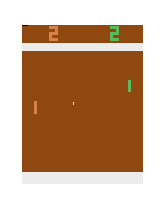
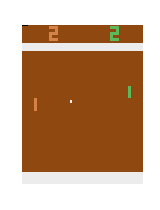
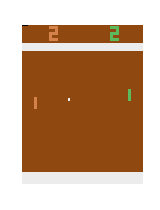
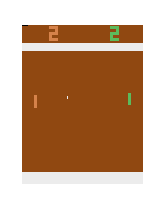
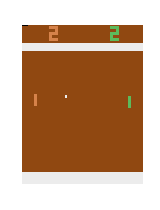
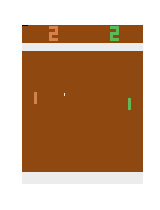
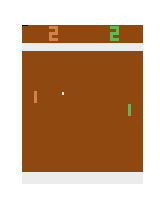
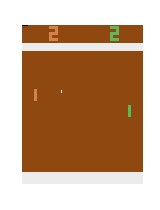
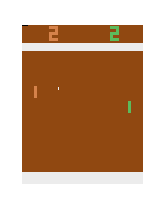
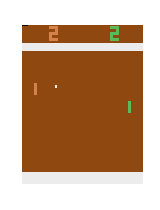
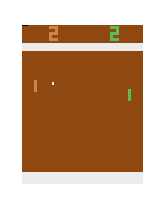
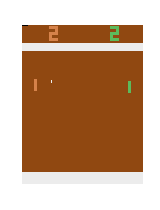
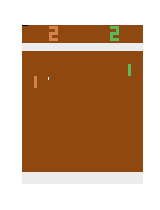
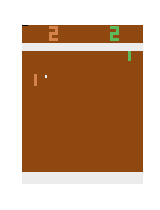
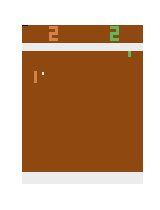
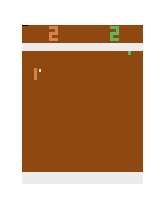
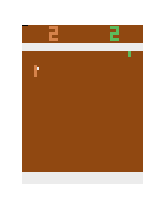
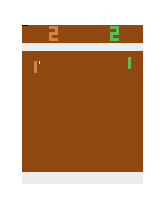
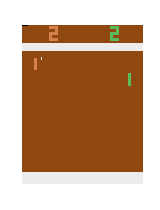
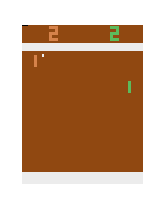
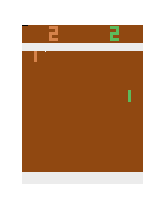
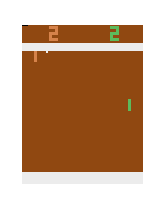
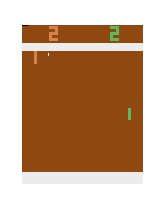
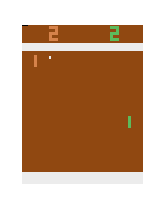
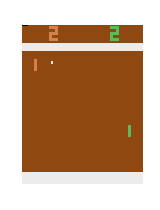
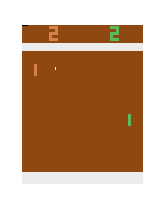
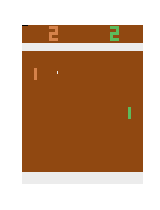
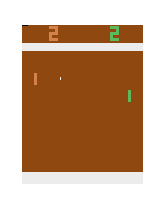
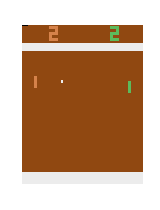
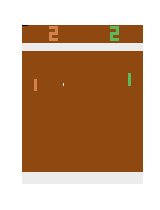
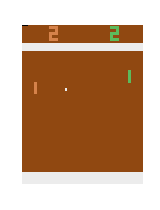
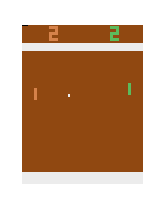
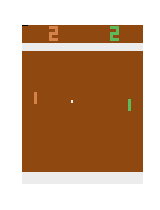
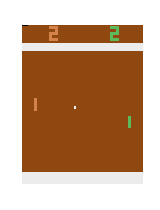
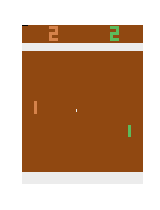
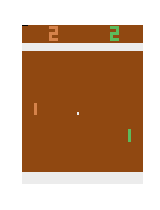
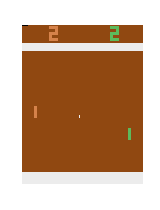
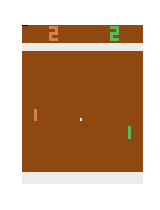
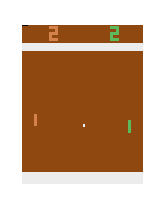
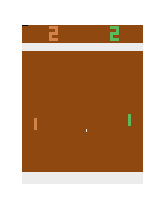
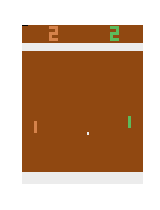
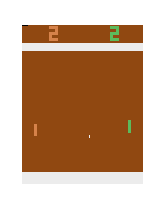
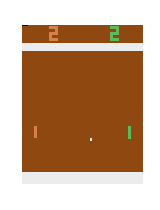
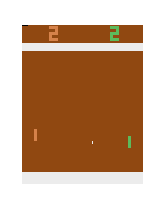
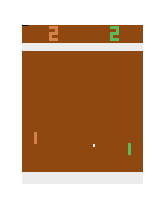
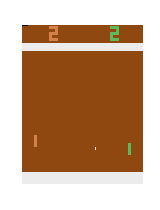
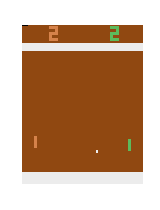
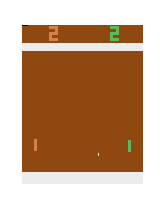
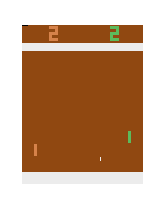
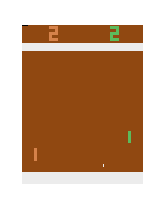
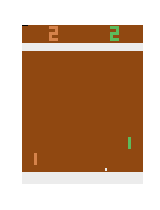
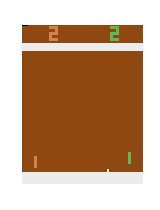
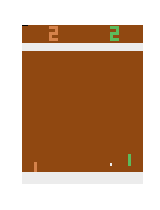
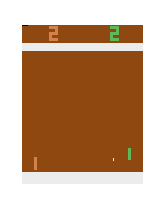
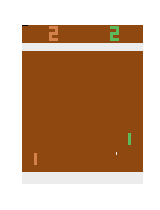
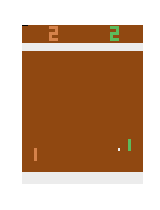
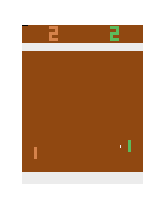
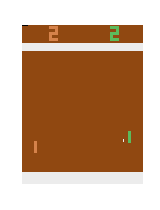
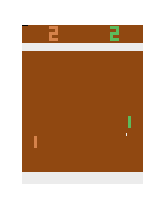
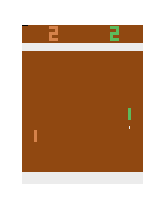
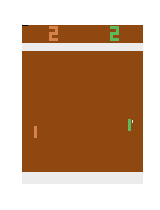
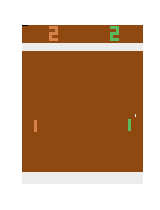
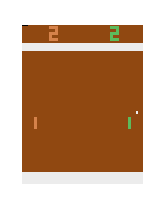
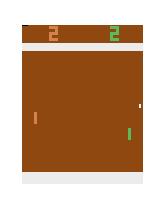
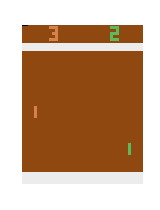
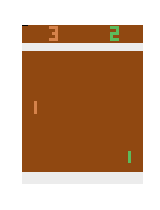
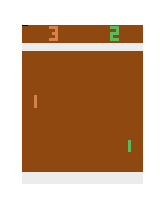
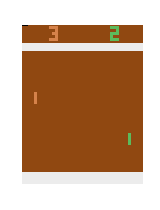
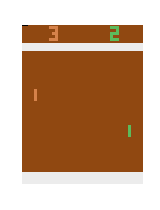
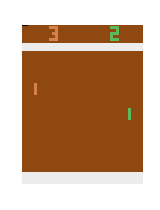
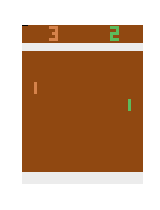
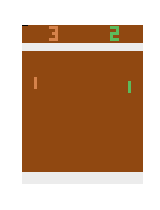
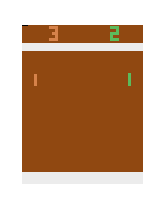
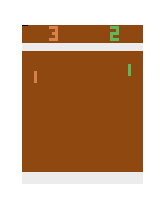
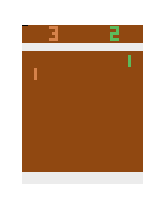
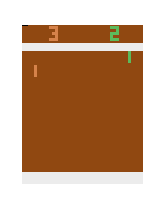
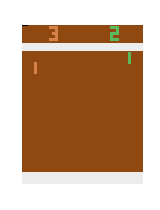
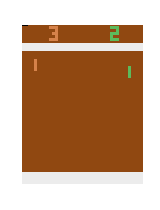
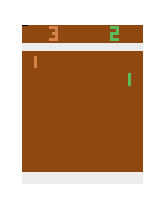
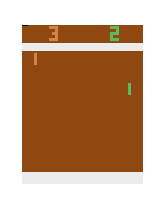
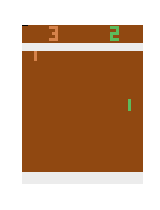
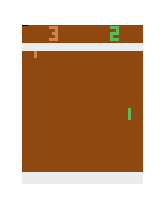
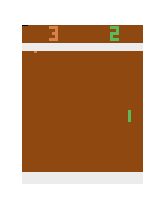
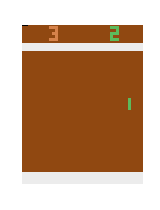
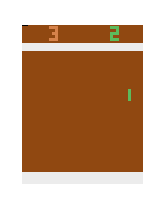
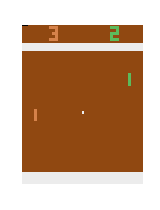
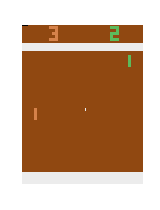
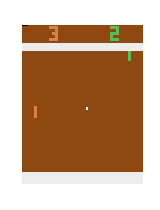
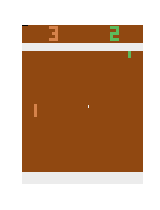
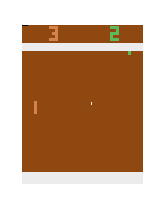
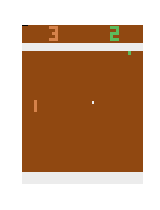
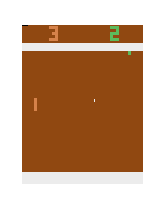
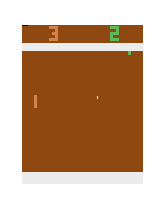
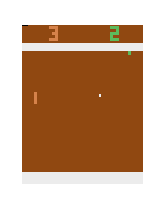
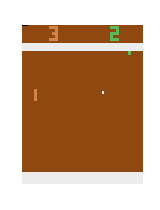
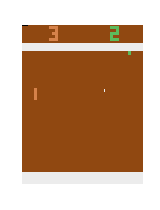
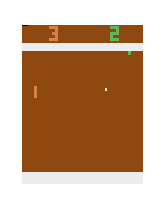
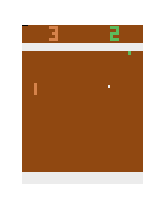
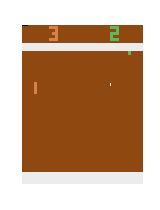
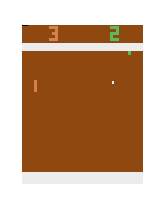
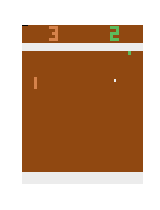
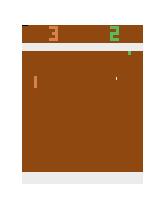
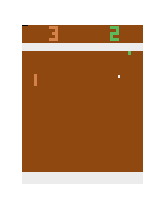
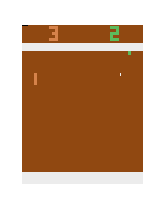
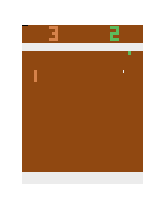
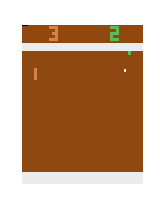
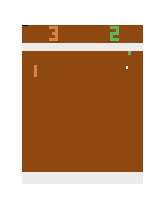
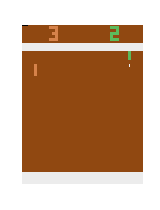
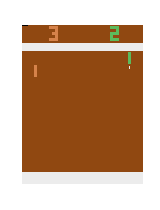
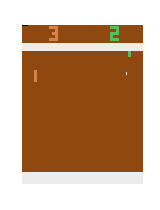
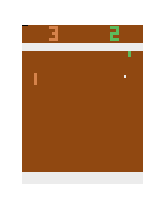
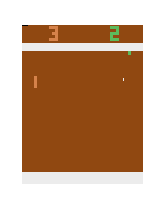
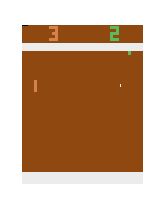
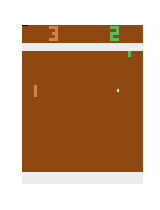
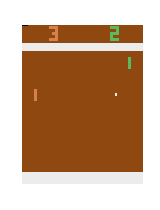
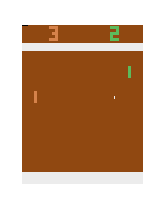
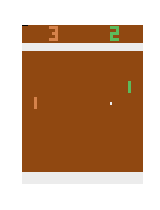
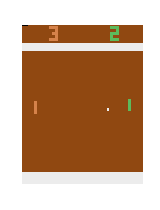
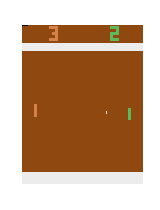
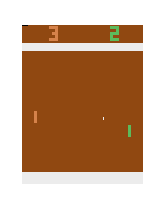
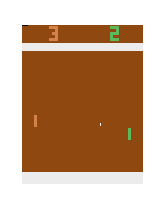
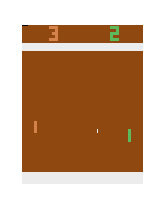
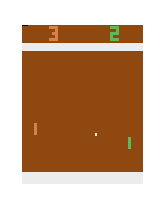
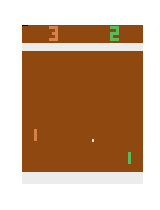
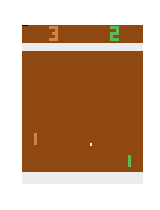
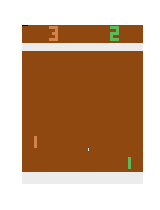
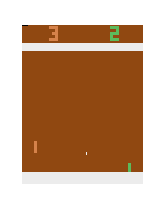
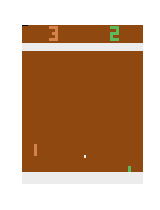
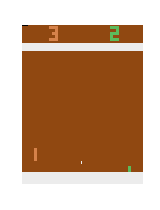
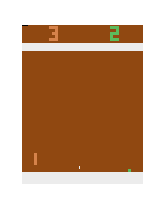
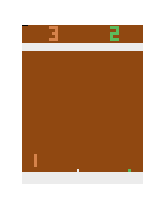
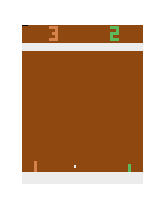
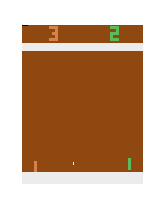
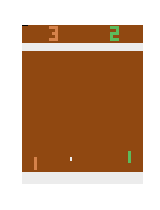
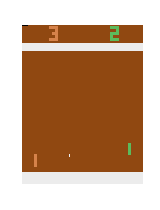
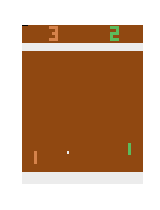
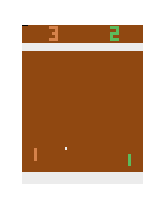
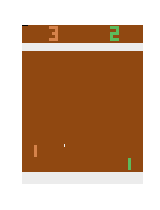
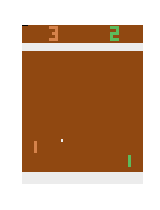
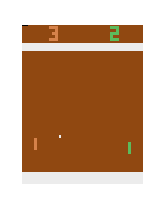
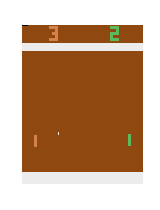
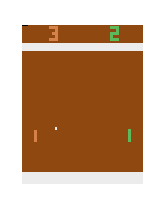
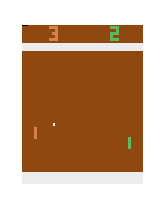
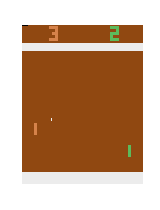
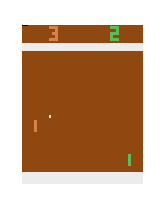
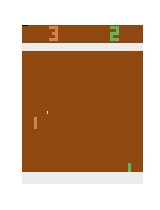
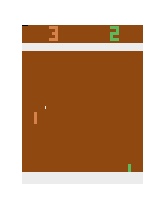
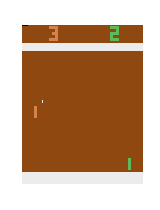
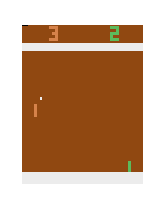
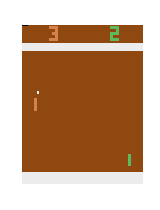
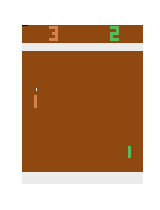
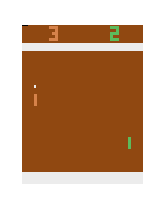
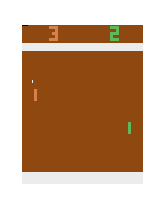
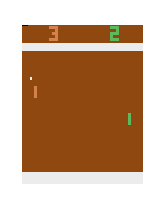
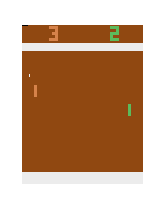
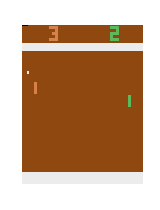
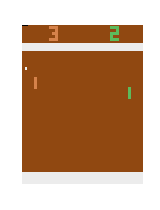
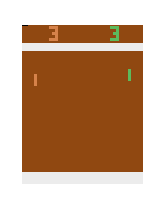
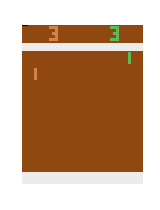
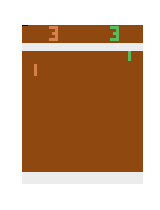
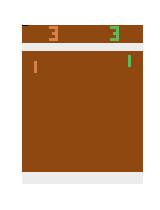
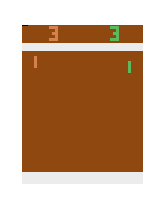
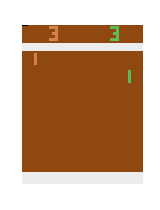
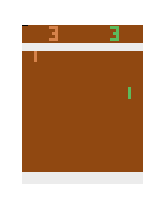
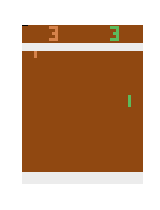
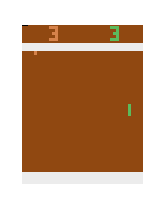
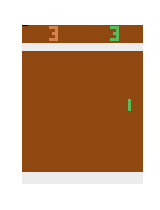
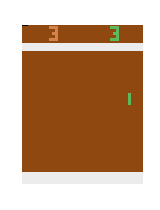
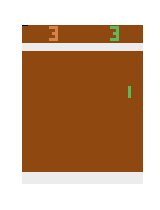
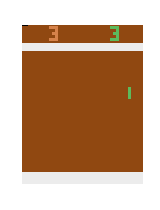
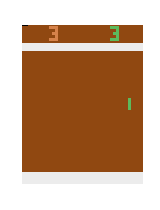
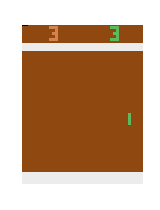
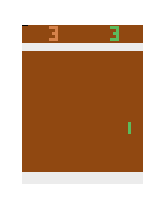
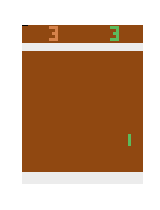
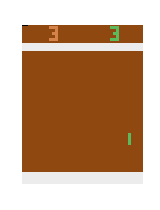
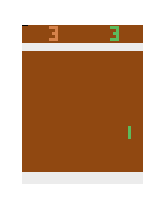
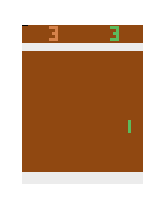
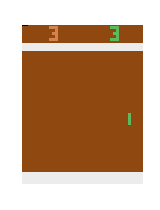
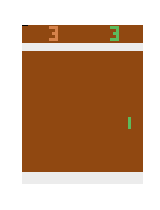
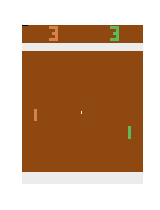
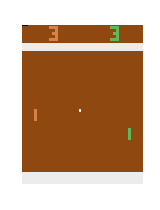
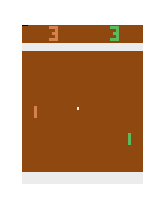
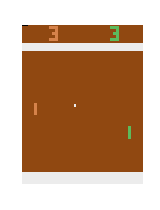
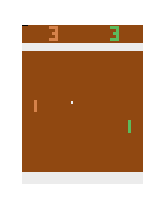
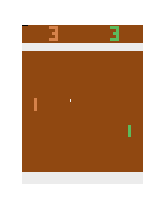
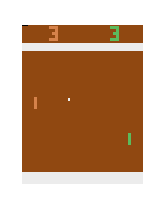
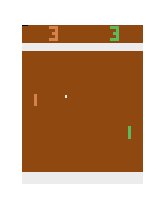
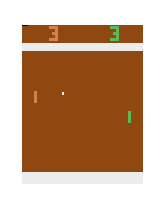
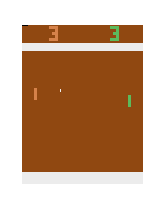
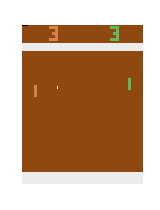
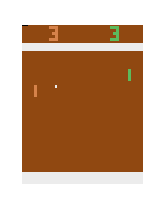
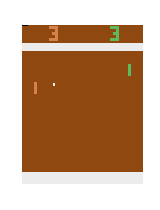
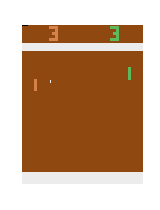
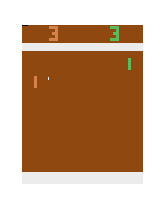
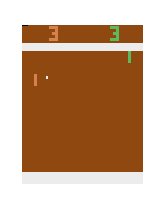
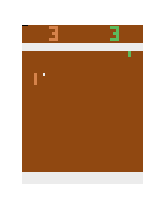
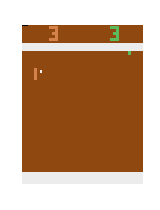
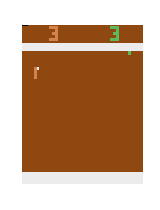
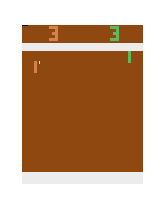
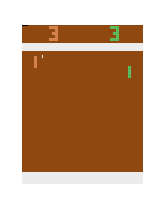
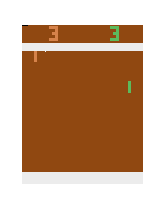
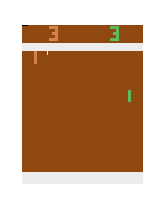
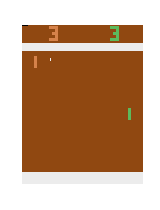
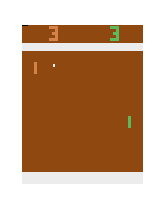
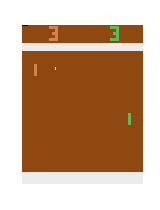
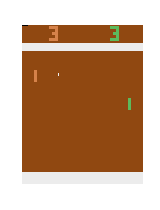
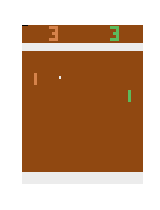
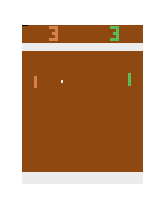
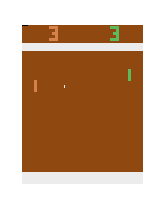
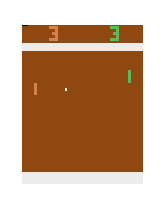
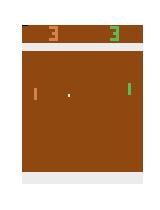
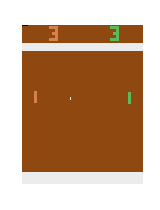
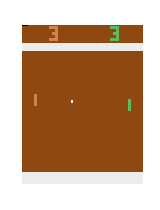
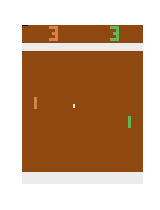
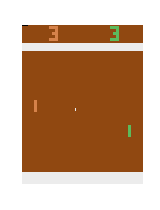
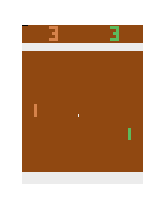
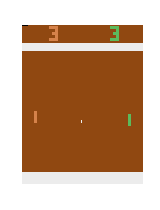
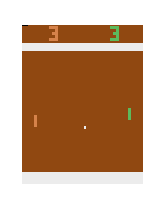
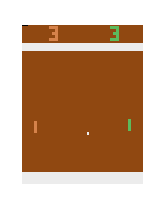
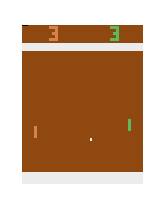
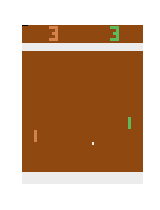
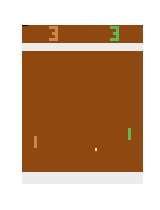
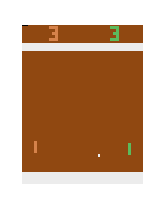
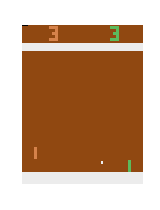
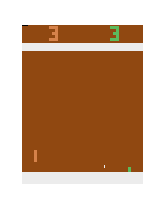
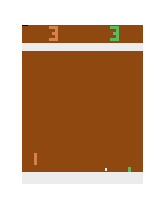
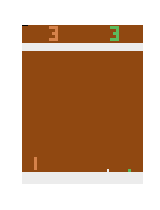
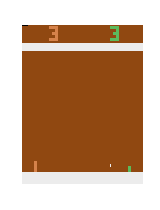
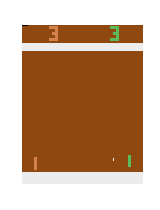
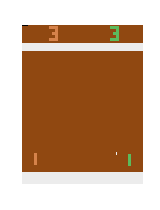
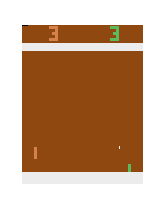
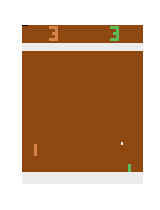
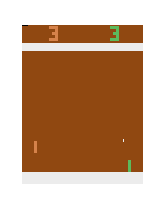
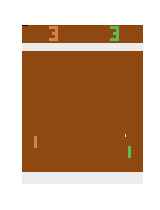
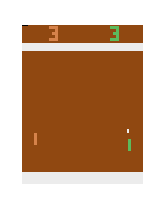
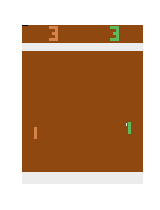
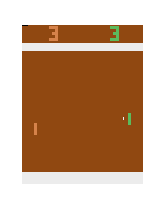
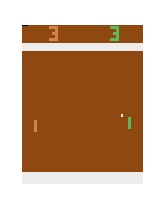
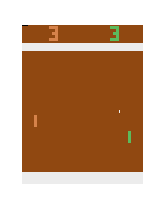
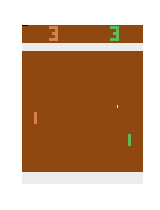
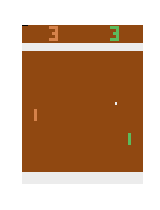
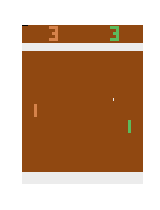
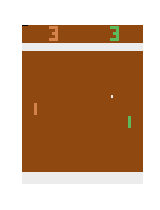
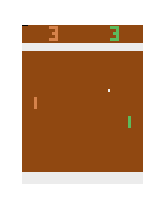
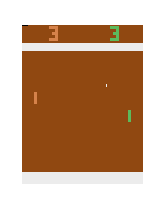
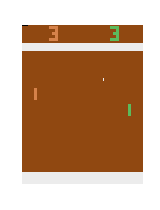
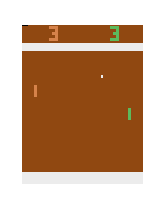
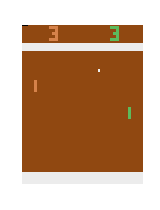
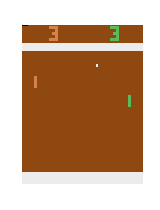
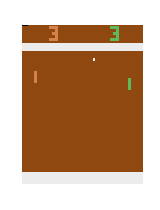
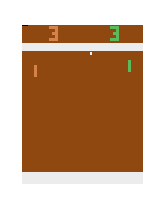
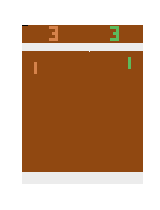
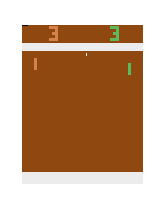
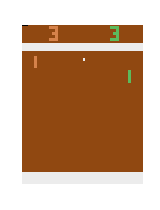
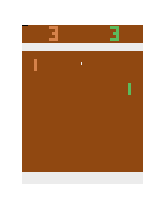
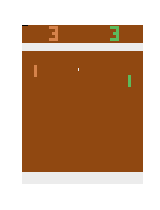
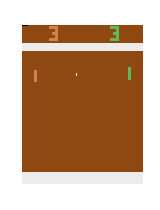
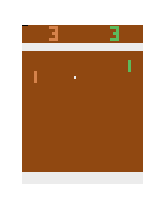
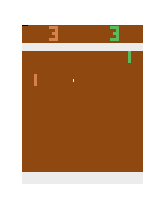
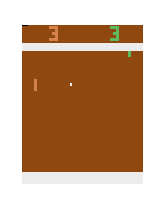
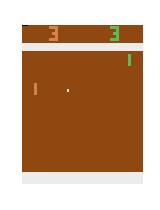
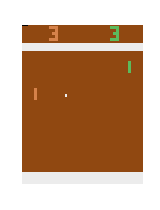
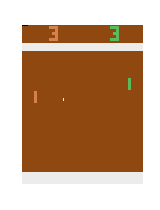
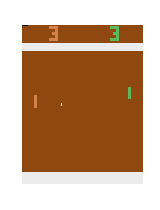
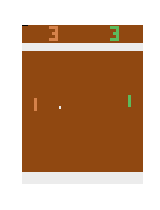
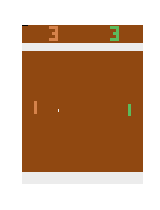
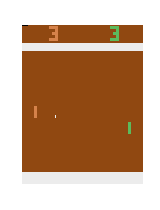
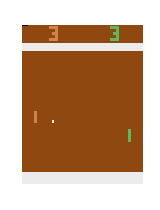
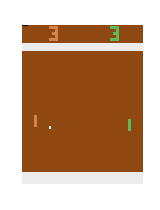
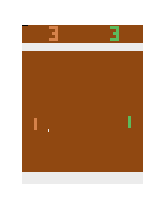
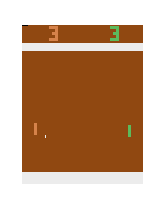
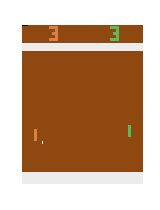
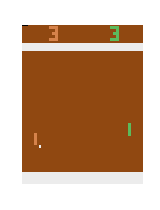
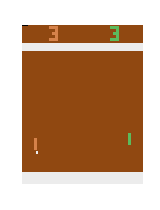
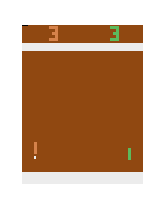
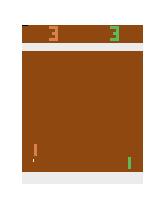
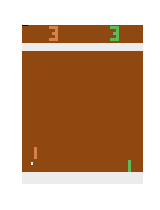
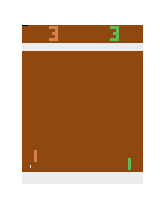
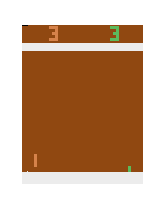
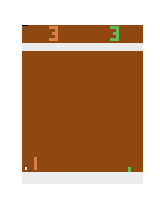
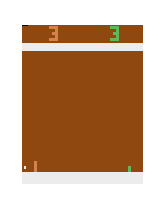
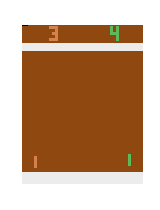
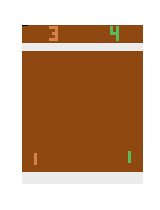
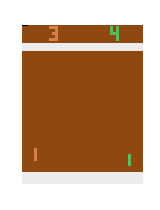
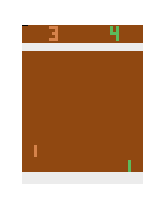
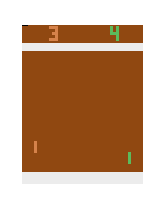
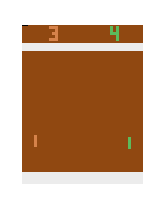
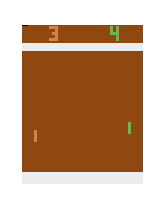
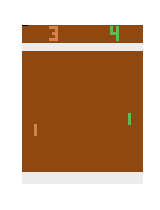
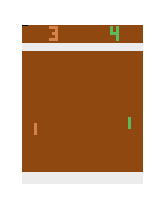
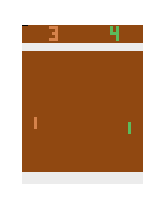
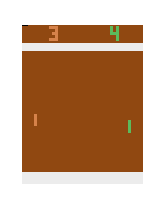
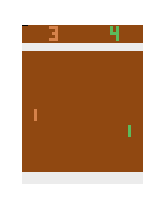
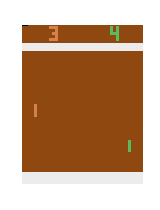
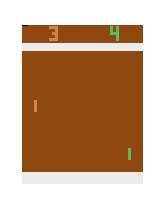
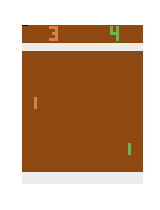
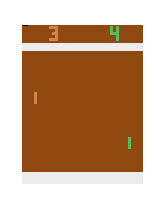
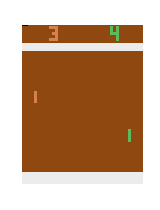
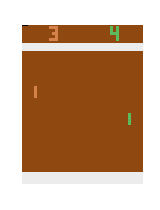
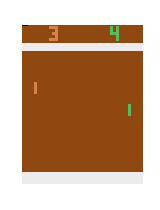
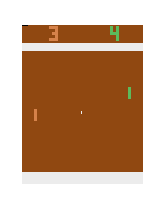
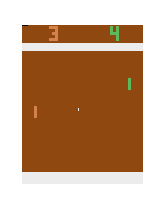
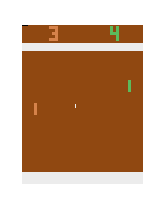
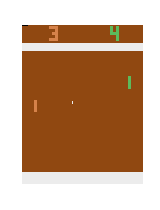
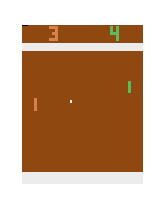
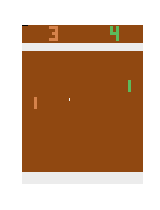
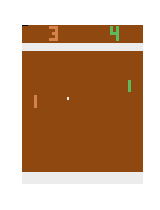
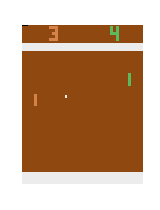
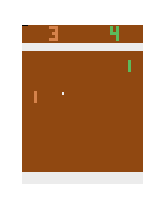
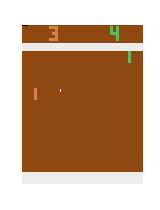
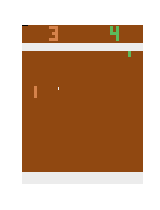
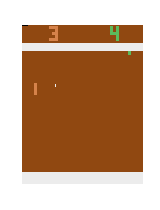
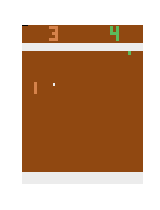
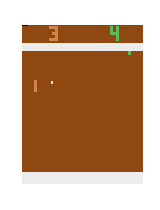
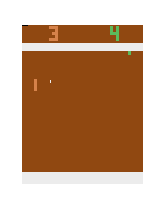
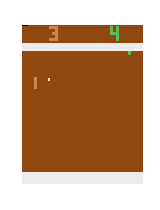
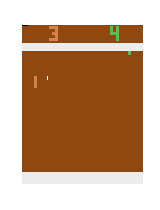
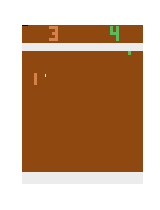
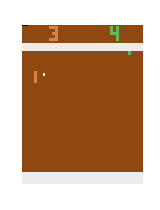
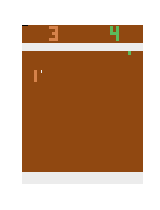
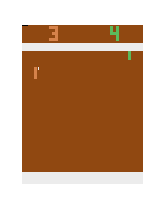
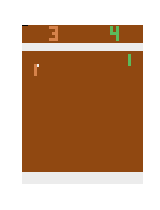
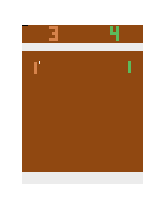
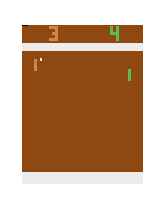
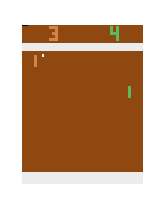
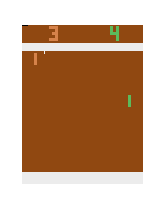
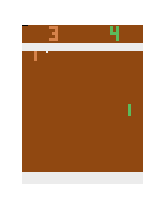
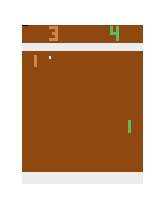
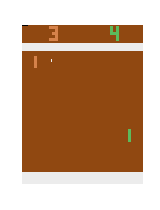
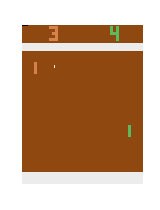
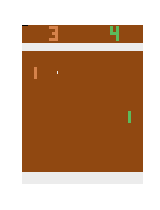
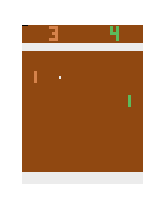
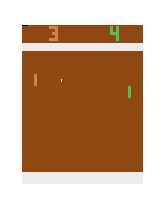
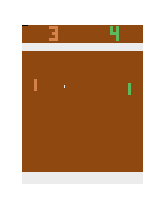
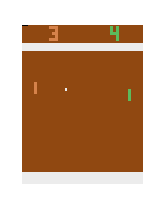
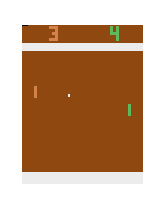
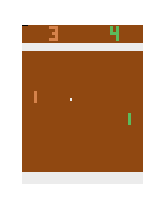
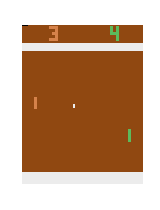
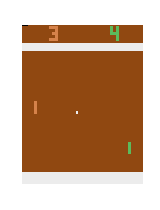
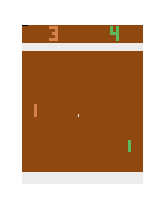
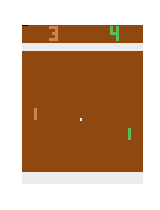
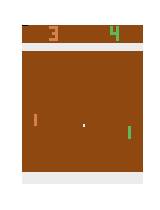
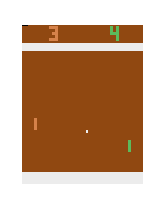
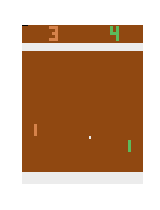
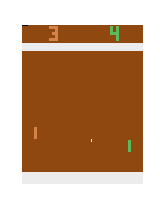
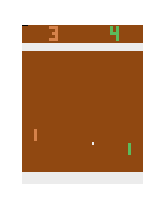
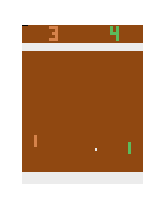
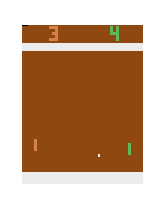
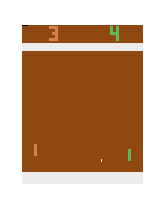
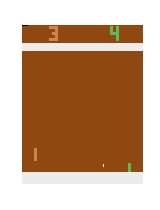
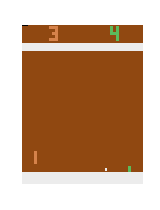
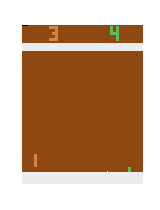
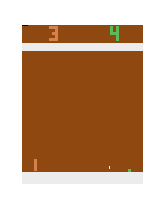
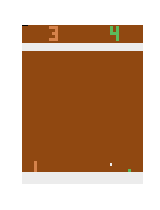
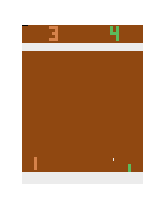
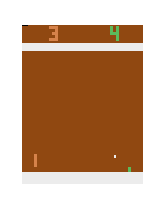
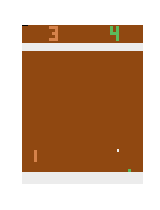
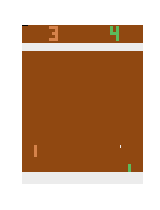
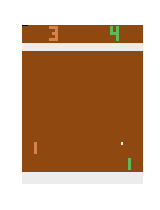
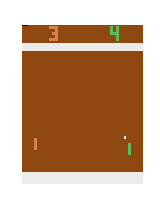
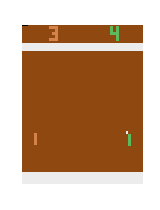
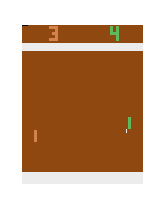
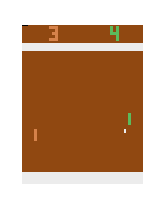
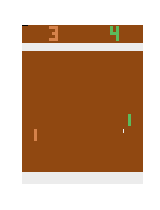
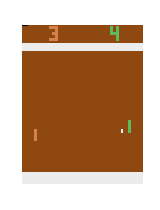
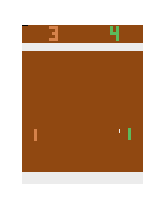
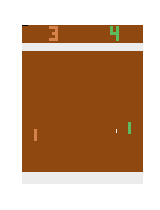
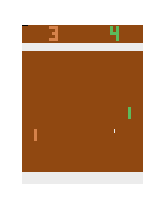
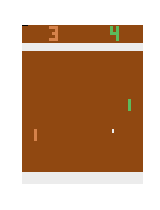
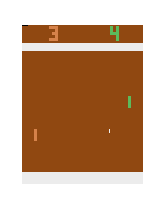
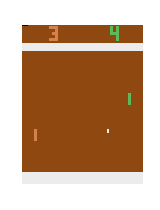
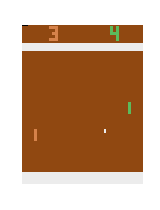
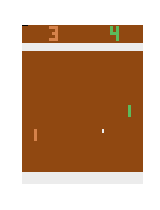
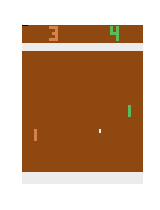
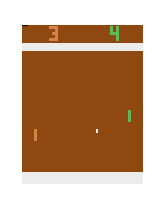
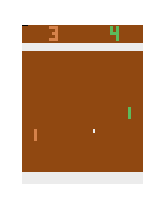
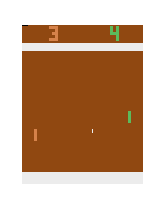
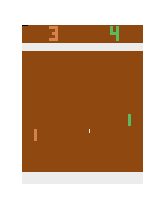
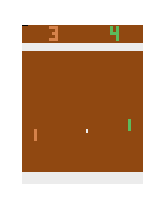
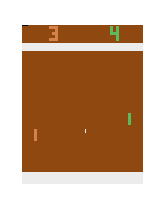
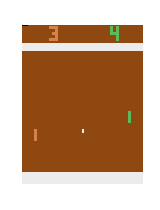
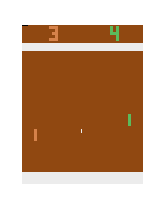
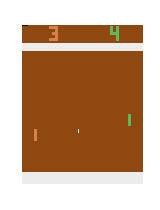
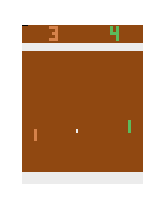
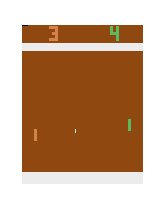
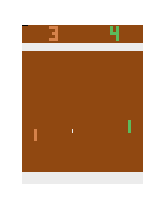
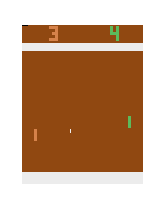
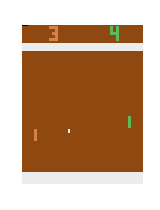
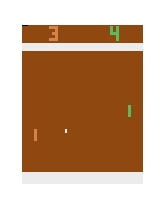
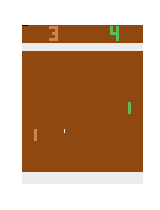
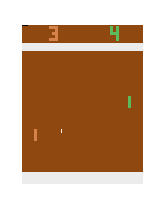
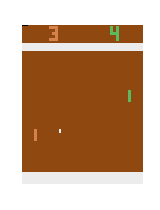
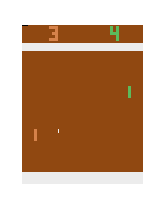
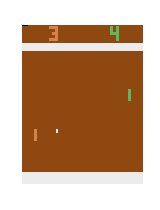
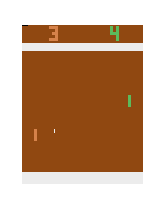
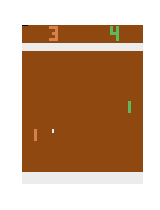
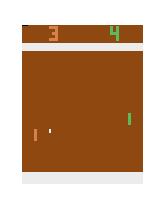
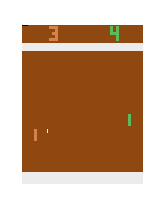
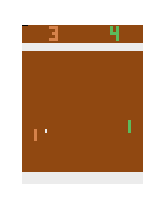
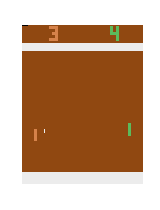
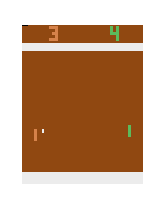
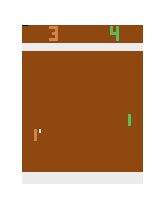
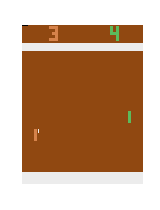
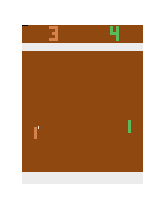
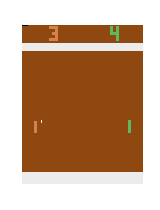
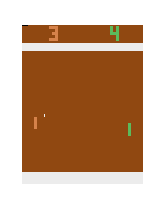
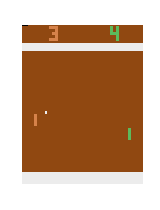
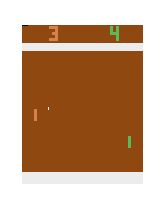
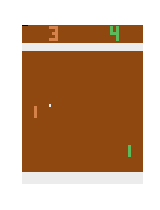
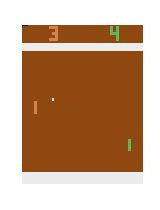
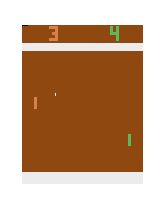
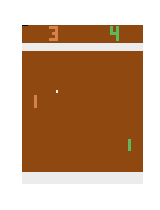
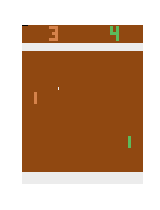
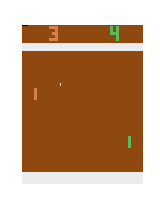
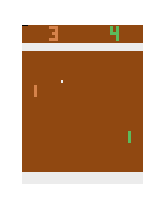
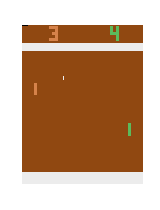
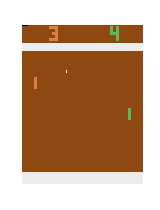
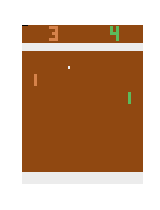
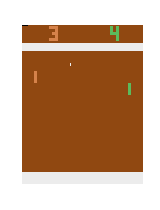
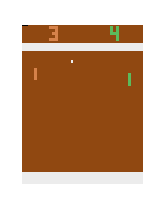
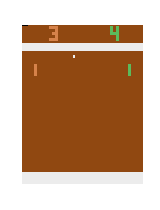
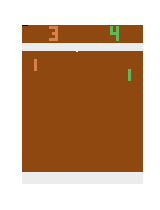
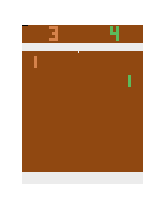
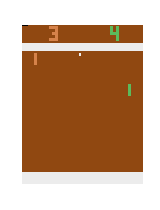
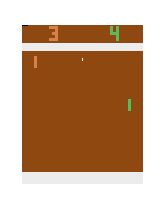
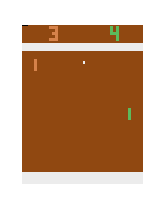
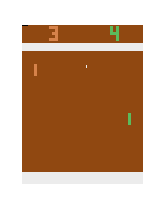
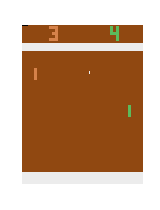
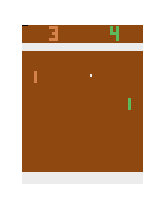
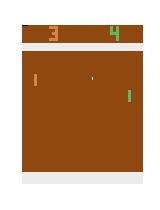
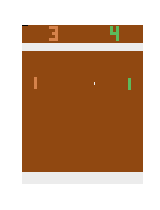
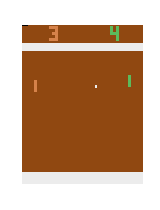
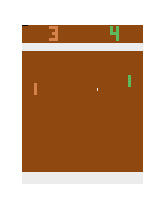
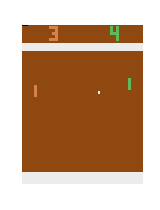
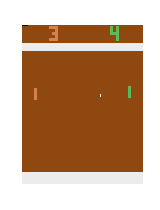
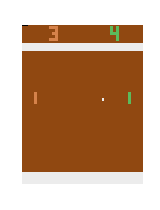
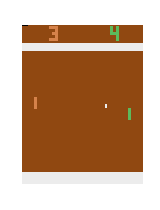
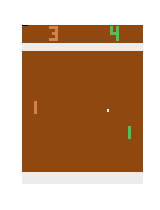
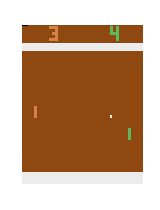
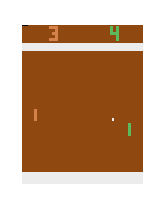
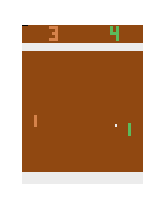
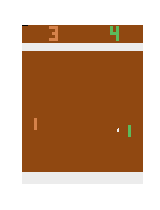
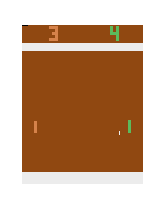
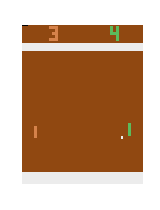
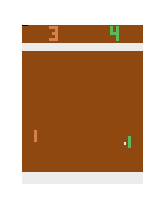
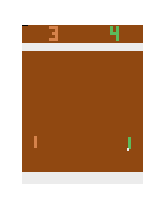
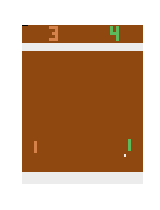
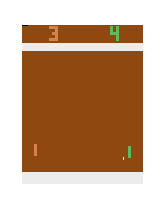
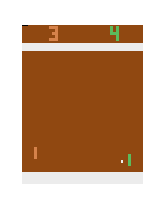
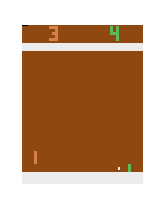
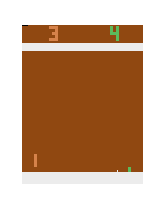
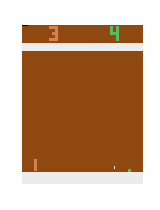
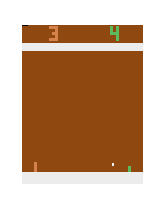
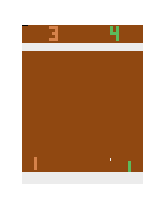
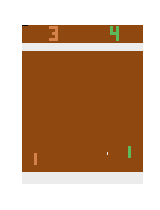
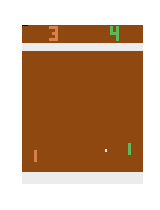
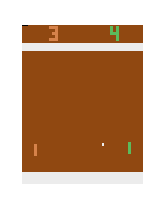
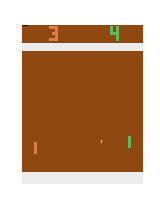
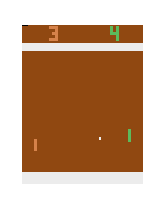
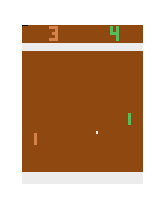
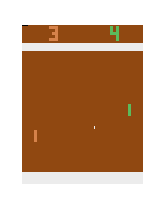
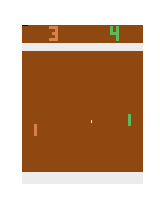
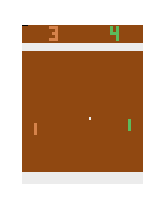
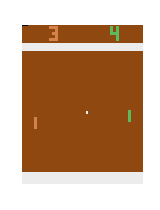
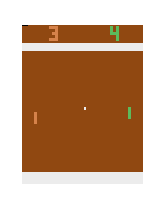
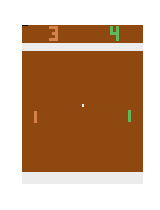
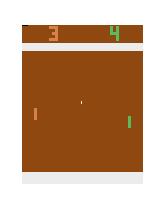
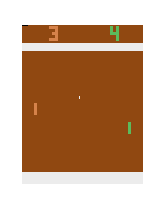
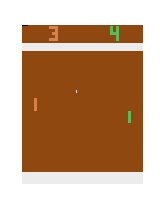
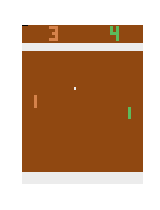
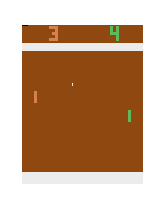
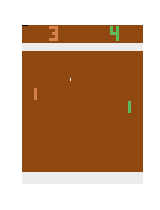
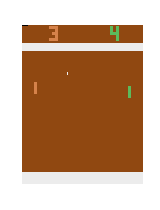
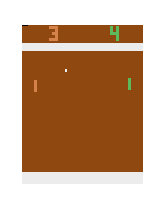
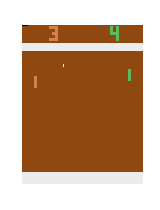
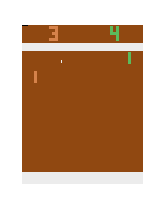
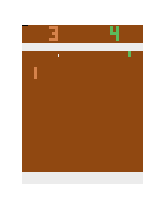
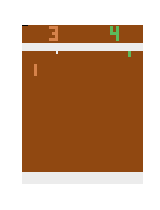
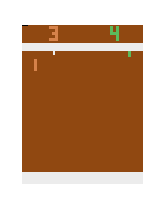
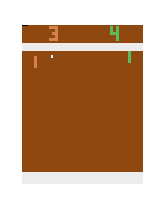
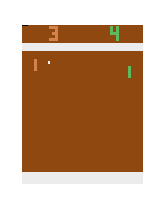
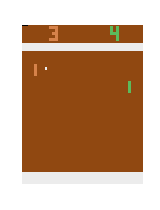
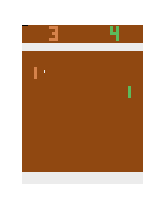
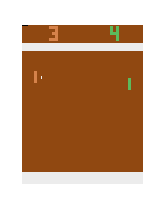
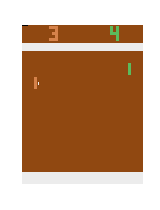
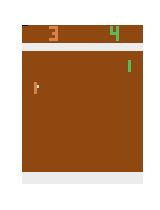
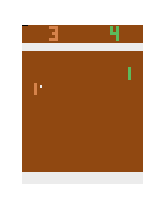
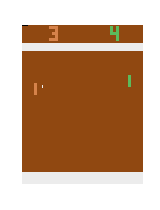
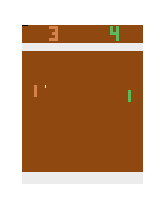
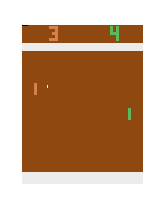
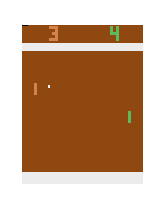
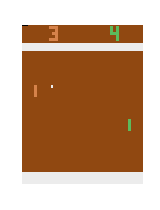
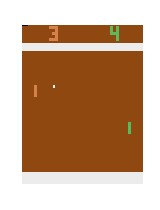
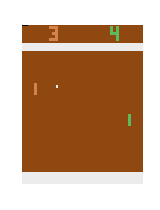
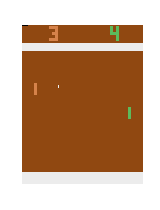
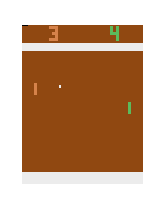
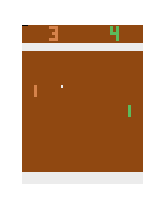
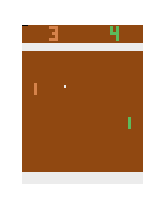
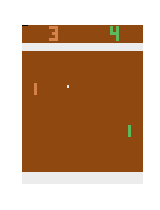
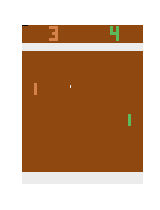
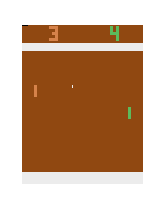
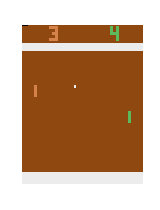
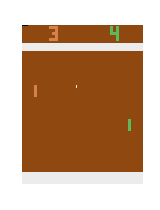
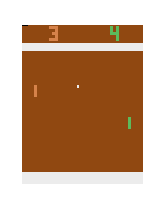
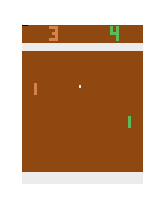
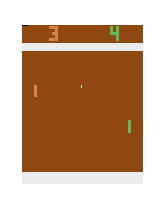
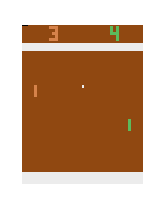
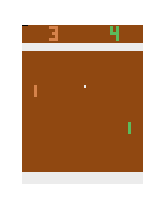
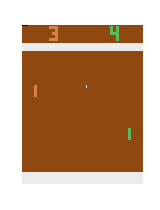
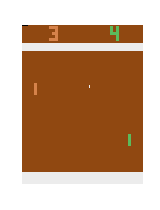
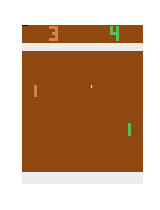
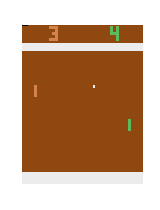
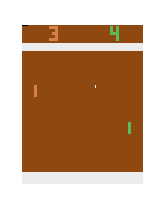
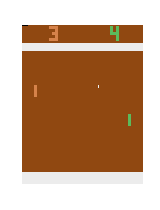
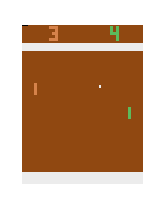
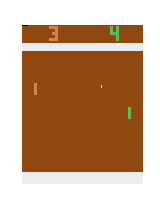
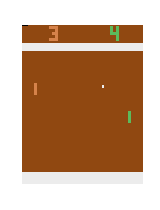
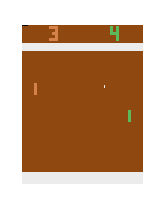
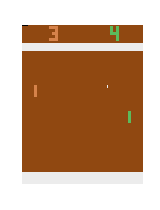
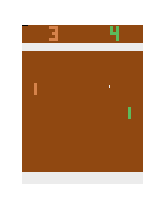
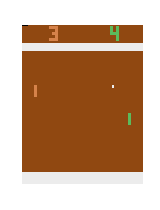
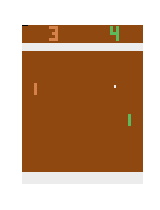
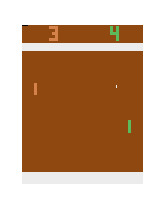
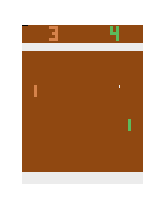
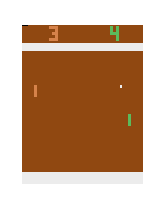
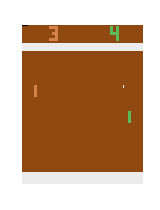
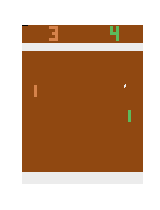
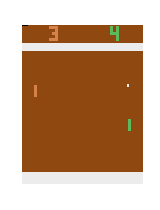
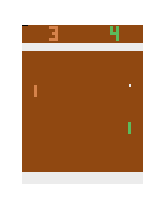
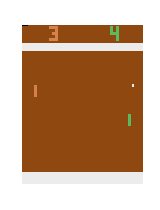
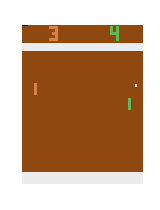
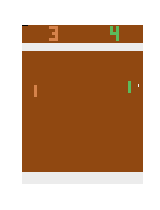
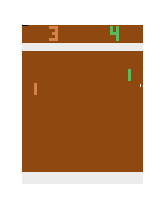
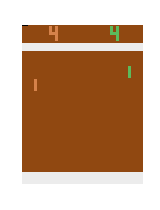
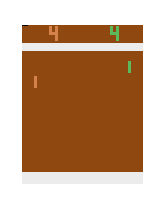
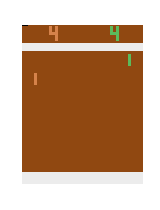
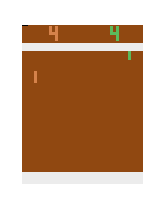
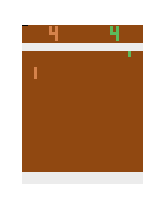
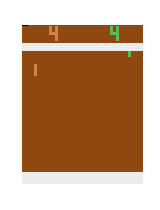
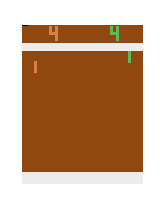
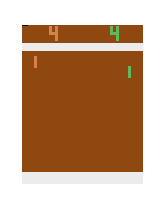
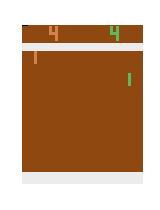
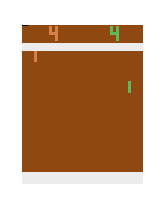
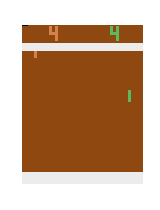
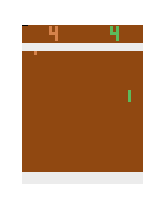
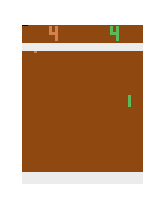
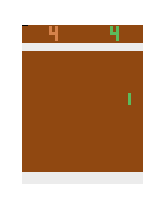
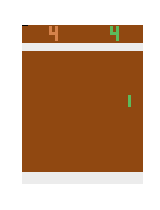
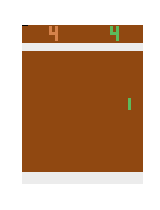
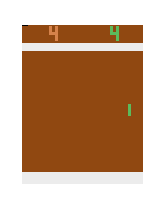
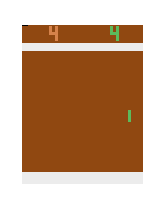
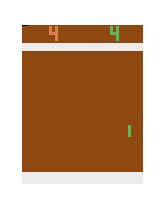
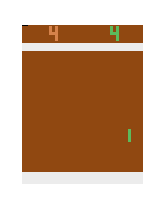
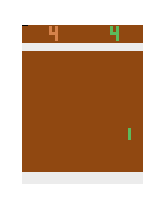
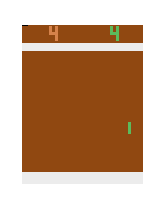
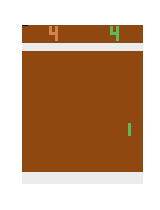
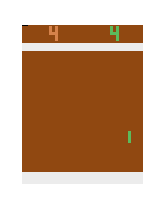
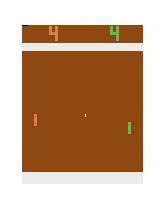
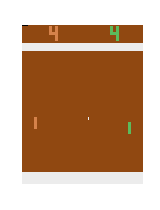
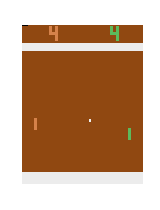
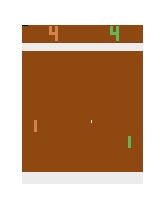
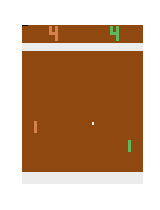
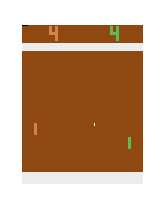
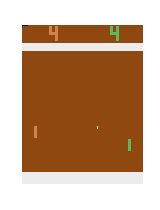
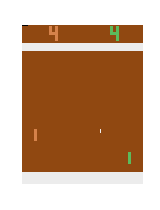
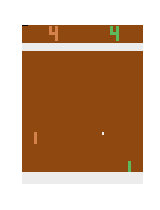
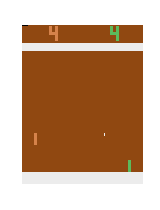
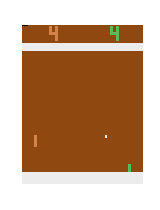
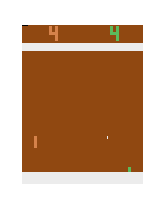
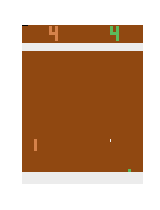
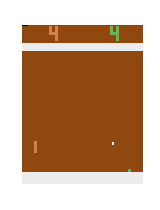
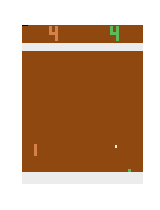
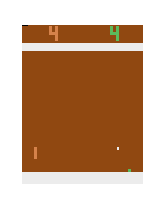
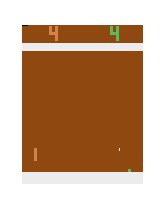
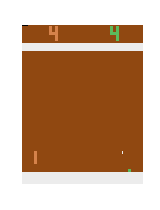
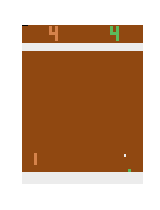
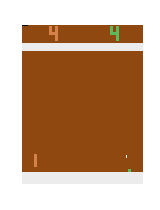
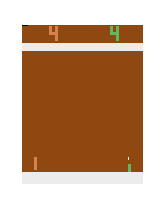
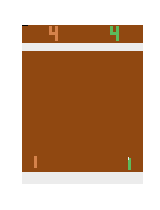
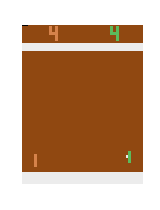
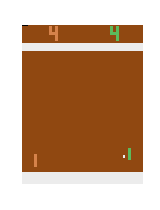
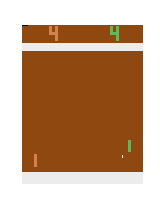
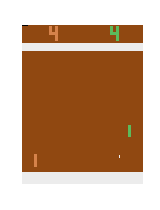
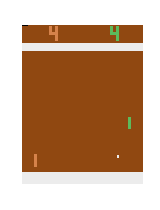
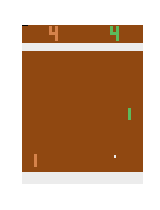
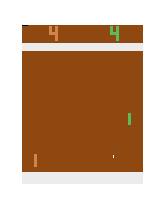
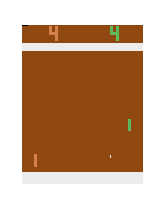
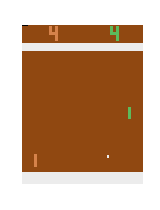
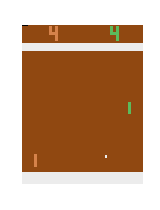
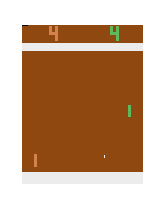
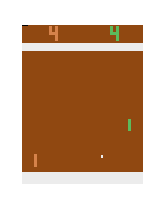
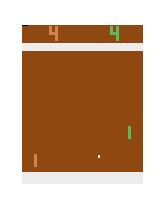
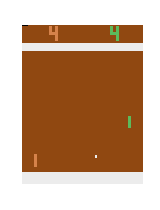
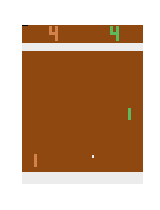
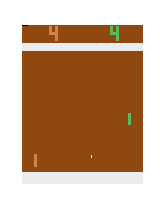
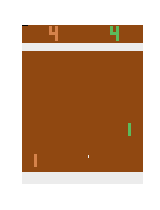
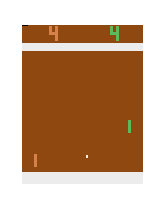
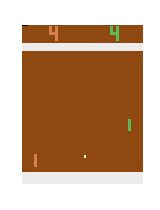
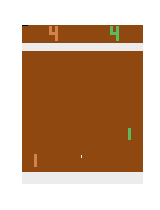
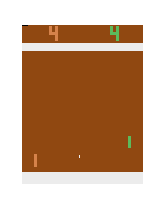
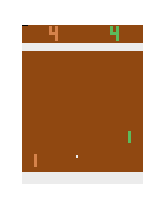
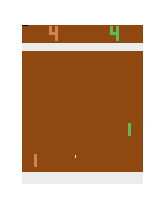
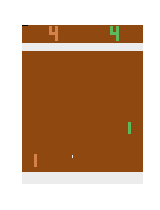
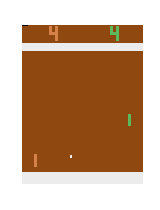
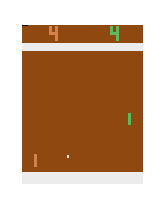
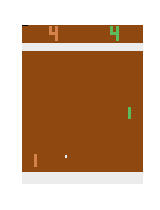
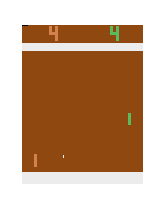
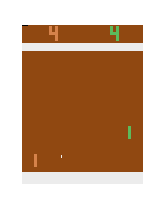
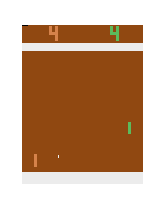
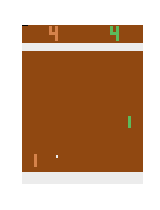
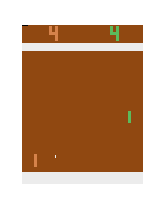
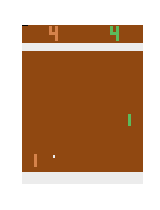
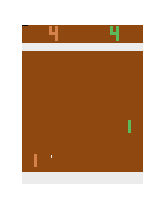
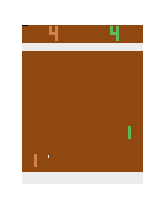
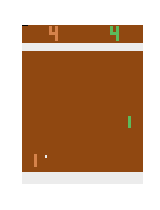
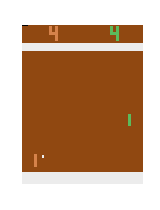
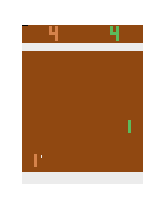
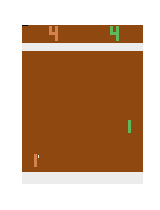
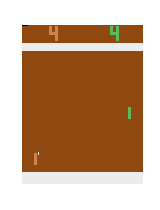
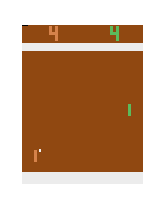
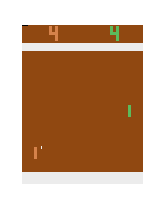
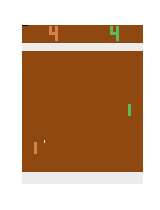
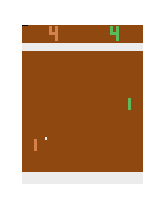
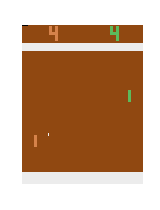
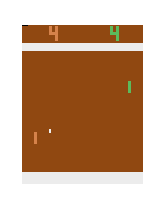
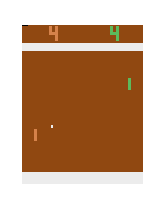
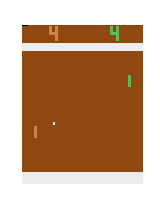
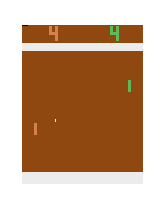
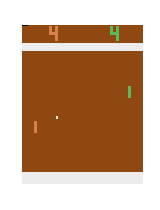
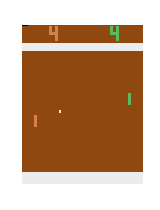
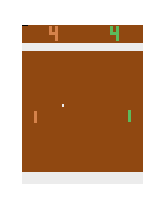
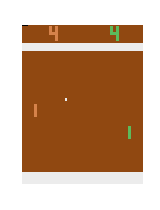
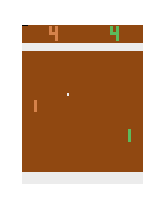
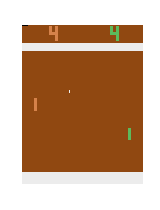
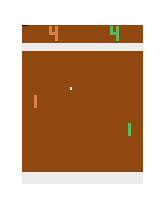
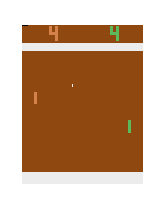
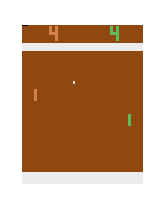
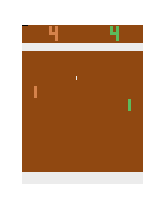
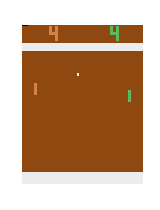
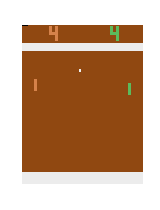
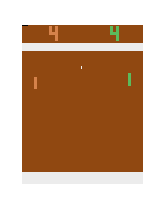
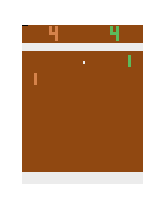
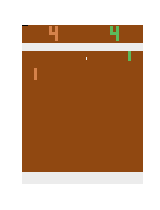
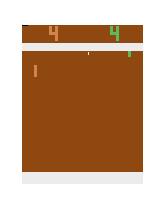
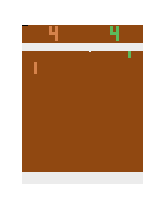
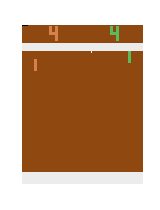
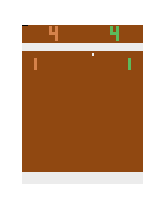
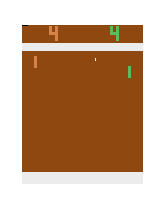
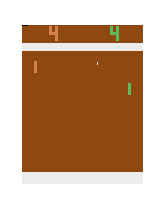
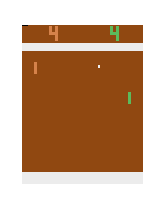
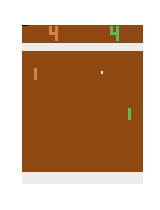
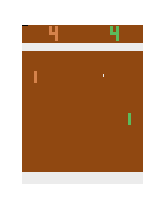
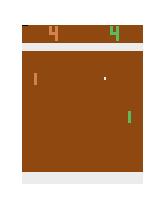
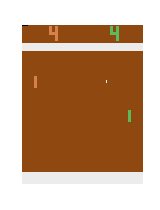
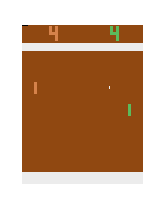
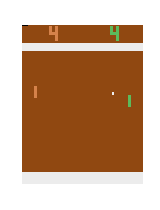
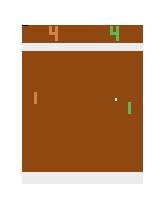
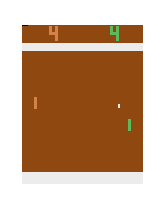
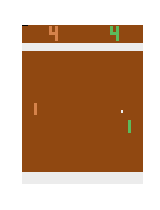
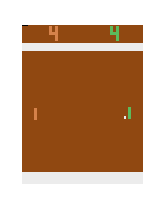
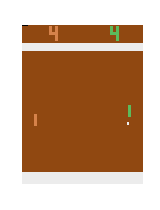
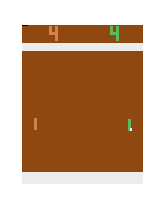
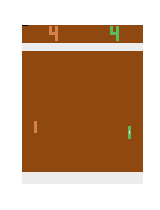
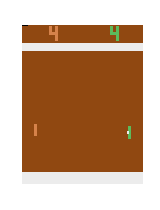
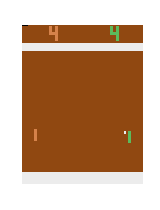
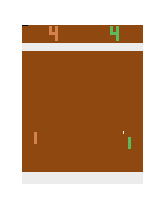
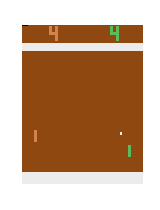
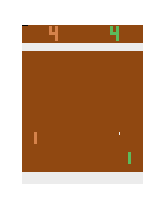
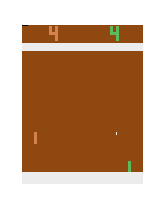
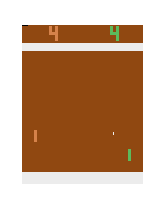
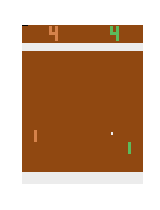
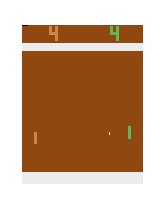
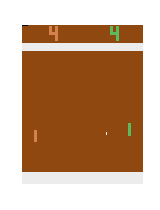
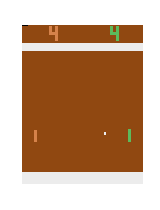
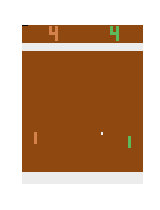
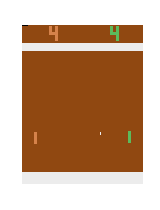
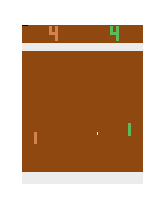
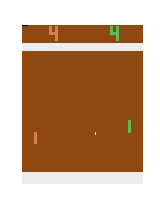
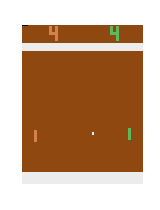
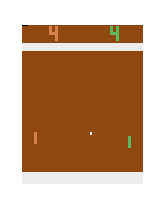
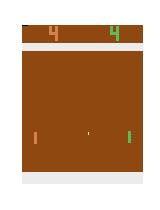
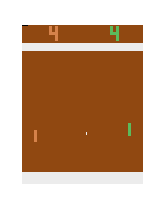
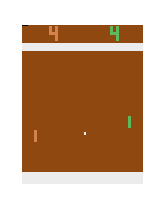
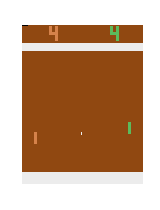
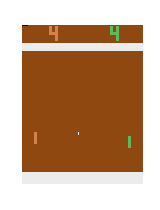
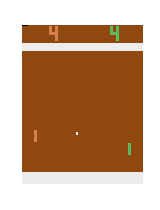
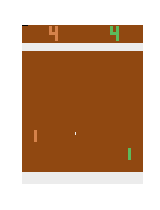
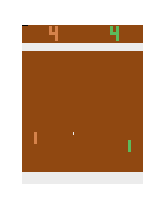
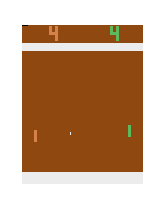
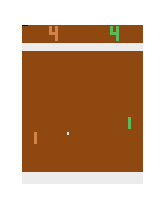
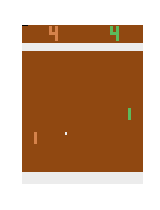
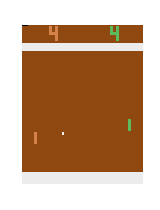
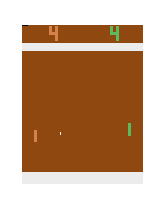
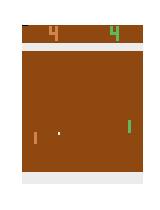
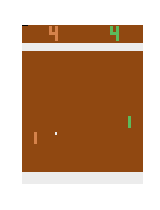
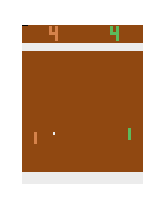
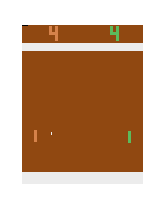
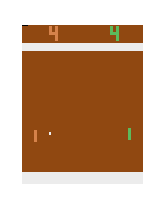
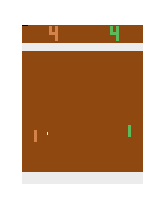
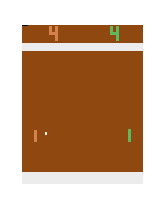
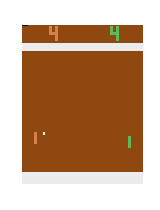
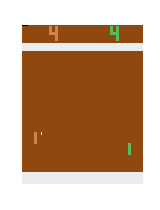
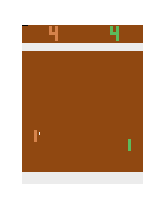
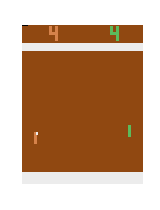
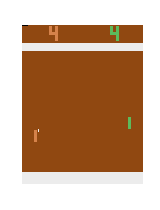
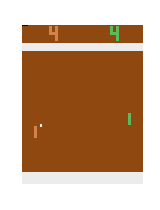
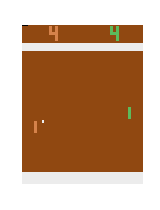
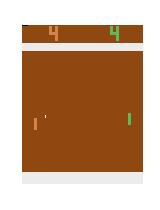
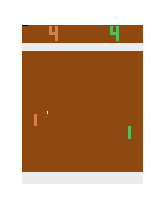
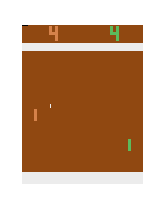
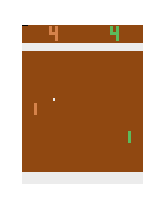
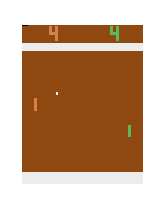
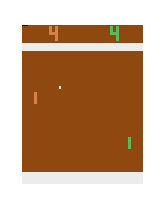
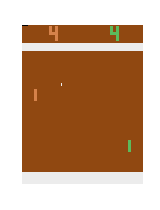
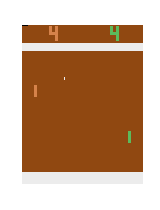
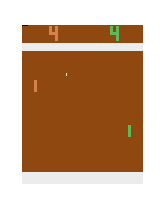
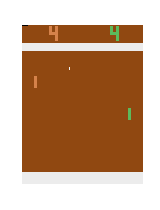
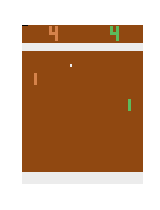
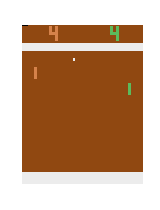
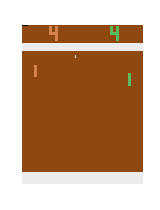
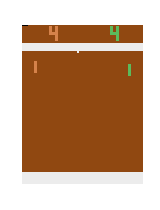
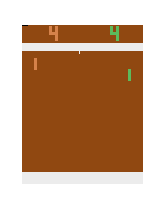
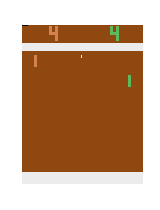
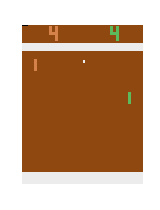
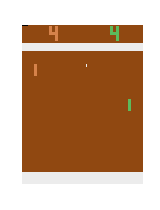
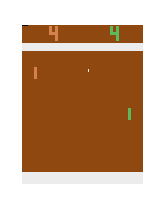
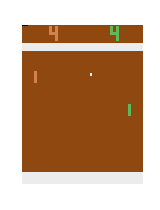
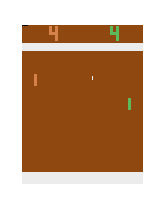
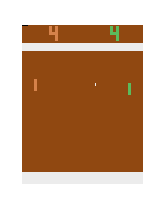
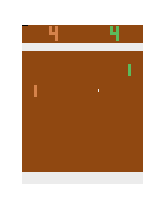
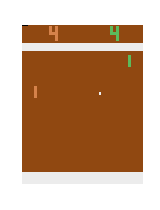
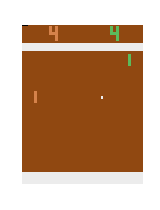
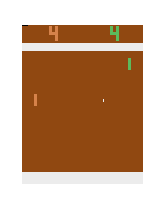
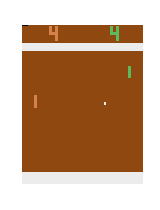
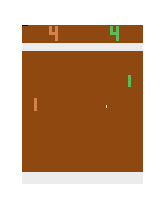
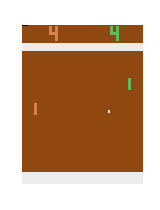
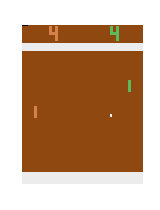
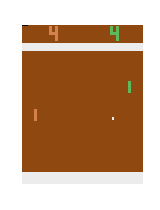
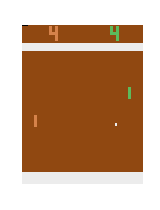
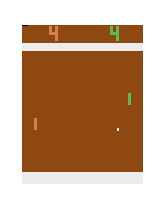
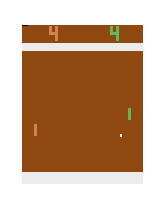
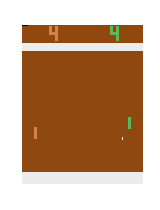
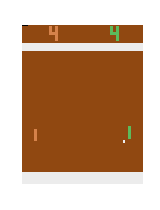
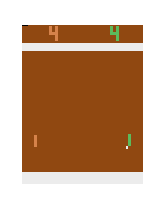
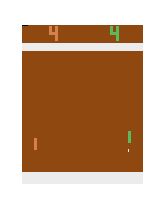
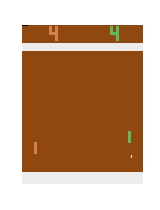
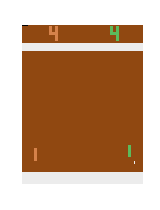
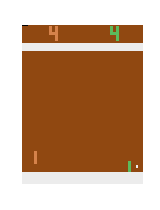
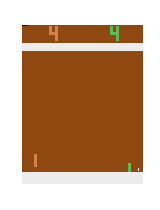
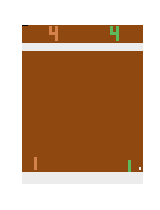
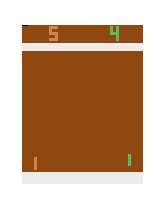
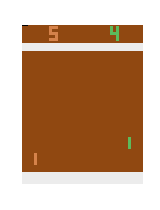
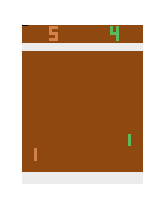
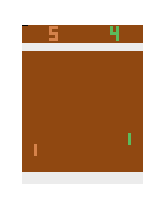
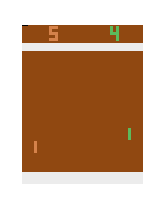
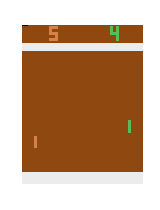
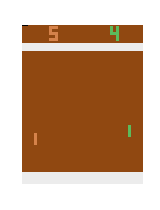
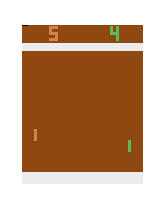
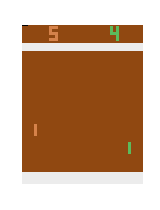
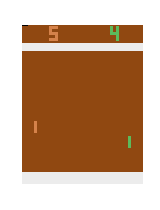
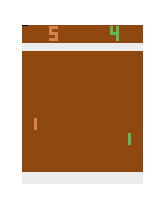
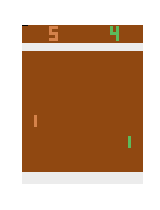
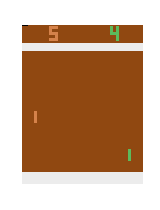
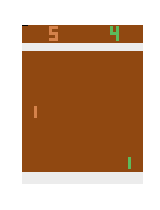
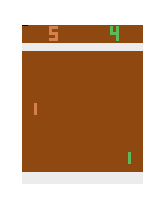
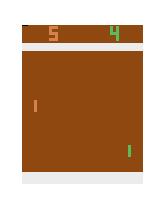
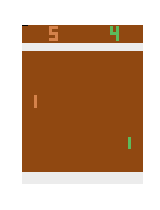
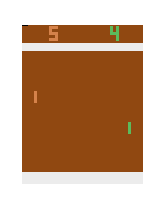
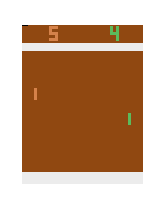
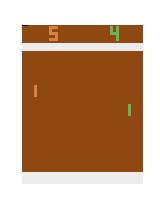
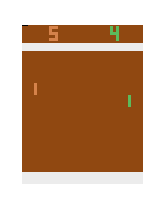
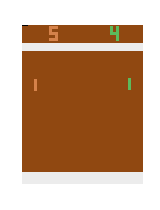
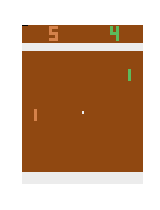
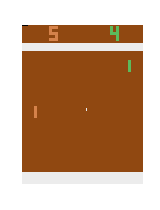
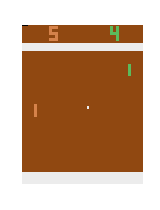
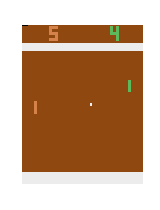
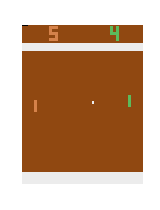
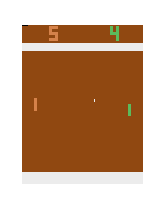
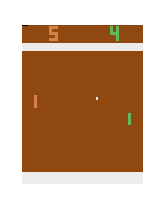
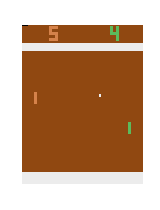
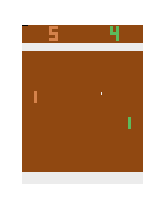
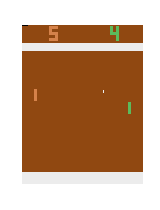
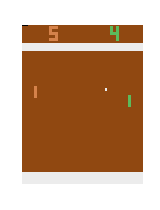
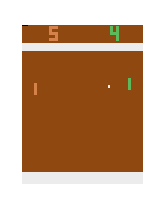
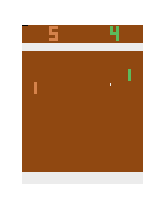
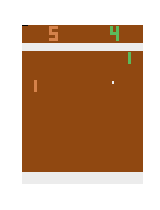
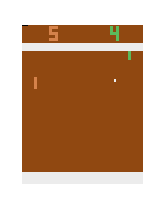
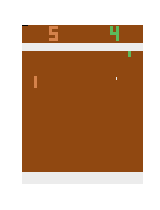
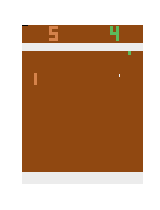
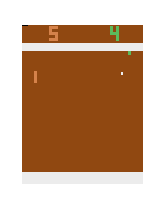
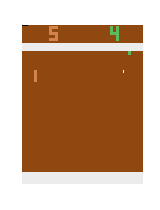
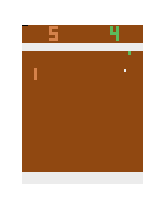
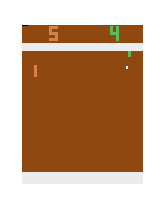
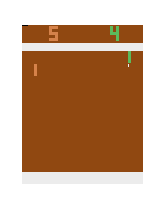
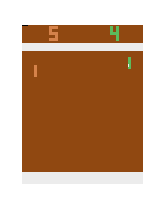
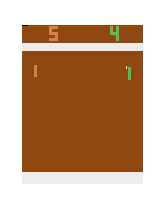
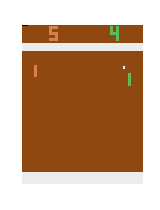
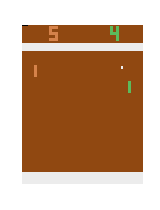
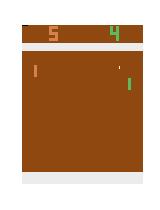
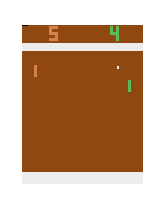
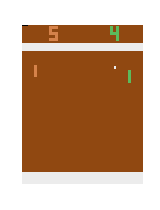
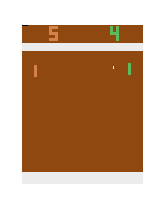
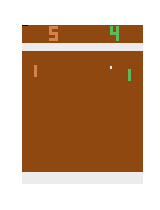
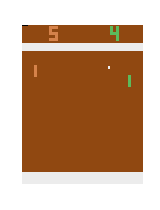
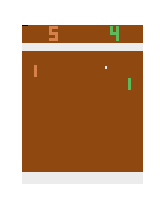
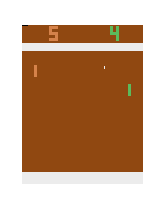
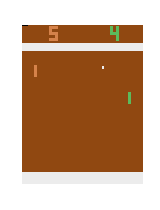
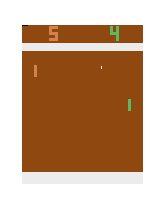
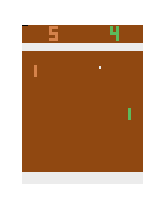
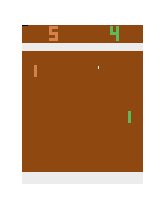
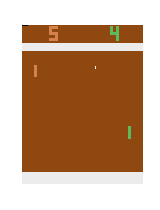
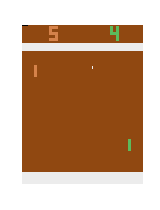
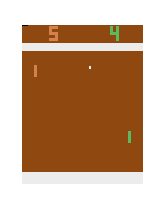
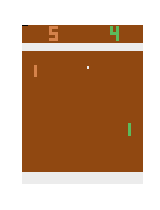
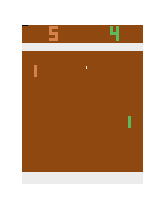
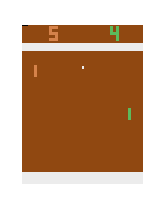
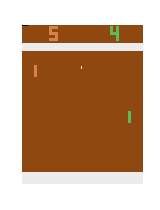
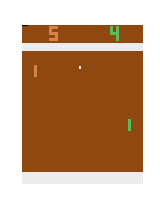
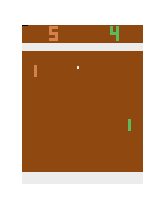
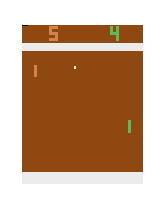
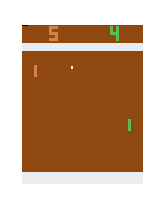
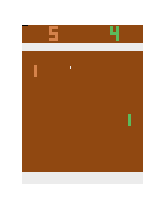
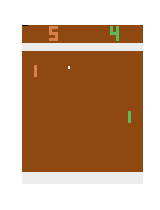
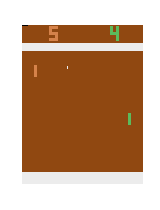
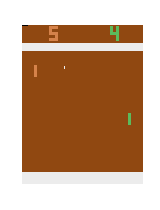
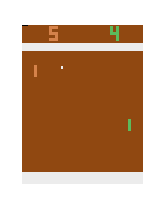
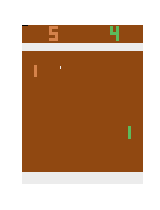
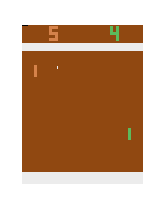
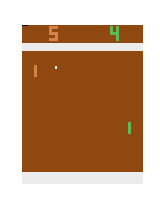
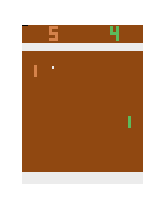
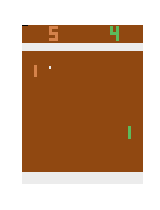
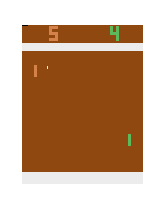
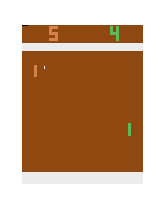
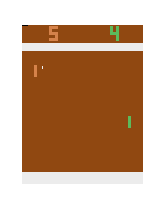
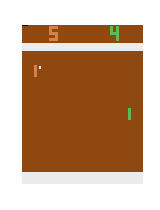
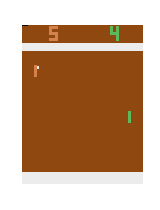
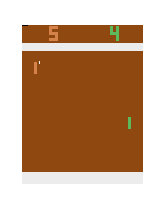
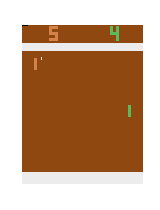
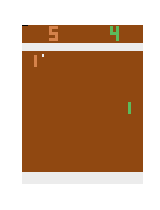
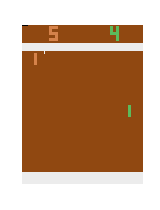
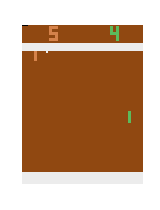
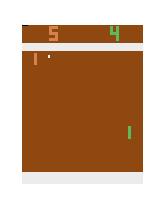
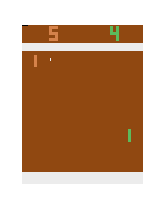
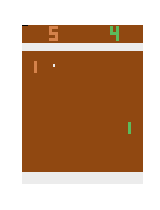
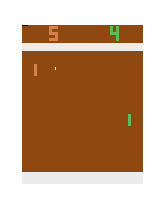
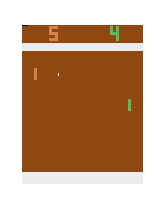
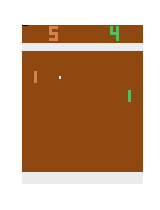
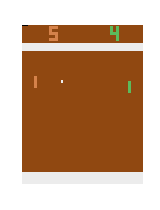
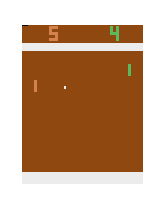
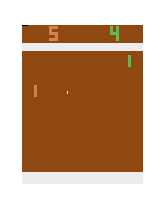
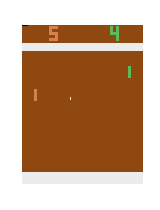
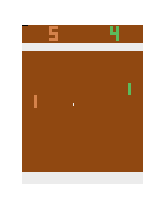
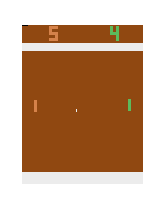
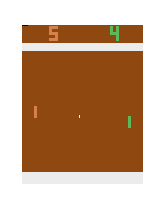
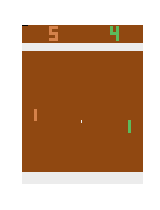
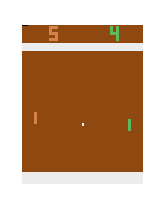
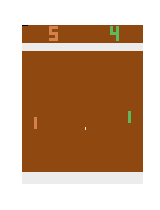
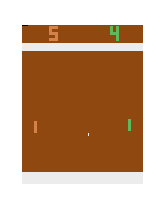
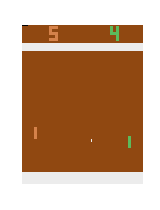
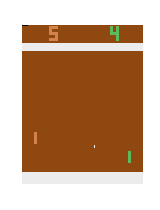
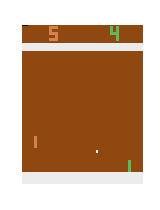
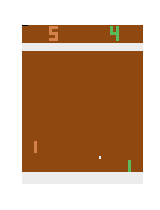
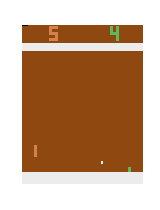
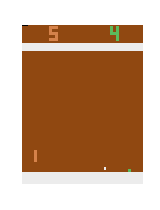
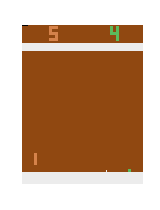
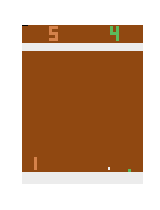
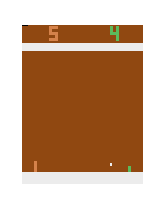
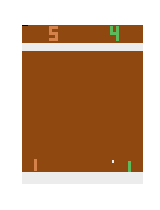
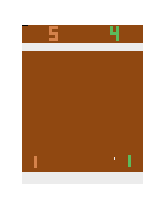
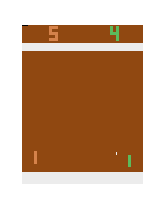
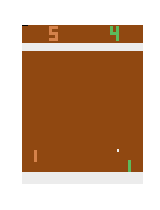
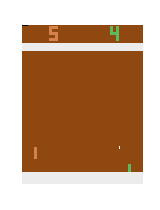
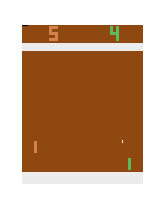
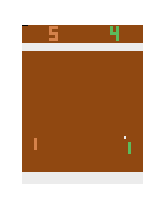
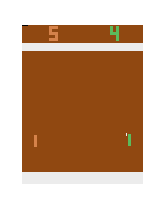
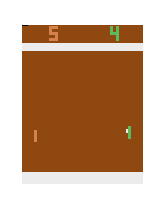
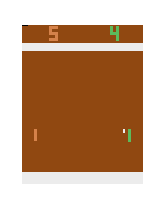
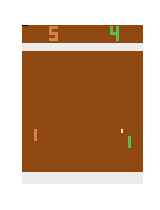
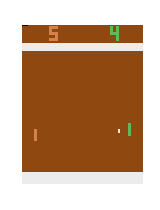
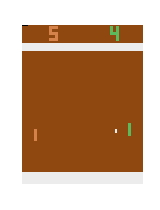
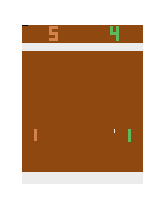
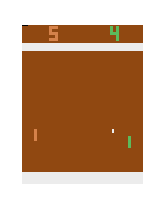
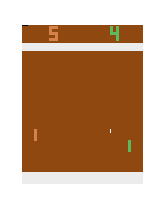
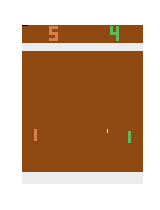
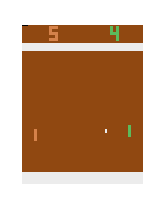
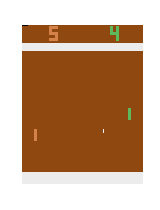
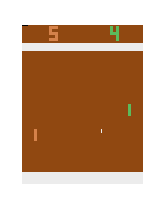
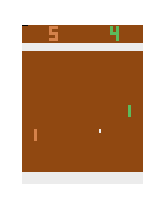
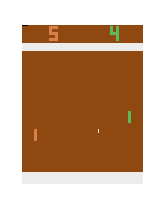
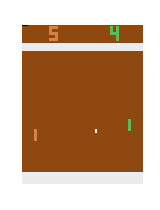
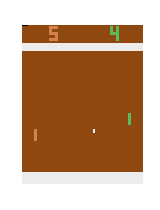
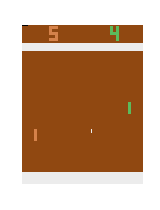
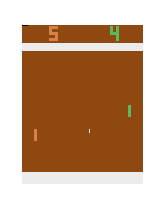
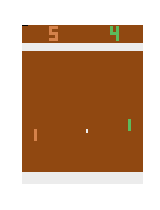
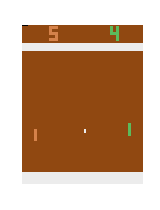
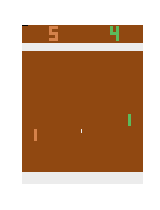
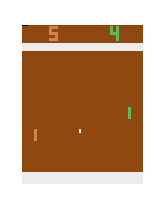
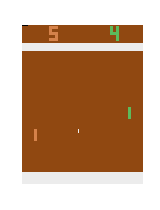
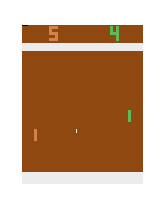
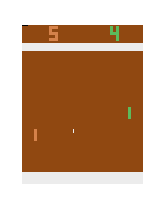
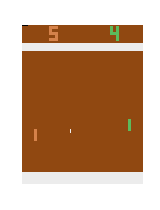
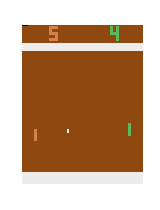
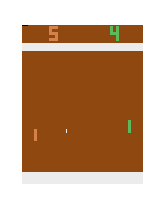
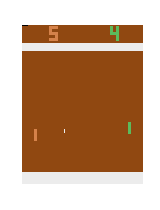
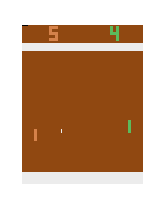
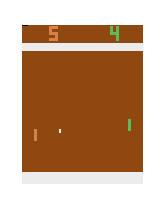
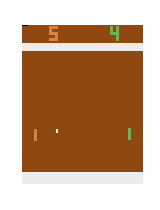
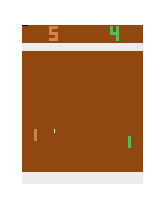
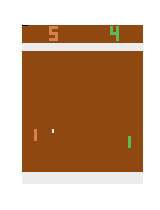
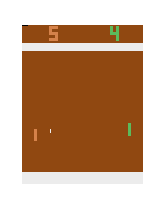
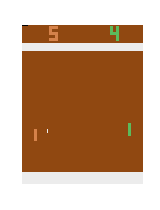
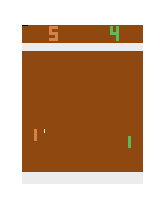
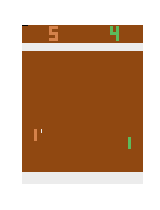
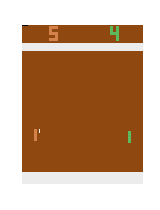
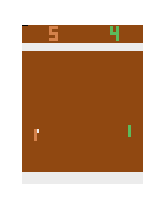
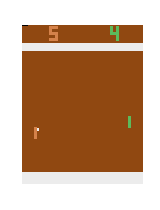
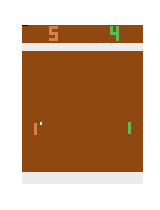
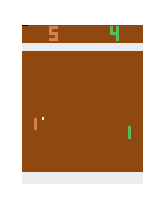
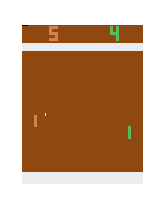
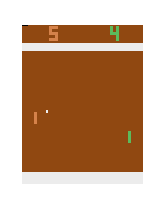
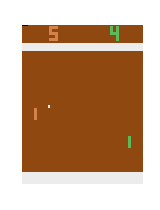
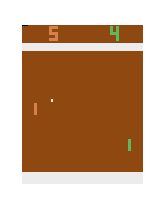
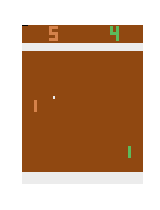
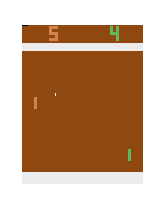
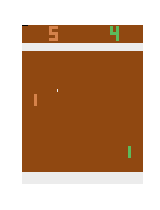
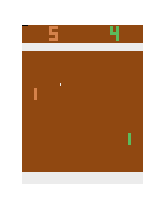
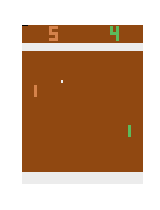
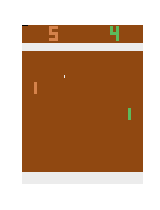
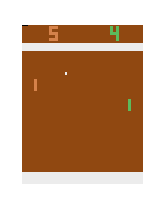
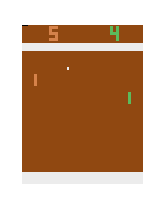
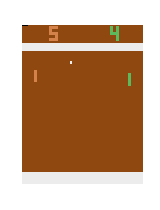
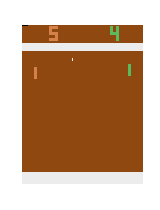
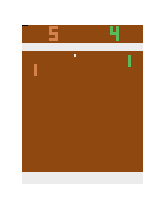
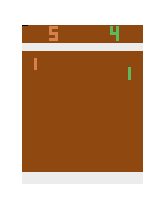
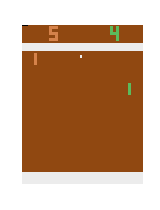
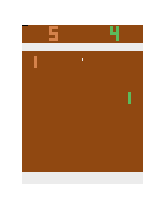
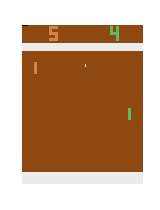
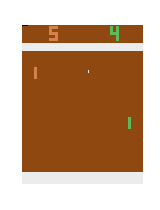
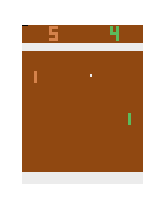
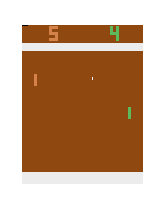
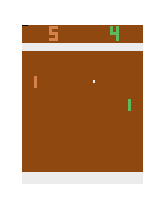
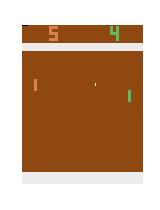
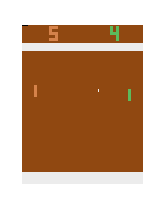
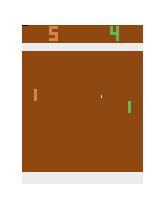
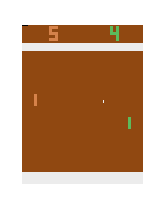
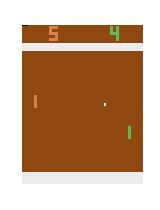
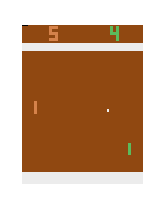
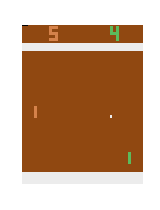
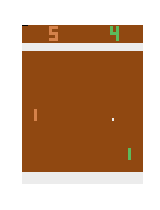
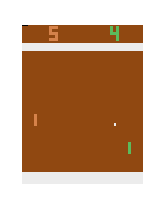
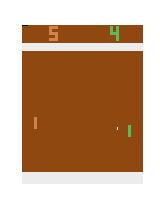
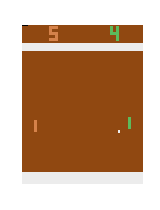
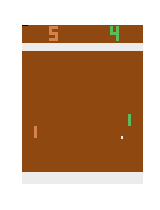
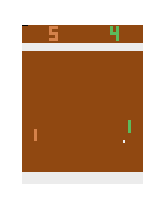
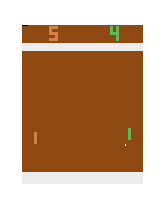
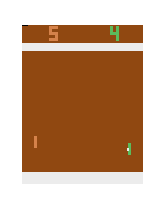
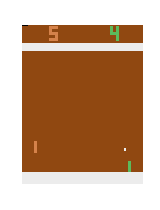
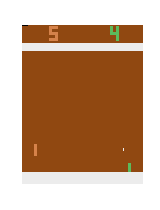
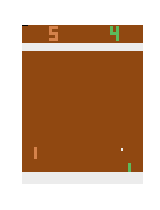
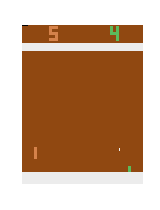
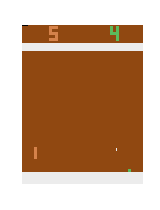
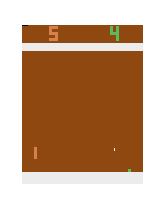
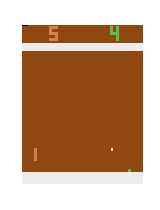
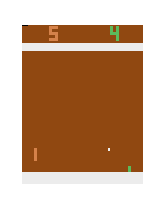
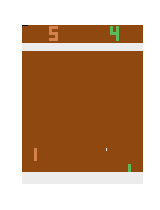
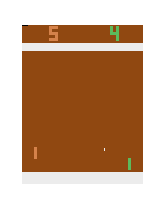
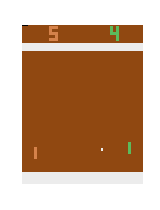
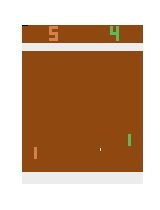
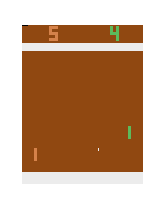
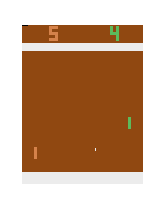
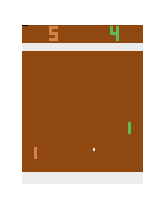
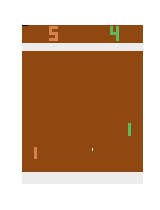
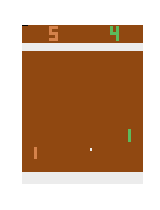
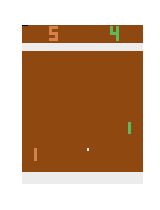
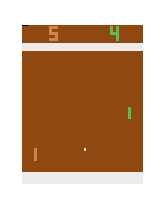
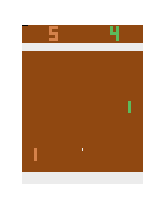
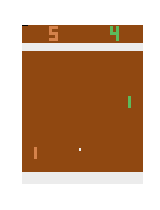
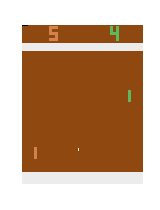
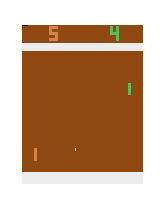
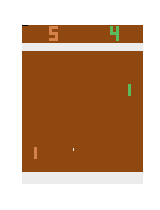
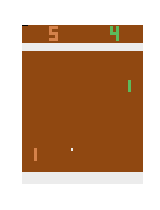
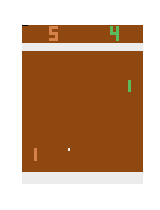
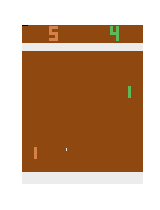
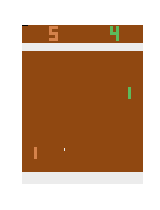
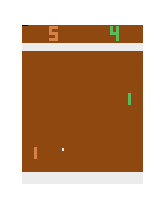
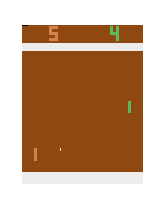
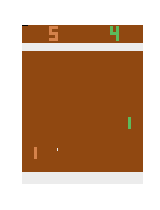
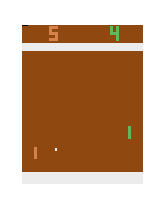
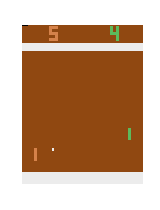
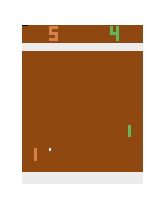
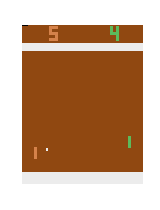
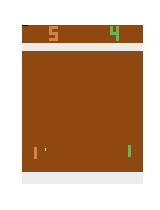
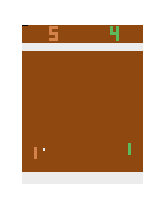
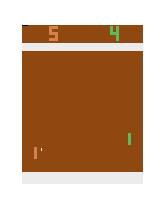
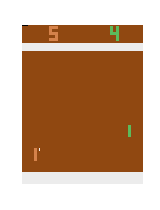
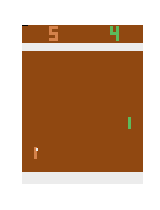
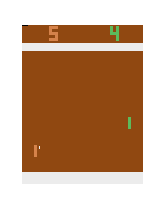
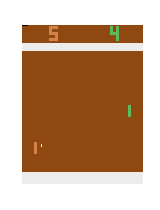
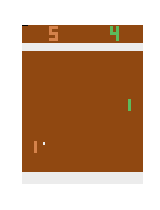
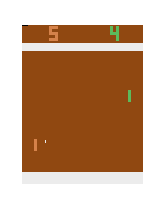
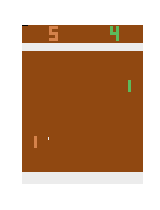
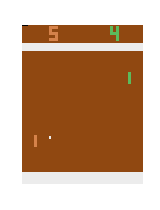
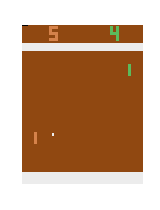
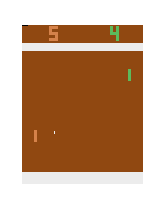
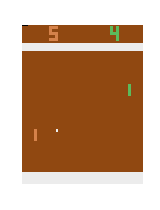
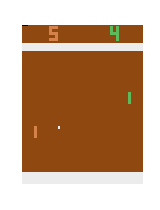
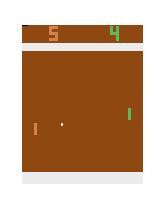
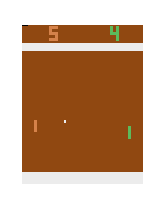
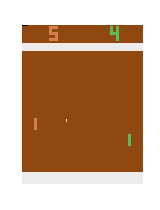
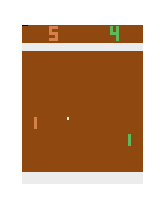
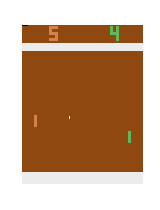
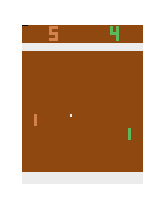
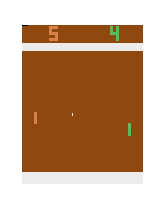
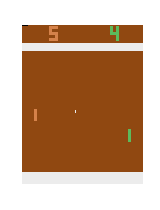
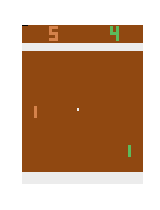
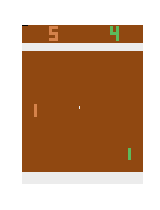
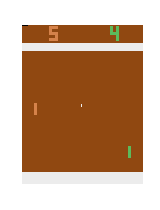
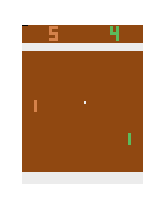
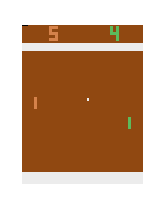
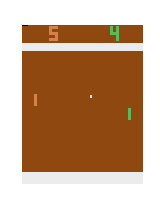
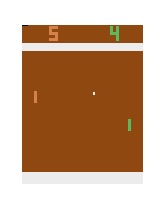
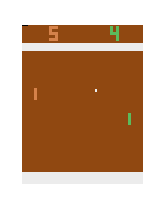
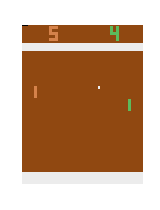
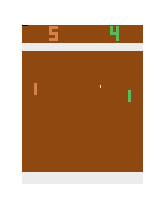
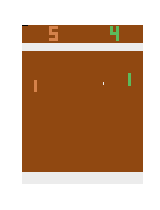
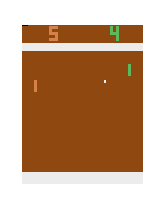
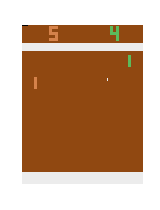
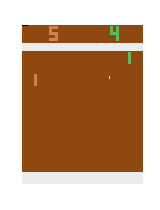
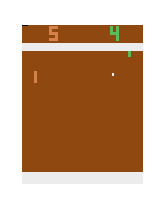
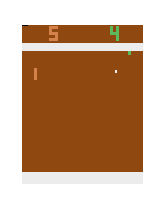
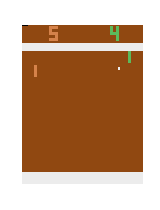
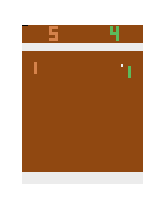
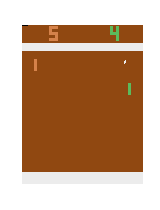
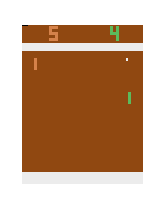
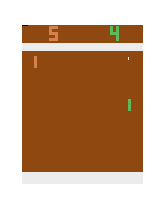
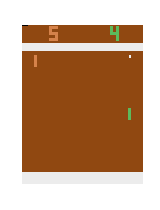
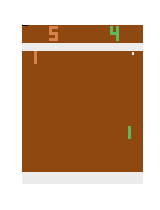
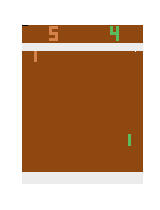
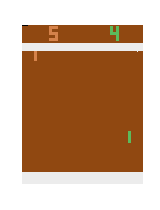
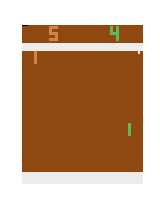
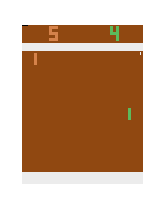
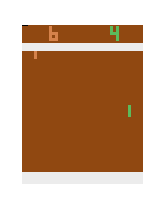
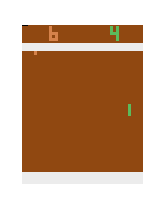
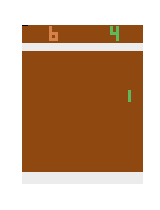
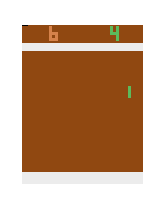
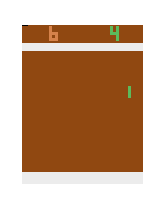
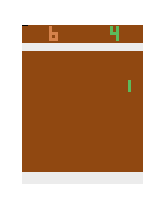
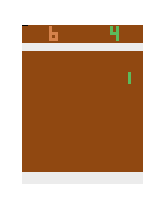
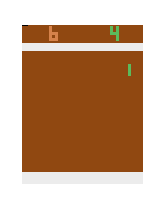
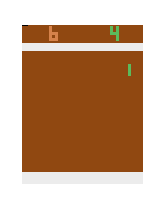
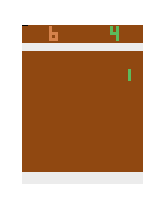
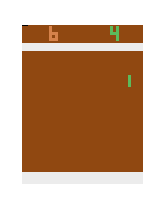
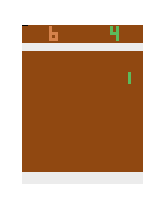
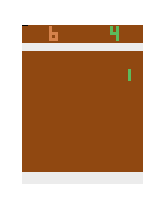
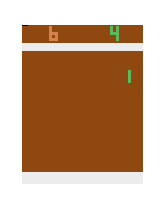
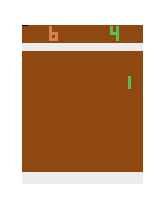
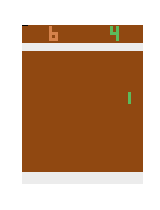
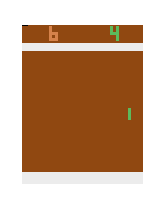
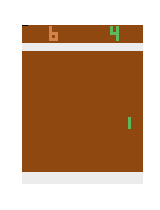
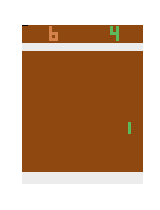
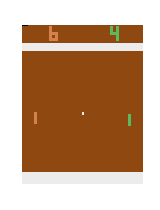
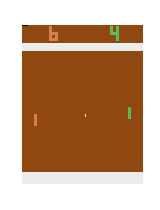
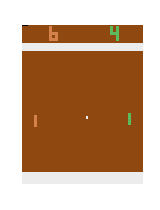
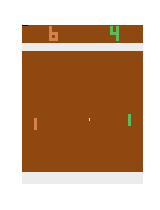
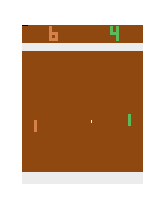
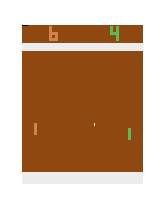
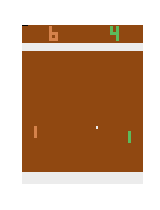
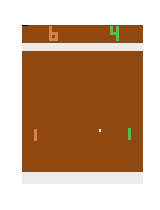
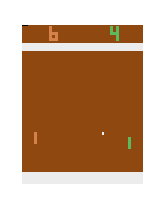
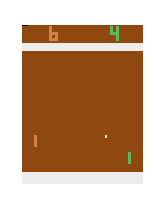
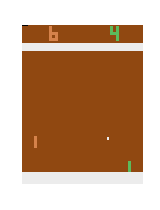
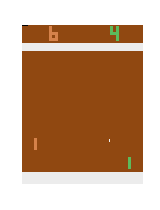
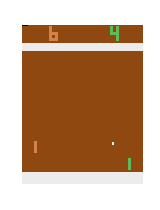
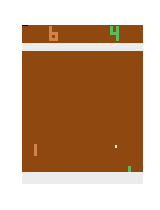
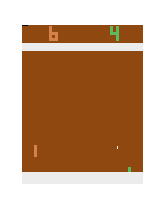
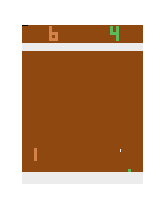
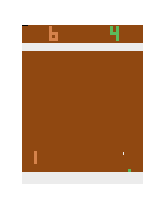
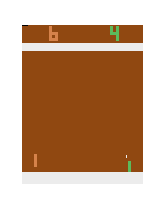
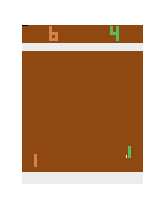
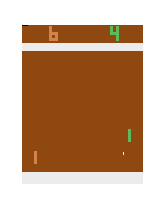
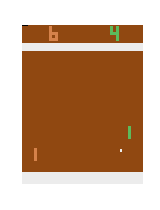
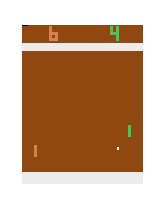
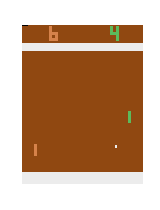
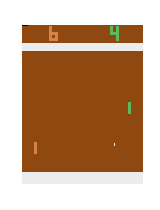
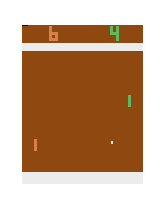
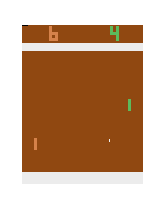
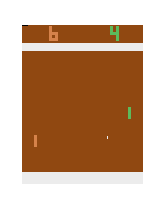
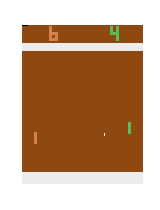
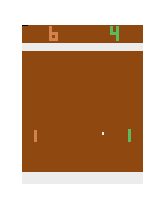
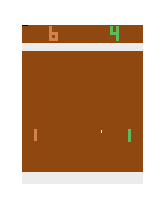
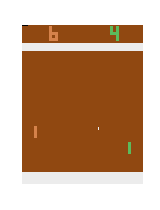
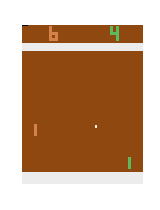
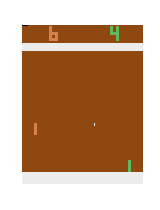
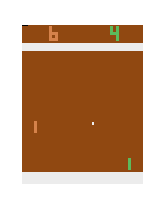
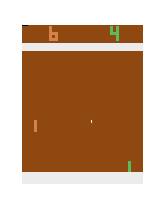
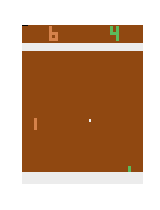
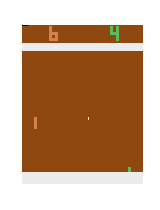
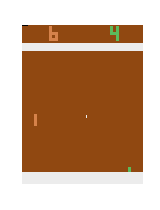
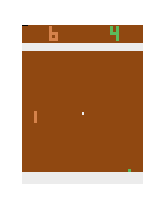
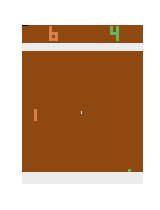
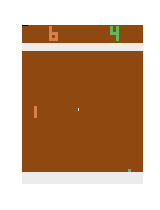
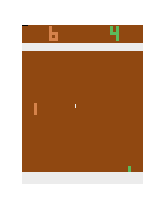
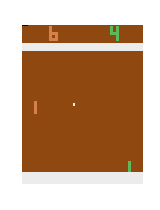
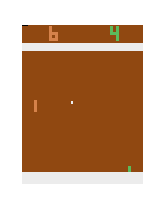
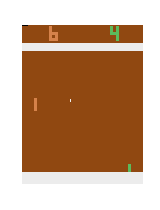
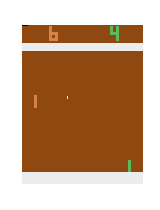
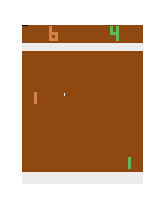
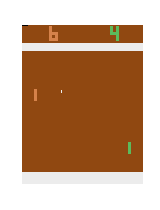
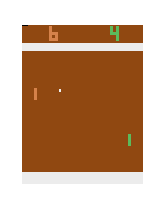
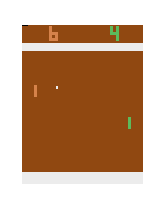
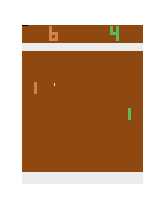
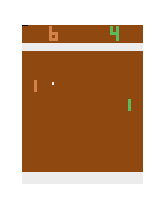
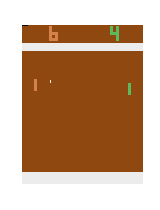
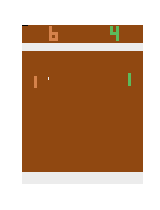
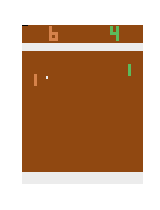
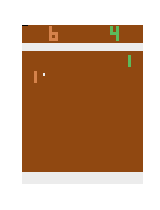
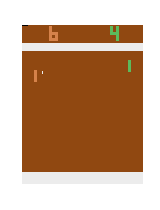
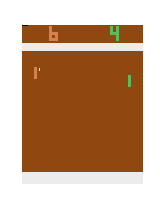
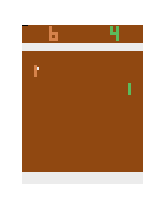
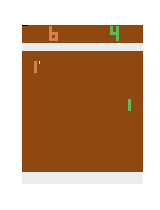
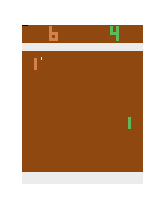
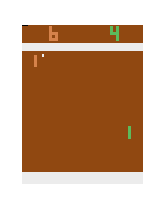
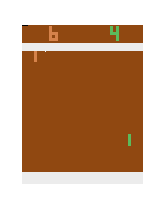
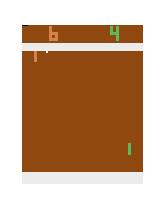
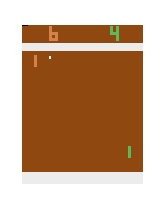
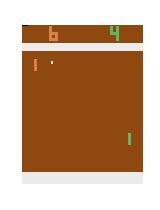
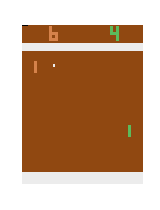
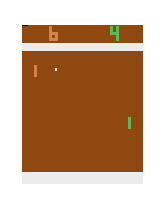
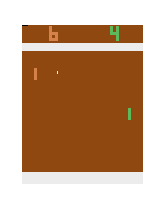
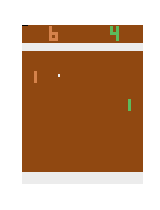
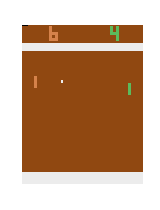
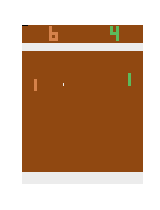
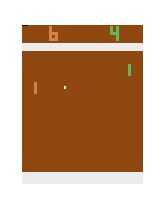
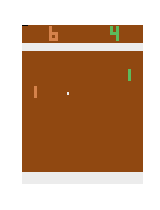
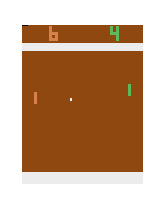
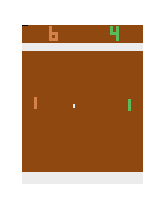
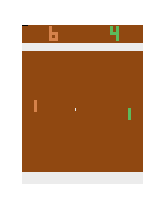
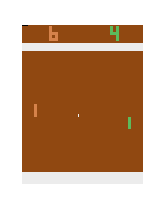
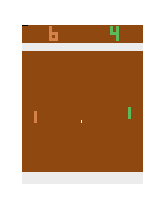
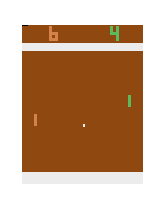
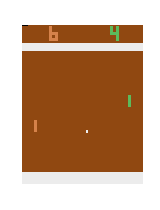
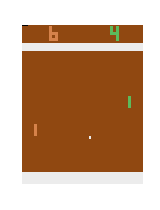
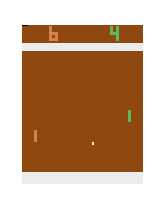
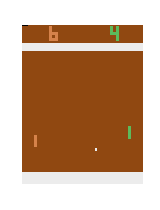
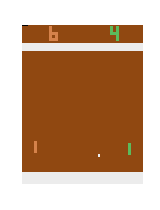
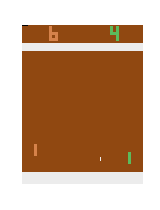
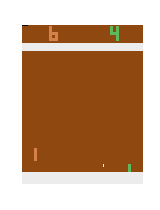
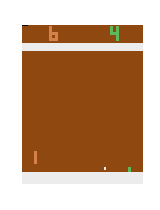
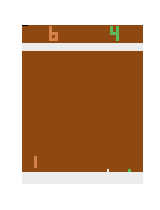
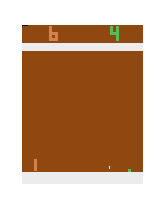
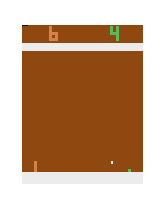
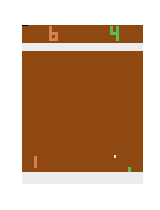
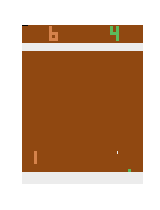
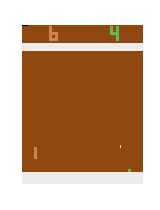
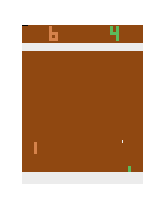
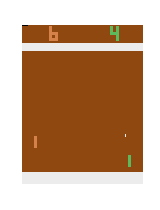
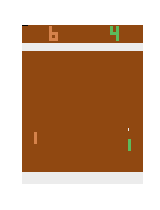
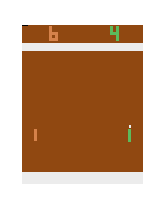
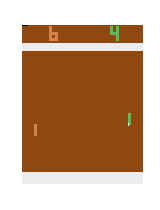
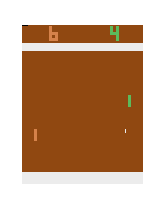
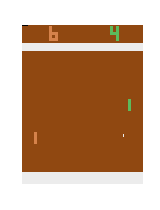
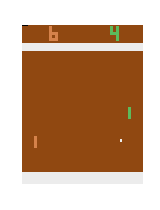
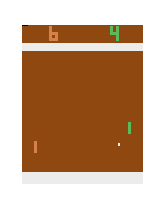
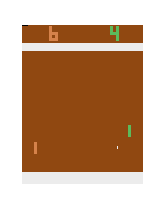
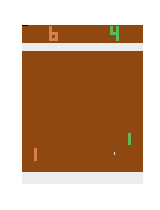
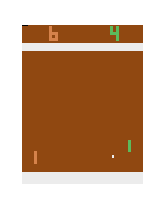
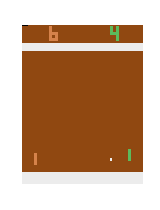
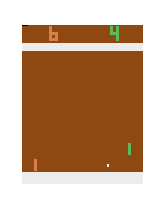
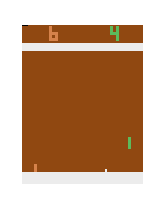
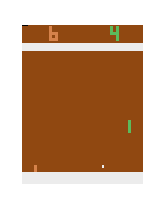
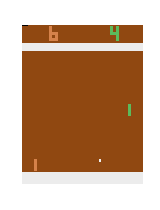
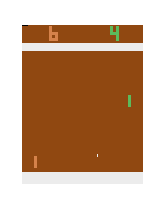
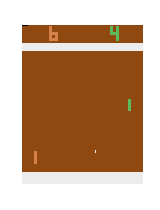
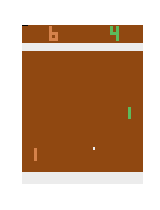
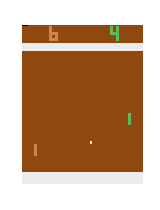
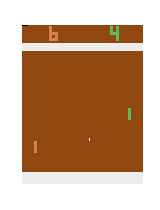
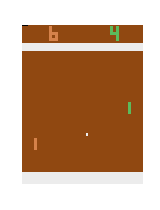
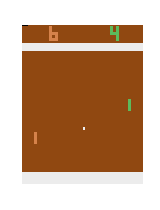
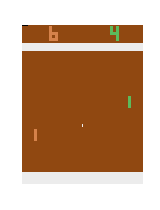
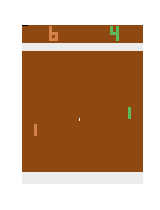
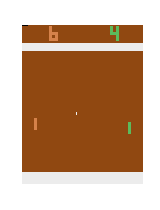
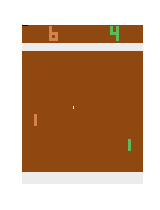
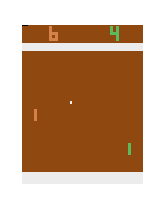
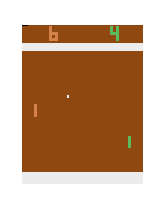
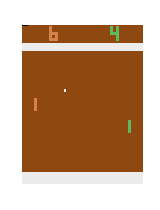
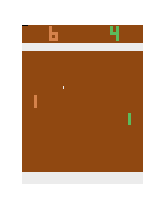
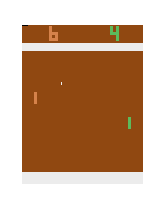
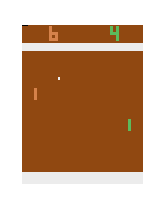
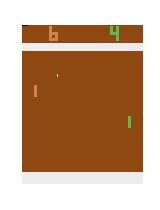
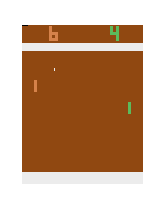
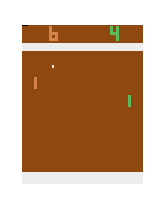
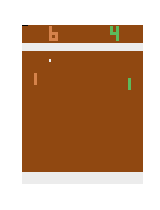
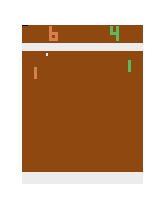
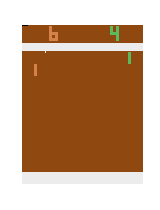
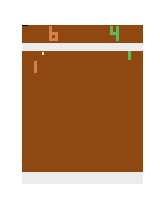
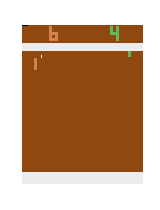
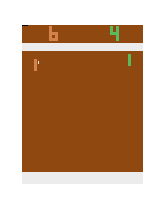
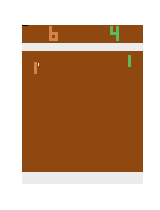
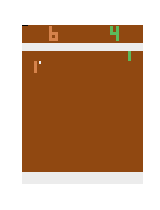
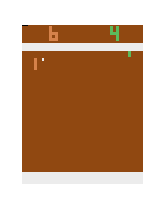
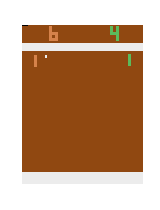
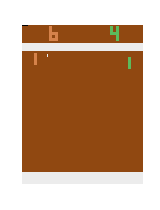
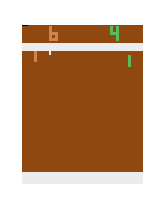
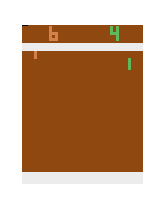
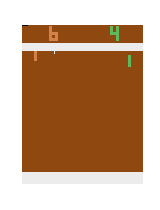
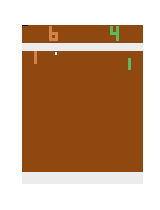
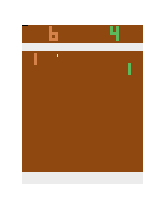
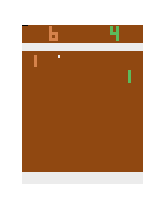
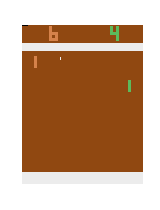
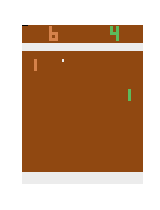
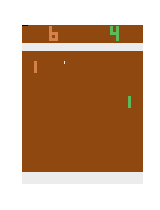
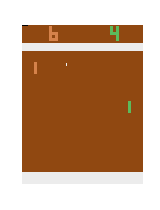
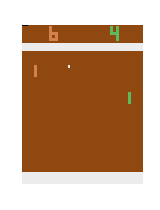
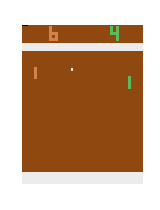
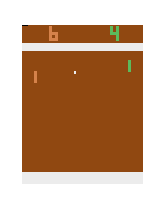
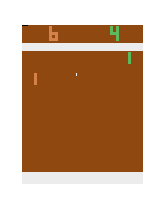
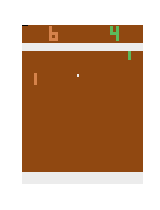
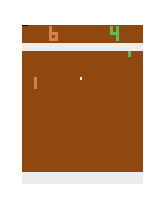
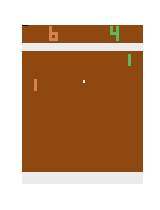
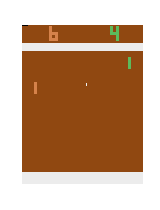
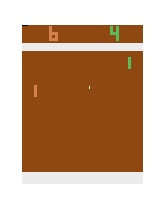
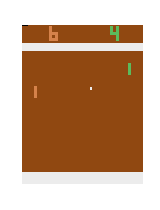
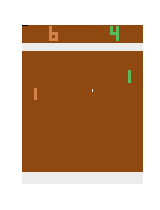
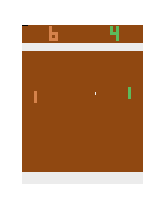
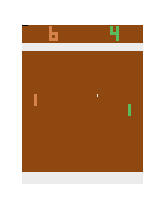
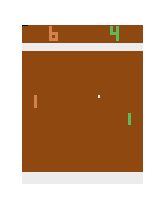
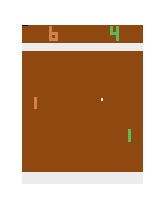
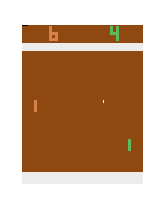
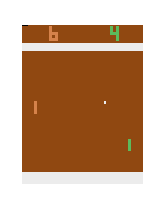
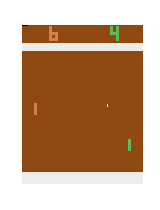
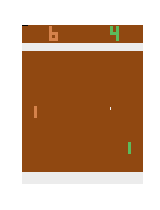
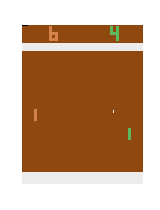
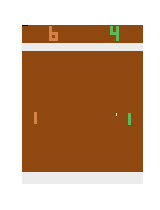
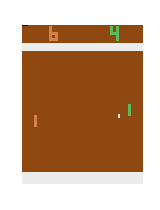
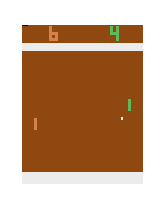
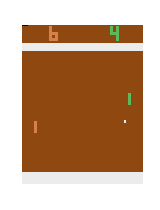
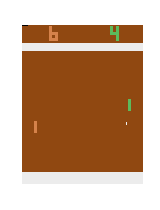
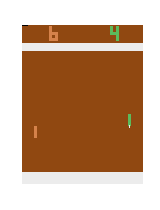
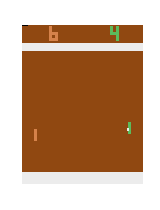
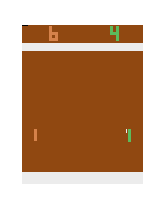
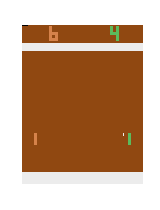
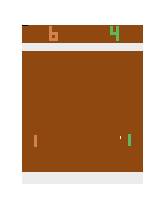
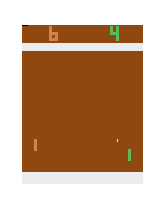
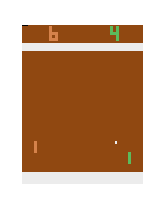
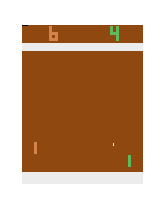
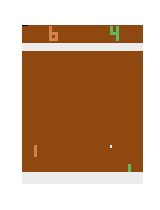
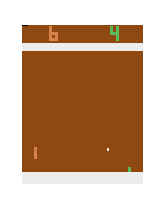
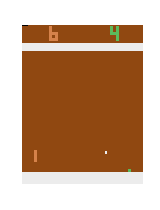
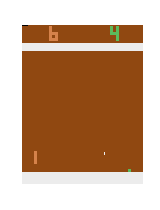
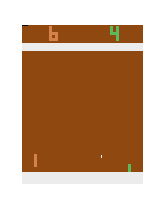
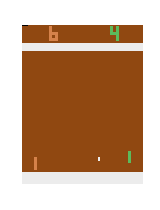
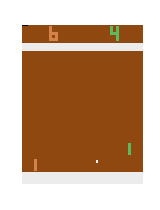
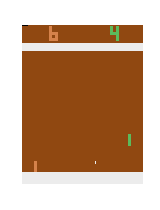
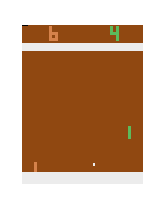
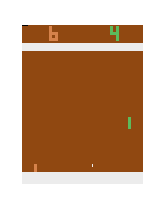
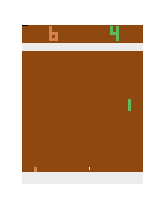
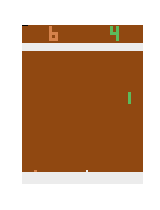
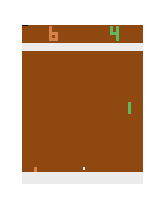
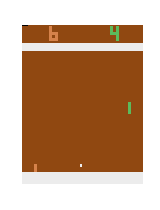
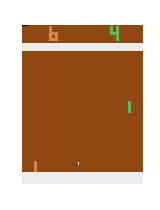
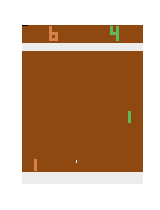
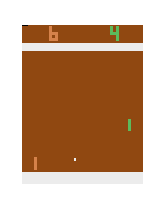
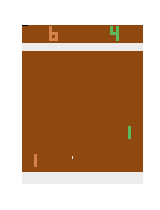
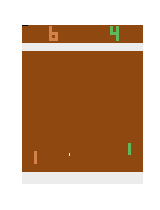
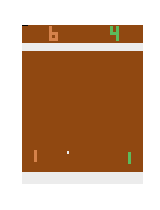
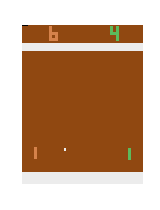
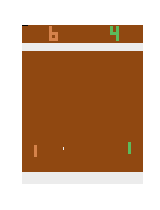
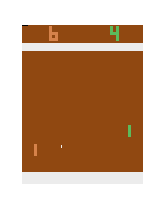
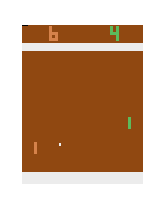
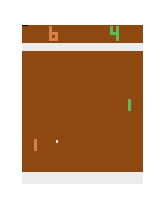
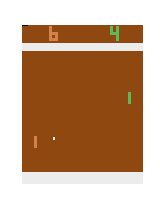
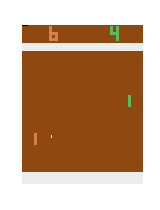
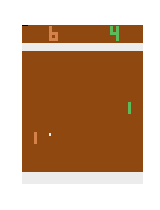
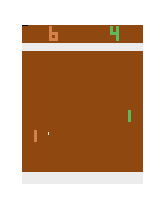
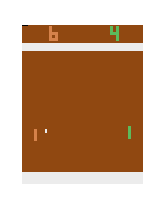
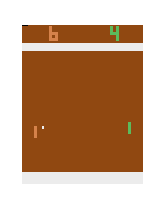
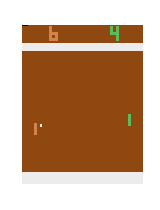
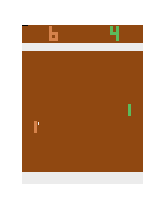
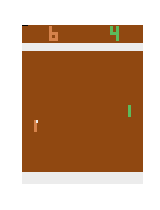
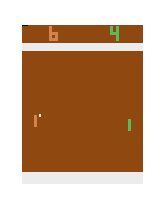
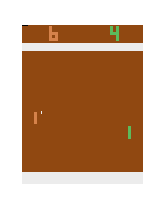
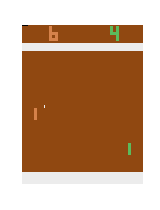
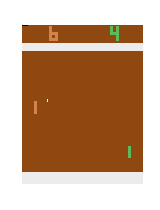
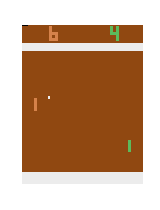
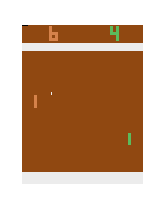
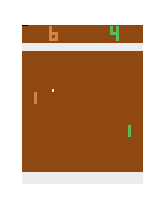
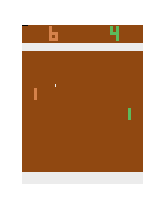
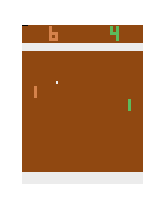
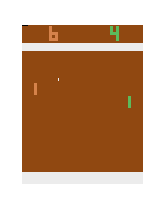
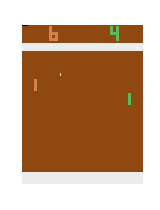
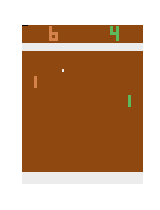
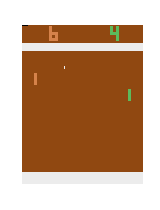
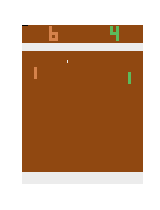
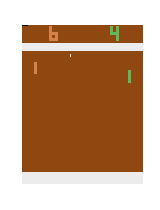
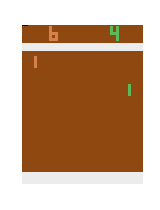
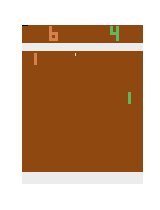
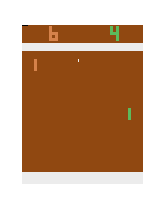
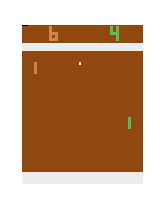
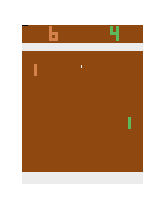
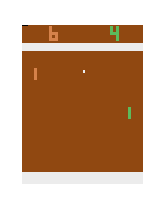
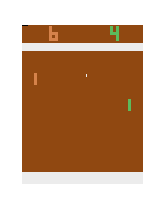
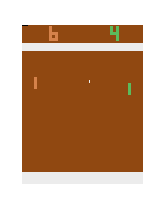
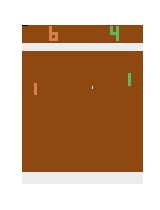
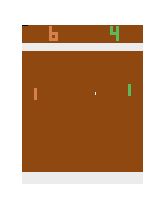
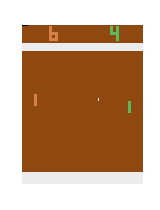
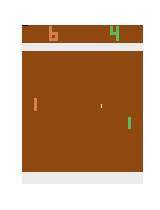
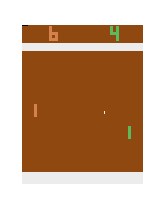
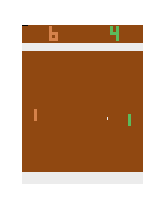
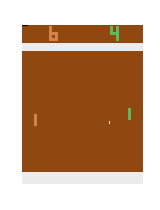
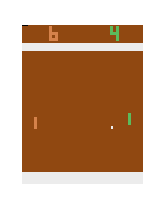
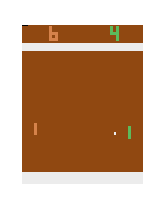
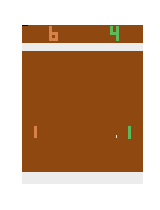
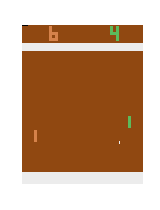
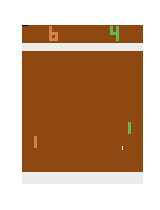
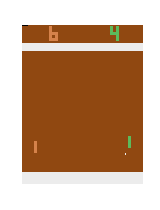
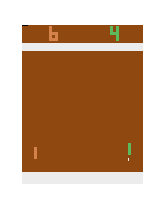
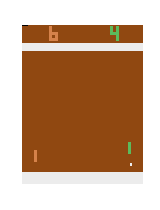
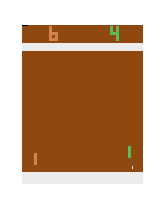
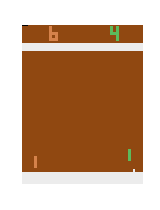
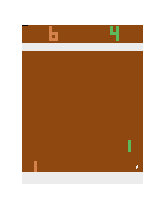
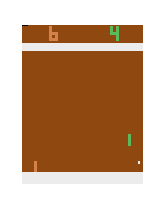
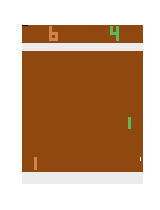
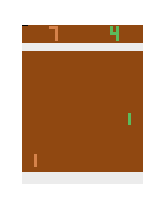
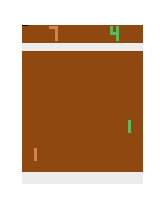
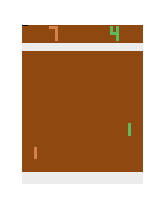
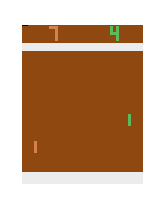
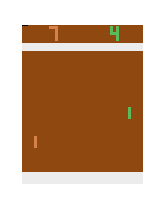
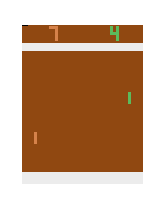
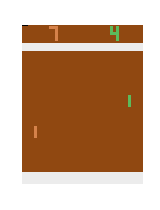
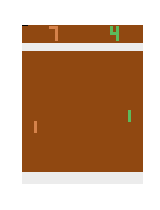
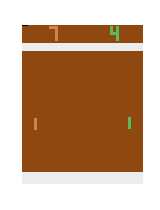
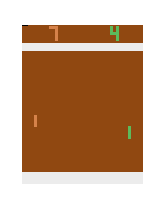
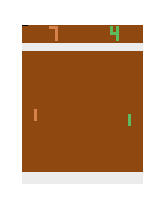
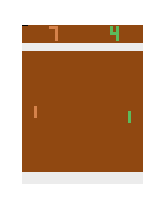
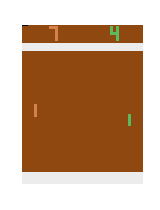
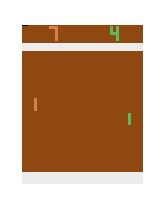
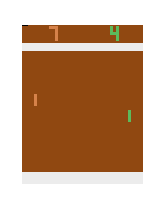
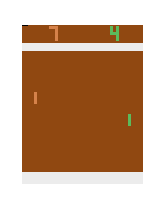
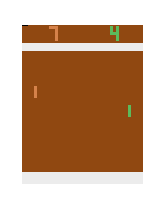
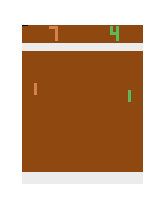
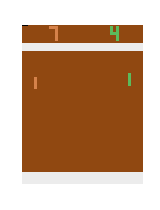
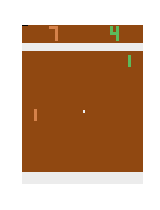
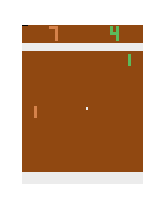
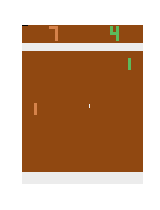
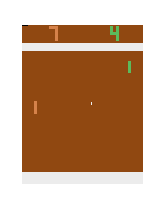
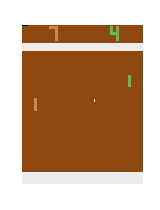
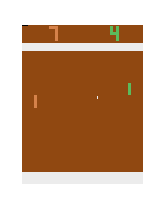
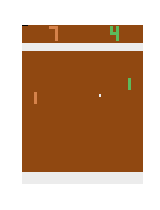
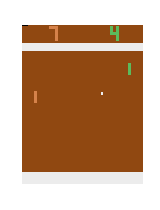
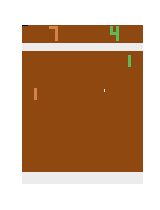
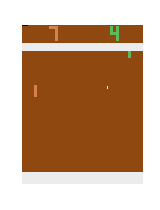
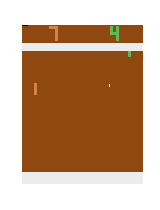
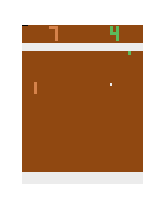
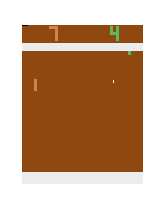
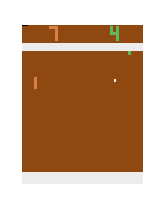
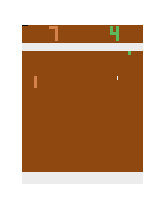
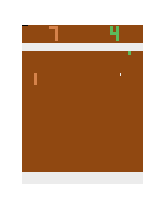
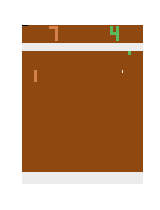
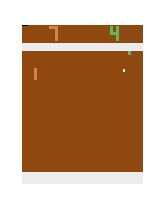
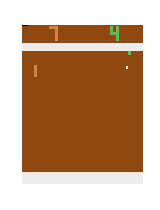
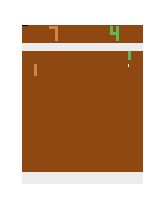
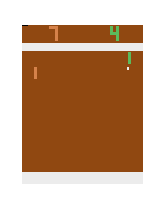
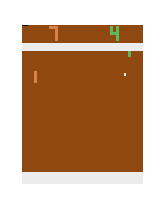
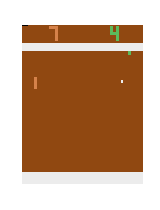
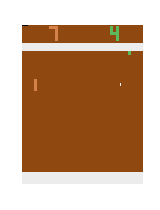
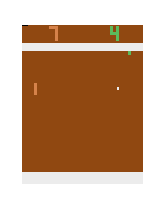
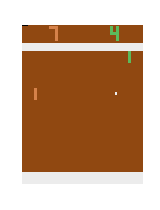
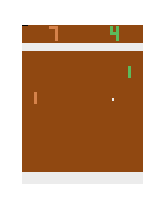
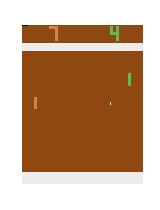
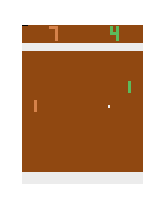
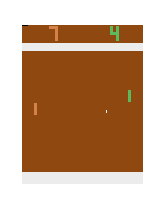
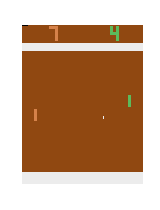
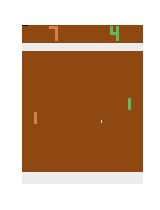
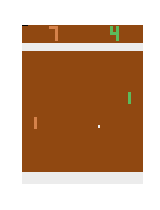
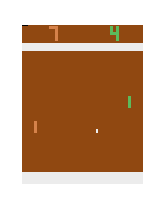
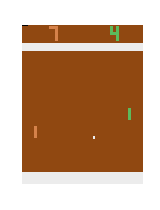
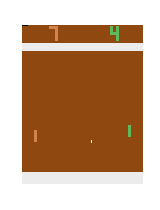
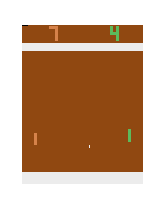
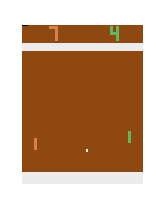
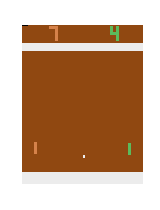
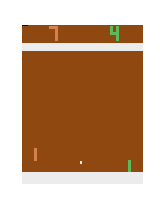

In [26]:
display_frames_as_gif(frames)

In [15]:
!conda list

# packages in environment at /home/zikribayraktar/miniconda3:
#
asn1crypto                0.22.0                   py36_0  
atari-py                  0.1.1                     <pip>
bleach                    1.5.0                    py36_0  
bzip2                     1.0.6                         3  
cffi                      1.10.0                   py36_0  
cmake                     3.6.3                         0  
conda                     4.3.22                   py36_0  
conda-env                 2.6.0                         0  
cryptography              1.8.1                    py36_0  
curl                      7.54.1                        0  
cycler                    0.10.0                   py36_0  
dbus                      1.10.10                       0  
decorator                 4.0.11                   py36_0  
entrypoints               0.2.2                    py36_1  
expat                     2.1.0                         0  
fontconfig                2.12.1      